In [2]:
import pickle
import glob
import typing as t
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as ac
from linelisttools.plot import get_vibrant_colors
from scipy.integrate import simpson

label_fontsize = 22
tick_fontsize = 18
line_width = 3

def microns_to_wavenumbers(microns: float) -> float:
    if microns == 0:
        return microns
    else:

        return 1e4 / microns


def wavenumbers_to_microns(wavenumbers: float) -> float:
    if wavenumbers == 0:
        return wavenumbers
    else:

        return 1e4 / wavenumbers


def invert_hex(color_hex: str) -> str:
    return f"#{hex(int("FFFFFF", 16) - int(color_hex[1:], 16))[2:]}"

In [3]:
profiles = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_med.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
co_mmr = 10 ** profiles["logCO"].to_numpy()[::-1]
h2o_mmr = 10 ** profiles["logH2O"].to_numpy()[::-1]
oh_mmr = 10 ** profiles["logOH"].to_numpy()[::-1]
oh_scale_factor = 1
oh_mmr *= oh_scale_factor
fe_mmr = 10 ** profiles["logFe"].to_numpy()[::-1]

mass_h = 1.00782503223
mass_he = 4.00260325413
mass_o = 15.99491461957
mass_co = 12 + mass_o
mass_h2o = 2*mass_h + mass_o
mass_oh = mass_o + mass_h
mass_fe = 55.93493632600

# co_o_mass_frac = mass_o / mass_co
# h2o_o_mass_frac = mass_o / mass_h2o
# oh_o_mass_frac = mass_o / mass_oh
#
# total_o_mmr = (co_mmr[0] * co_o_mass_frac) + (h2o_mmr[0] * h2o_o_mass_frac)
# print(total_o_mmr)
# o_mmr = np.repeat(total_o_mmr, len(profiles)) - (co_mmr * co_o_mass_frac) - (h2o_mmr * h2o_o_mass_frac)
# print(o_mmr)

h_mmr = 10 ** (-0.2) # Median
h_mmr = np.repeat(h_mmr, len(profiles))
he_mmr = np.ones_like(h_mmr) - h_mmr - co_mmr - h2o_mmr - oh_mmr - fe_mmr

h_rmmr = h_mmr / mass_h
he_rmmr = he_mmr / mass_he
# o_rmmr = o_mmr / mass_o
co_rmmr = co_mmr / mass_co
h2o_rmmr = h2o_mmr / mass_h2o
oh_rmmr = oh_mmr / mass_oh
fe_rmmr = fe_mmr / mass_fe

central_pressure = 10 ** profiles["logP"].to_numpy()[::-1] << u.bar
pressure_levels = (
    np.loadtxt(r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl_fit_pressure_levels.txt") << u.bar
)
temperature_profile = profiles["T"].to_numpy()[::-1] << u.K
# hydrogen_vmr = 10 ** (-0.2)
# hydrogen_vmr = h_mmr / mass_h

# hydrogen_vmr = np.repeat(hydrogen_vmr, len(central_pressure))

# he_vmr = np.ones_like(hydrogen_vmr) - hydrogen_vmr - co_vmr - h2o_vmr - oh_vmr - fe_vmr

sum_rmmr = sum([h_rmmr, he_rmmr,
                 # o_rmmr,
                 co_rmmr, h2o_rmmr, oh_rmmr, fe_rmmr])
h_vmr = h_rmmr / sum_rmmr
he_vmr = he_rmmr / sum_rmmr
# o_vmr = o_rmmr / sum_rmmr
co_vmr = co_rmmr / sum_rmmr
h2o_vmr = h2o_rmmr / sum_rmmr
oh_vmr = oh_rmmr / sum_rmmr
fe_vmr = fe_rmmr / sum_rmmr

profiles_maxl = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
temperature_profile_maxl = profiles_maxl["T"].to_numpy()[::-1] << u.K



oh_num_dens = np.array([7.01036253e+02, 1.48813222e+03, 3.15518174e+03, 6.68013711e+03, 1.41191526e+04, 2.97830058e+04,
                        6.26807250e+04, 1.31575473e+05, 2.75403937e+05, 5.74667457e+05, 1.19519406e+06, 2.47738891e+06,
                        5.11777526e+06, 1.05374570e+07, 2.16286589e+07, 4.42651955e+07, 9.03552618e+07, 1.84006098e+08,
                        3.73964200e+08, 7.58706037e+08, 1.53702218e+09, 3.10996308e+09, 6.28624286e+09, 1.26960064e+10,
                        2.56241854e+10, 5.16887153e+10, 1.04219784e+11, 2.10063551e+11, 4.23271437e+11, 8.52446242e+11,
                        1.71304027e+12, 3.41271157e+12, 6.62997249e+12, 1.24334409e+13, 1.52809966e+13, 1.08937201e+13,
                        7.81801870e+12, 5.68490340e+12, 4.19314422e+12, 3.13356623e+12, 2.36813576e+12, 1.80638422e+12,
                        1.38835749e+12, 1.07360451e+12, 8.34283594e+11, 6.50851218e+11, 5.09334842e+11, 3.99578377e+11,
                        3.14091628e+11, 2.47280710e+11, 1.94923103e+11, 1.53802739e+11, 1.21451793e+11, 9.59649427e+10,
                        4.04155609e+10, 1.25756037e+10, 3.91445559e+09, 1.21879624e+09, 3.79558935e+08, 1.18221260e+08,
                        3.68269133e+07, 1.14730017e+07, 3.57455483e+06, 1.11376379e+06, 3.47044351e+05, 1.08141727e+05,
                        3.36988152e+04, 1.05013775e+04, 3.27117519e+03, 1.01919833e+03, 3.17595356e+02, 9.89727054e+01,
                        3.08438463e+01, 9.61230493e+00, 2.99564186e+00, 9.33586066e-01, 2.90951299e-01, 9.06749495e-02,
                        2.82588945e-02, 8.80691197e-03]) << u.cm**-3
# Size of each layer?
planet_radius = 130830360 * u.m
altitude = np.array([0., 28911.22163328, 284658.69512139, 310796.27161053, 542605.89165338, 566362.42859974, 777825.37910708,
                     799582.75368623, 994191.84978125, 1014319.45399919, 1195425.20318672, 1214272.26563916, 1384984.98265428,
                     1402868.05043419, 1565932.34620195, 1583122.37118726, 1740814.66165624, 1757529.19056576, 1911620.75601544,
                     1928024.0417366, 2079815.97248072, 2096025.6951755, 2246430.04719567, 2262527.1479376, 2412161.30495047,
                     2428199.84192994, 2577471.58650289, 2593486.94164579, 2742661.33128269, 2758676.71977894, 2907972.53281141,
                     2924044.09766684, 3075499.40981388, 3092364.83942792, 3261207.67087855, 3281206.57643808, 3488460.21950394,
                     3513063.93552062, 3763054.7997063, 3791948.28302645, 4077627.04607448, 4109869.57948491, 4422206.90744858,
                     4456882.06968537, 4788233.49724523, 4824626.83606529, 5169355.69897861, 5206960.04916881, 5561177.82720691,
                     5599650.49669721, 5960772.65234644, 5999888.68262952, 6366236.04240559, 6405850.46152646, 6776348.64710019,
                     6816375.53866959, 7190444.52802697, 7230825.87738565, 7607965.88835926, 7648660.63556605, 8028591.58413801,
                     8069576.97740847, 8452138.33676184, 8493401.21856865, 8878500.86861419, 8920033.85036403, 9307621.91292058,
                     9349421.2182565, 9739474.42992098, 9781556.25616381, 10174316.20992916, 10216675.53246613, 10611947.47903479,
                     10654574.80850774, 11052332.09582643, 11095227.30971948, 11495479.83547229, 11538644.57480589,
                     11941410.15855473, 11984846.53532292]) * u.m
altitude = np.concatenate((altitude, [planet_radius]))
volume = 4 * np.pi * (altitude[1:]**3 - altitude[:-1]**3) / 3
num_oh = volume.to(u.cm**3) * oh_num_dens

In [29]:
# # Numerically the same as multiplying the VMR by the scale factor.
# oh_rmmr_01 = oh_mmr * 10**-1 / mass_oh
# oh_rmmr_10 = oh_mmr * 10**1 / mass_oh
# oh_rmmr_100 = oh_mmr * 10**2 / mass_oh
# oh_rmmr_1000 = oh_mmr * 10**3 / mass_oh
#
# sum_mmr_m_01 = sum([h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr_01, fe_rmmr])
# sum_mmr_m_10 = sum([h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr_10, fe_rmmr])
# sum_mmr_m_100 = sum([h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr_100, fe_rmmr])
# sum_mmr_m_1000 = sum([h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr_1000, fe_rmmr])
#
# oh_vmr_01 = oh_rmmr_01 / sum_mmr_m_01
# oh_vmr_10 = oh_rmmr_10 / sum_mmr_m_10
# oh_vmr_100 = oh_rmmr_100 / sum_mmr_m_100
# oh_vmr_1000 = oh_rmmr_1000 / sum_mmr_m_1000
# # print(np.vstack((oh_vmr_01, oh_vmr * 0.1)).T)

[[2.61377550e-19 2.61377550e-19]
 [6.64250017e-19 6.64250017e-19]
 [1.68808715e-18 1.68808715e-18]
 [4.29000854e-18 4.29000854e-18]
 [1.09023833e-17 1.09023833e-17]
 [2.77066959e-17 2.77066959e-17]
 [7.04122188e-17 7.04122188e-17]
 [1.78941602e-16 1.78941602e-16]
 [4.54751994e-16 4.54751994e-16]
 [1.15568081e-15 1.15568081e-15]
 [2.93698139e-15 2.93698139e-15]
 [7.46387720e-15 7.46387720e-15]
 [1.89682723e-14 1.89682723e-14]
 [4.82048868e-14 4.82048868e-14]
 [1.22505154e-13 1.22505154e-13]
 [3.11327619e-13 3.11327619e-13]
 [7.91190276e-13 7.91190276e-13]
 [2.01068590e-12 2.01068590e-12]
 [5.10984261e-12 5.10984261e-12]
 [1.29858629e-11 1.29858629e-11]
 [3.30015324e-11 3.30015324e-11]
 [8.38682147e-11 8.38682146e-11]
 [2.13137905e-10 2.13137904e-10]
 [5.41656537e-10 5.41656534e-10]
 [1.37653512e-09 1.37653510e-09]
 [3.49824824e-09 3.49824813e-09]
 [8.89025080e-09 8.89025008e-09]
 [2.25931898e-08 2.25931852e-08]
 [5.74171285e-08 5.74170988e-08]
 [1.45917155e-07 1.45916964e-07]
 [3.708290

In [ ]:
transmission_lte = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_LTE_cont.txt")
transmission_nlte = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont.txt")
transmission_lte_x5 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_LTE_cont_x5.txt")
transmission_nlte_x5 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont_x5.txt")
transmission_lte_x10 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_LTE_cont_x10.txt")
transmission_nlte_x10 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont_x10.txt")
transmission_lte_L45 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_LTE_cont_L45.txt")
transmission_nlte_L45 = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont_L45.txt")

In [ ]:
# fig, (plt, plt, plt) = plt.subplots(3, 1, figsize=(7, 12))
figure_size = (15, 6)
x_label = r"Wavenumbers (10$^{4}$ cm$^\mathbf{-1}$)"
x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"

plt.figure(figsize=figure_size)
plt.plot(transmission_lte[:, 0] / 10000, transmission_lte[:, 1], label="LTE", color="#33BBEE")
plt.plot(transmission_nlte[:, 0] / 10000, transmission_nlte[:, 1], label="Non-LTE", color="#EE7733")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=0, right=transmission_lte[-1, 0] / 10000)
plt.ylabel(r"Flux (J/m$^\mathbf{2}$)", fontsize=label_fontsize, fontweight="bold")
plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
plt.plot(transmission_lte_x5[:, 0] / 10000, transmission_lte_x5[:, 1], label="LTE", color="#33BBEE")
plt.plot(transmission_nlte_x5[:, 0] / 10000, transmission_nlte_x5[:, 1], label="Non-LTE", color="#EE7733")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=0, right=transmission_lte[-1, 0] / 10000)
plt.ylabel(r"Flux (J/m$^\mathbf{2}$)", fontsize=label_fontsize, fontweight="bold")
plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_x5.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
plt.plot(transmission_lte_x10[:, 0] / 10000, transmission_lte_x10[:, 1], label="LTE", color="#33BBEE")
plt.plot(transmission_nlte_x10[:, 0] / 10000, transmission_nlte_x10[:, 1], label="Non-LTE", color="#EE7733")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=0, right=transmission_lte[-1, 0] / 10000)
plt.ylabel(r"Flux (J/m$^\mathbf{2}$)", fontsize=label_fontsize, fontweight="bold")
plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_x10.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
plt.plot(transmission_lte_L45[:, 0] / 10000, transmission_lte_L45[:, 1], label="LTE", color="#33BBEE")
plt.plot(transmission_nlte_L45[:, 0] / 10000, transmission_nlte_L45[:, 1], label="Non-LTE", color="#EE7733")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=0, right=transmission_lte[-1, 0] / 10000)
plt.ylabel(r"Flux (J/m$^\mathbf{2}$)", fontsize=label_fontsize, fontweight="bold")
plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_L45.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
# fig, (plt, plt, plt) = plt.subplots(3, 1, figsize=(7, 12))
figure_size = (15, 6)
# x_label = r"Wavenumbers (10$^{4}$ cm$^\mathbf{-1}$)"
x_label = r"Wavelength ($\mathbf{\mu}$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
y_label = "Radiance\n"r"(10$^\mathbf{4}$ W m$^\mathbf{-2}$ sr$^\mathbf{-1}$ $\mathbf{\mu}$m$^\mathbf{-1}$)"
# x_min = 1e4 / transmission_lte[-1, 0]
# x_max = 1e4 / transmission_lte[0, 0]
x_min = 0.35
x_max = 5
y_min = 0
y_max = 20

plt.figure(figsize=figure_size)
lte_radiance = (
    transmission_lte[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_lte[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
nlte_radiance = (
    transmission_nlte[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_nlte[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
plt.plot((transmission_lte[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), lte_radiance / 1e4, label="LTE", color="#33BBEE", zorder=2)
plt.plot((transmission_nlte[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), nlte_radiance / 1e4, label="Non-LTE", color="#EE7733", zorder=1)
plt.text(0.5, 0.9, "Initial OH Abundance", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=x_min, right=x_max)
plt.ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
plt.ylim(bottom=y_min, top=y_max)
# plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

# ax_wl = plt.gca().twiny()
# ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
# wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
# new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
# ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
# ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
lte_x5_radiance = (
    transmission_lte_x5[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_lte_x5[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
nlte_x5_radiance = (
    transmission_nlte_x5[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_nlte_x5[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
plt.plot((transmission_lte_x5[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), lte_x5_radiance / 1e4, label="LTE", color="#33BBEE", zorder=2)
plt.plot((transmission_nlte_x5[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), nlte_x5_radiance / 1e4, label="Non-LTE", color="#EE7733", zorder=1)
plt.text(0.5, 0.9, "5x OH Abundance", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=x_min, right=x_max)
plt.ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
plt.ylim(bottom=y_min, top=y_max)
# plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

# ax_wl = plt.gca().twiny()
# ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
# wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
# new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
# ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
# ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_x5_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
lte_x10_radiance = (
    transmission_lte_x10[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_lte_x10[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
nlte_x10_radiance = (
    transmission_nlte_x10[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_nlte_x10[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
plt.plot((transmission_lte_x10[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), lte_x10_radiance / 1e4, label="LTE", color="#33BBEE", zorder=2)
plt.plot((transmission_nlte_x10[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), nlte_x10_radiance / 1e4, label="Non-LTE", color="#EE7733", zorder=1)
plt.text(0.5, 0.9, "10x OH Abundance", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=x_min, right=x_max)
plt.ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
plt.ylim(bottom=y_min, top=y_max)
# plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

# ax_wl = plt.gca().twiny()
# ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
# wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
# new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
# ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
# ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_x10_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=figure_size)
lte_L45_radiance = (
    transmission_lte_L45[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_lte_L45[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
nlte_L45_radiance = (
    transmission_nlte_L45[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_nlte_L45[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
plt.plot((transmission_lte_L45[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), lte_L45_radiance / 1e4, label="LTE", color="#33BBEE", zorder=2)
plt.plot((transmission_nlte_L45[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), nlte_L45_radiance / 1e4, label="Non-LTE", color="#EE7733", zorder=1)
plt.text(0.5, 0.9, "Initial OH abundance\n @ Non-LTE Boundary 2", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=x_min, right=x_max)
plt.ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
plt.ylim(bottom=y_min, top=y_max)
# plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="upper right", fontsize=tick_fontsize)

# ax_wl = plt.gca().twiny()
# ax_wl.set_xlim(left=0, right=transmission_lte[-1, 0] / 10000)
# # wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
# wl_tick_vals = [3.0, 2.5, 2.0]
# new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
# ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
# ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_L45_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
x_min = 1.8
x_max = 2.5
y_min = 0
y_max = 7.5

plt.figure(figsize=(15, 5))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), dpi=300)
plt.subplots_adjust(hspace=0, wspace=0)

lte_L45_radiance = (
    transmission_lte_L45[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_lte_L45[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
nlte_L45_radiance = (
    transmission_nlte_L45[:, 1]
    * (u.J * u.m**-2)
    * (ac.c / (4 * np.pi * u.sr * (transmission_nlte_L45[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
plt.plot((transmission_lte_L45[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), lte_L45_radiance / 1e4, label="LTE", color="#33BBEE", zorder=2)
plt.plot((transmission_nlte_L45[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), nlte_L45_radiance / 1e4, label="Non-LTE", color="#EE7733", zorder=1)
plt.text(0.5, 0.5, "Observable hot bands!", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")
plt.text(0.87, 0.9, "v=(1-0) band", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
plt.xlim(left=x_min, right=x_max)
plt.ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
plt.ylim(bottom=y_min, top=y_max)
# plt.yscale("log")
plt.tick_params(labelsize=tick_fontsize)
# ax1.tick_params(axis="x", which="both", labelbottom=False)
# ax1.tick_params(axis="y", which="both", labelsize=tick_fontsize)
# ax1.legend(loc="upper right", fontsize=tick_fontsize)

# ax2.plot((transmission_lte_L45[:, 0] << u.k).to(u.um, equivalencies=u.spectral()), (nlte_L45_radiance - lte_L45_radiance) / 1e4, label="Non-LTE - LTE", color="#FF0000")
# ax1.set_xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_ylim(bottom=-0.6, top=3.2)
# ax2.tick_params(labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_cont_L45_wl_zoom.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

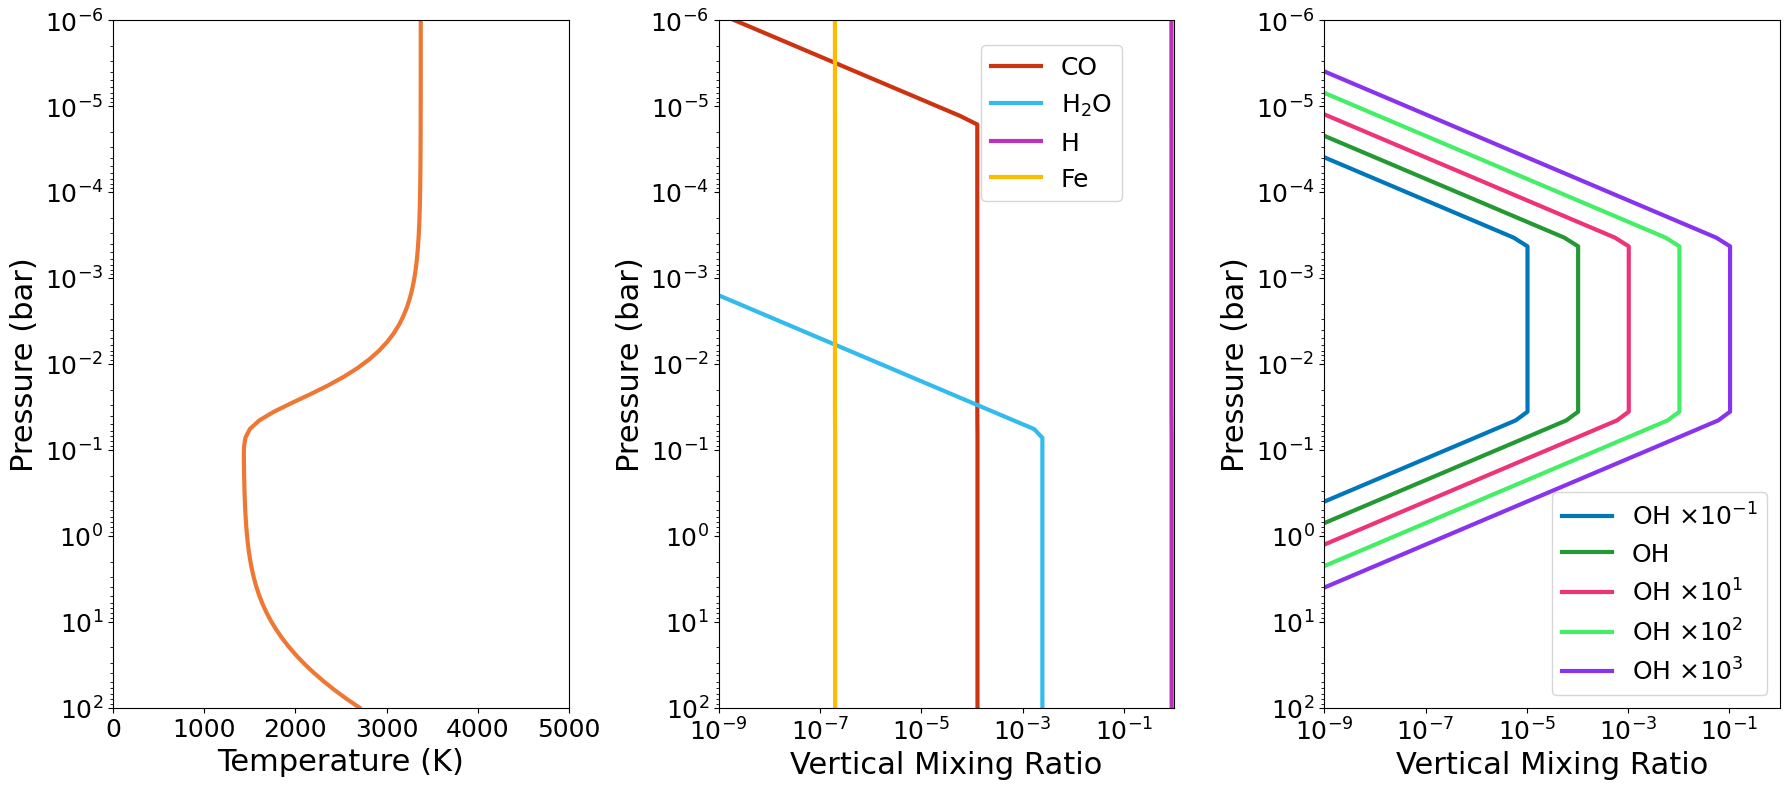

In [34]:
# from matplotlib import ticker

line_width = 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

ax2.plot(co_vmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
ax2.plot(h2o_vmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
ax2.plot(h_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
# ax2.plot(he_vmr, central_pressure, label="He", color="#44EE66", linewidth=line_width)
ax2.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)
# plt.plot(o_vmr, central_pressure, label="O", color="#000000", linewidth=line_width)

ax2.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
ax2.set_xscale("log")
ax2.set_xlim(left=1e-9, right=1)
ax2.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax2.set_yscale("log")
ax2.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax2.invert_yaxis()
ax2.tick_params(labelsize=tick_fontsize)
# plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax2.legend(loc="center", bbox_to_anchor=(0.73, 0.85), fontsize=tick_fontsize)

# plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_vmr.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.show()

# plt.figure(figsize=(6, 8))

ax3.plot(oh_vmr * 1e-1, central_pressure, label=r"OH $\times10^{-1}$", color="#0077BB", linewidth=line_width)
ax3.plot(oh_vmr, central_pressure, label="OH", color="#229933", linewidth=line_width)
ax3.plot(oh_vmr * 1e1, central_pressure, label=r"OH $\times10^{1}$", color="#EE3377", linewidth=line_width)
ax3.plot(oh_vmr * 1e2, central_pressure, label=r"OH $\times10^{2}$", color="#44EE66", linewidth=line_width)
ax3.plot(oh_vmr * 1e3, central_pressure, label=r"OH $\times10^{3}$", color="#8833EE", linewidth=line_width)

# ax3.hlines(central_pressure[49:51].value.mean(), xmin=1e-9, xmax=1, linestyle="--", color="#808080", linewidth=line_width, label="Boundary 1")
# ax3.hlines(central_pressure[39:41].value.mean(), xmin=1e-9, xmax=1, linestyle="-.", color="#808080", linewidth=line_width, label="Boundary 2")
# ax3.hlines(central_pressure[29:31].value.mean(), xmin=1e-9, xmax=1, linestyle=":", color="#808080", linewidth=line_width, label="Boundary 3")
# ax3.text(2e-2, 5e-5, "Non-LTE", fontsize=tick_fontsize, ha="center", va="center")
# ax3.text(2e-2, 1e0, "LTE", fontsize=tick_fontsize, ha="center", va="center")

ax3.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
ax3.set_xscale("log")
ax3.set_xlim(left=1e-9, right=1)
ax3.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax3.set_yscale("log")
ax3.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax3.invert_yaxis()
ax3.tick_params(labelsize=tick_fontsize)
ax3.legend(loc="best", fontsize=tick_fontsize)

# plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_oh_vmr.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.show()

# plt.figure(figsize=(6, 8))

ax1.plot(temperature_profile, central_pressure, label="Median", color="#EE7733", linewidth=line_width)
# plt.plot(temperature_profile_maxl, central_pressure, label="Maximum\nLikelihood", color="#8833EE", linewidth=line_width)

ax1.set_xlabel("Temperature (K)", fontsize=label_fontsize)
ax1.set_xlim(left=0, right=5000)
ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax1.set_yscale("log")
ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax1.invert_yaxis()
ax1.tick_params(labelsize=tick_fontsize)
# plt.legend(loc="best", fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/Figures/KELT-20b_profiles.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

log10 planet [O/H] = -2.1699999999999995
Total Oxygen abundance from [O/H] = 0.005948425773301803
Total Oxygen abundance from lower atmosphere H2O + CO = 0.002596550476152443
log10 planet O/H from H2O+CO abundances = -2.530005277099324
Retrieved [O/H] from H2O+CO = 0.7399947229006756
Alternative solar abundance = 8.369994722900676


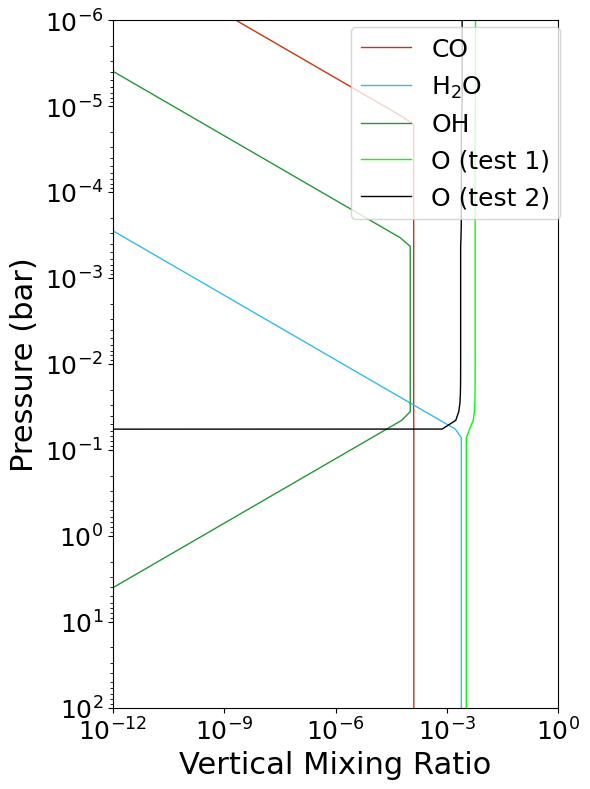

In [61]:
line_width = 3
plt.figure(figsize=(6, 8))

log_solar_O_H = 8.73 - 12
retrieved_O_H = 1.1
log_planet_O_H = retrieved_O_H + log_solar_O_H
print(f"log10 planet [O/H] = {log_planet_O_H}")
total_oxygen_abundance1 = h_vmr[0] * 10**log_planet_O_H
print(f"Total Oxygen abundance from [O/H] = {total_oxygen_abundance1}")

# baseline_oxygen = np.repeat(1e-12, len(oh_vmr))
# baseline_oxygen = 1e-12
# total_available_oxygen = baseline_oxygen + max(oh_vmr) + max(co_vmr) + max(h2o_vmr)
# # print(total_available_oxygen)
oxygen_vmr1 = np.repeat(total_oxygen_abundance1, len(oh_vmr)) - co_vmr - h2o_vmr

total_oxygen_abundance2 = co_vmr[0] + h2o_vmr[0]
print(f"Total Oxygen abundance from lower atmosphere H2O + CO = {total_oxygen_abundance2}")
test_log_planet_O_H = np.log10(total_oxygen_abundance2 / h_vmr[0])
print(f"log10 planet O/H from H2O+CO abundances = {test_log_planet_O_H}")
test_retrieved_O_H = test_log_planet_O_H - log_solar_O_H
print(f"Retrieved [O/H] from H2O+CO = {test_retrieved_O_H}")
print(f"Alternative solar abundance = {test_log_planet_O_H - retrieved_O_H + 12}")

oxygen_vmr2 = np.repeat(total_oxygen_abundance2, len(oh_vmr)) - oh_vmr - co_vmr - h2o_vmr

plt.plot(co_vmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
plt.plot(h2o_vmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
plt.plot(oh_vmr, central_pressure, label="OH", color="#229933", linewidth=line_width)
plt.plot(oxygen_vmr1, central_pressure, label="O (test 1)", color="#00FF00", linewidth=line_width)
plt.plot(oxygen_vmr2, central_pressure, label="O (test 2)", color="#000000", linewidth=line_width)
# plt.plot(hydrogen_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
# plt.plot(he_vmr, central_pressure, label="He", color="#44EE66", linewidth=line_width)
# plt.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)

plt.xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
plt.xscale("log")
plt.xlim(left=1e-12, right=1)
plt.ylabel("Pressure (bar)", fontsize=label_fontsize)
plt.yscale("log")
plt.ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=tick_fontsize)
# plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.legend(loc="center", bbox_to_anchor=(0.77, 0.85), fontsize=tick_fontsize)

plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_vmr.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
line_width = 3
plt.figure(figsize=(6, 8))

# log_solar_O_H = 8.69 - 12
# retrieved_O_H = 1.1
# log_planet_O_H = retrieved_O_H + log_solar_O_H
# total_oxygen_abundance = hydrogen_vmr[0] * 10**log_planet_O_H
# print(total_oxygen_abundance)
# oxygen_vmr = np.repeat(total_oxygen_abundance, len(oh_vmr)) - oh_vmr - co_vmr - h2o_vmr

plt.plot(co_mmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
plt.plot(h2o_mmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
plt.plot(oh_mmr, central_pressure, label="OH", color="#229933", linewidth=line_width)
# plt.plot(o_vmr, central_pressure, label="O", color="#000000", linewidth=line_width)
# plt.plot(hydrogen_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
# plt.plot(he_vmr, central_pressure, label="He", color="#44EE66", linewidth=line_width)
# plt.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)

plt.xlabel("Mass Mixing Ratio", fontsize=label_fontsize)
plt.xscale("log")
plt.xlim(left=1e-12, right=1)
plt.ylabel("Pressure (bar)", fontsize=label_fontsize)
plt.yscale("log")
plt.ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=tick_fontsize)
# plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.legend(loc="center", bbox_to_anchor=(0.77, 0.85), fontsize=tick_fontsize)

plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_vmr.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [3]:
# Boundary layer 50
# x1000OH_bL50_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL50/outputs/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# x100OH_bL50_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL50/outputs/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# x10OH_bL50_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL50/outputs/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# # x10OH_bL50_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL50/outputs_old_no_colboltz/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# x1OH_bL50_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL50/outputs/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# # x1OH_bL50_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL50/outputs_old_no_colboltz/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# x01OH_bL50_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL50/outputs/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# # x01OH_bL50_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL50/outputs_old_no_colboltz/KELT-20b_cont_boundaryL50_pop_matrix.pickle", "rb"))
# # Boundary layer 45
# # x10OH_bL45_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL45/outputs/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # x10OH_bL45_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL45/outputs_old_no_colboltz/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # x1OH_bL45_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL45/outputs/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # x1OH_bL45_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL45/outputs_old_no_SOR/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # x01OH_bL45_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL45/outputs/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # x01OH_bL45_pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL45/outputs_old_no_SOR/KELT-20b_cont_boundaryL45_pop_matrix.pickle", "rb"))
# # Boundary layer 40
# x1000OH_bL40_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL40/outputs/KELT-20b_cont_boundaryL40_pop_matrix.pickle", "rb"))
# x100OH_bL40_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL40/outputs/KELT-20b_cont_boundaryL40_pop_matrix.pickle", "rb"))
# x10OH_bL40_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL40/outputs/KELT-20b_cont_boundaryL40_pop_matrix.pickle", "rb"))
# x1OH_bL40_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL40/outputs/KELT-20b_cont_boundaryL40_pop_matrix.pickle", "rb"))
# x01OH_bL40_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL40/outputs/KELT-20b_cont_boundaryL40_pop_matrix.pickle", "rb"))
# # Boundary layer 30
# x1000OH_bL30_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL30/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))
# x100OH_bL30_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL30/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))
# x10OH_bL30_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL30/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))
# x1OH_bL30_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL30/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))
# x01OH_bL30_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL30/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))

# x1OH_bL30_col_rate_test1_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL30_col_rate_test/outputs/KELT-20b_cont_boundaryL30_pop_matrix.pickle", "rb"))
# Boundary layer 20
x1000OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x100OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x10OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x01OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))


# x1OH_bL20_col_rate_test1_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20_col_rate_test1/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
# x1OH_bL20_col_rate_test2_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20_col_rate_test2/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
# x1OH_bL20_col_rate_test3_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20_col_rate_test3/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
# x1OH_bL20_col_rate_test4_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20_col_rate_test4/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
# x1OH_bL20_col_rate_test5_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20_col_rate_test5/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))

In [12]:
# Test Rate 2
# add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 5.8e-10, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 1.5e-09, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 4.0e-09, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 9.8e-09, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 2.4e-08, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 7.6e-08, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 1.8e-07, "H")  # @ 300 K single-quantum extrapolation
# add_col_chem_rate("X2Pi", 10, "X2Pi", 9, 5.1e-07, "H")  # @ 300 K single-quantum extrapolation

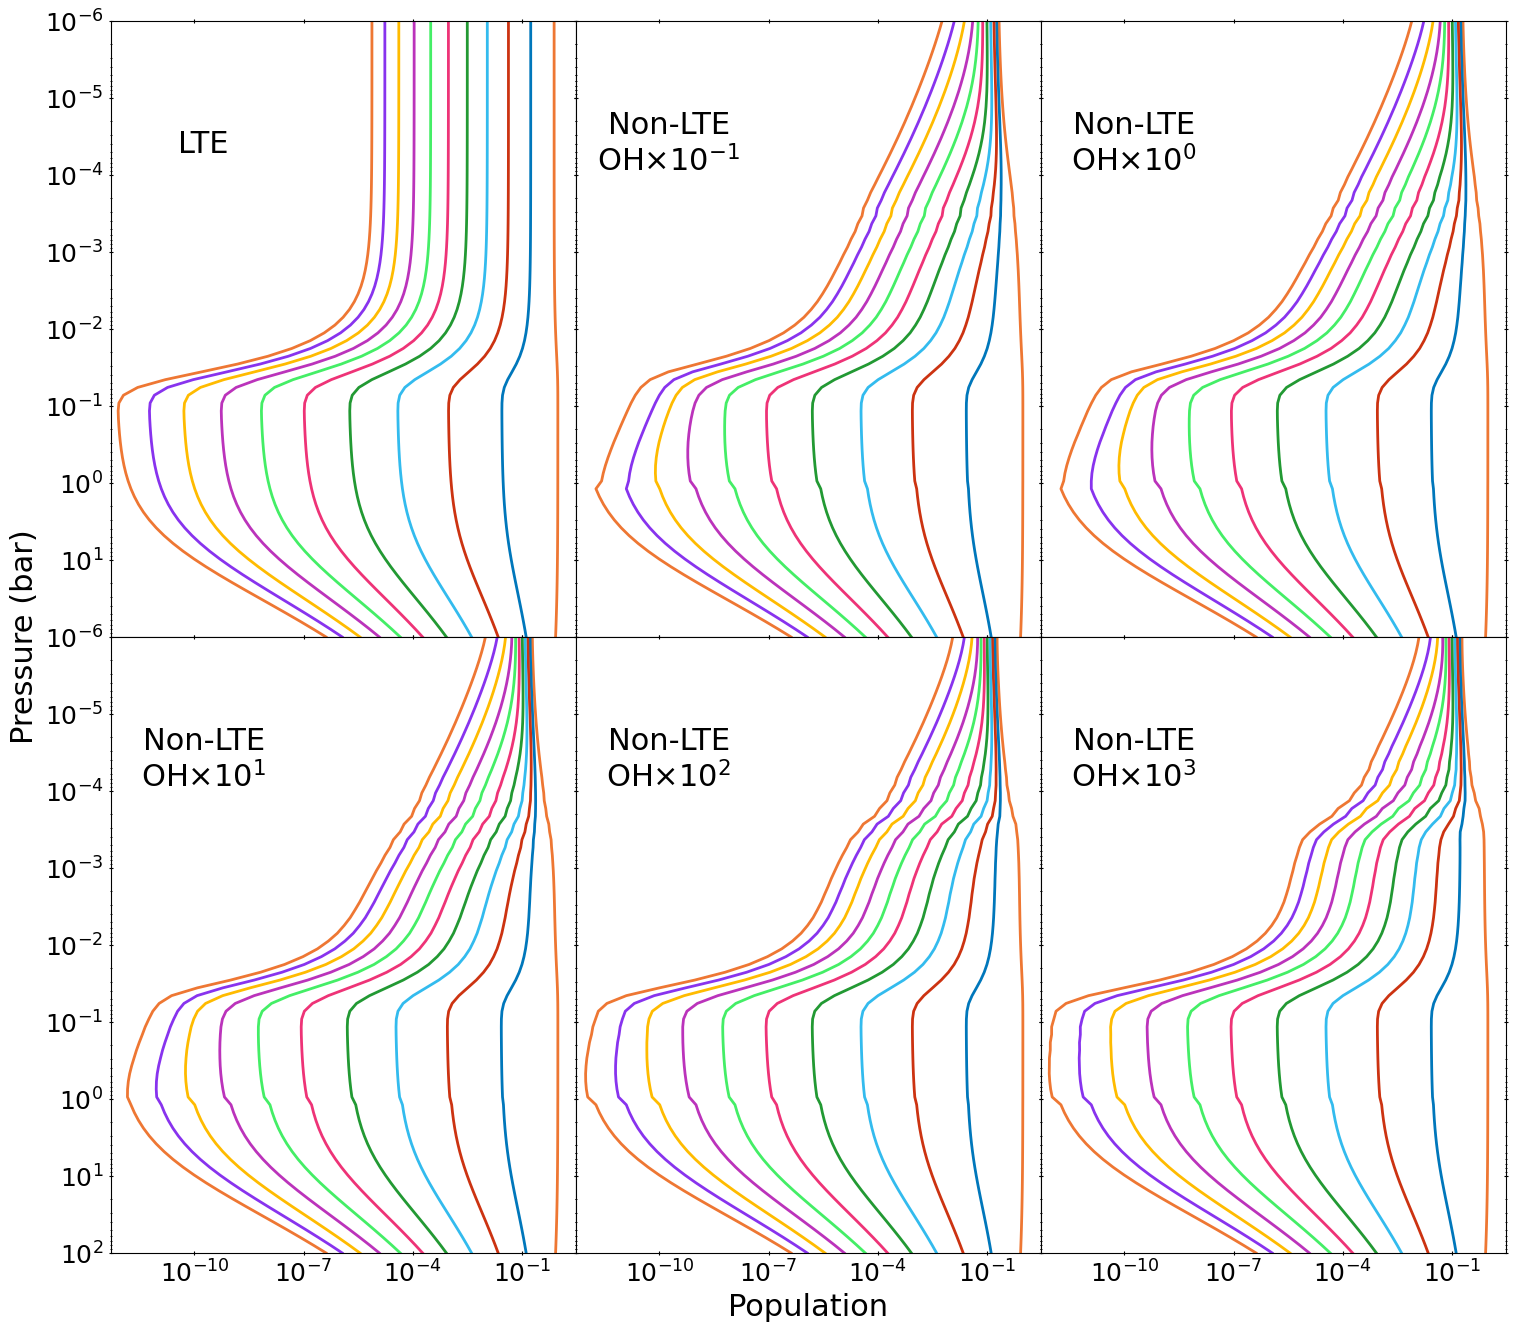

In [4]:
line_width = 2
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 16))

max_v = 10
plot_colors = get_vibrant_colors(max_v + 1)

# for v_val in range(0, max_v + 1):
#     ax1.plot(x1OH_bL20_pop_matrix[0, :, v_val], central_pressure, color=plot_colors[v_val], linewidth=line_width, linestyle="-", label="LTE")
#     ax1.set_xscale("log")
#     ax1.set_yscale("log")
#     ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
#     ax1.invert_yaxis()
#     ax1.tick_params(labelsize=tick_fontsize)
#     ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)

nlte_axs = [ax1, ax2, ax3, ax4, ax5, ax6]
plot_pops = [x1OH_bL20_pop_matrix, x01OH_bL20_pop_matrix, x1OH_bL20_pop_matrix, x10OH_bL20_pop_matrix, x100OH_bL20_pop_matrix, x1000OH_bL20_pop_matrix]
plot_labels = ["LTE", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$"]

for ax_idx, plot_ax in enumerate(nlte_axs):
    plot_pop = plot_pops[ax_idx]
    plot_iter = 0 if ax_idx == 0 else -1
    for v_val in range(0, max_v + 1):
        plot_ax.plot(plot_pop[plot_iter, :, v_val], central_pressure, label=f"v={v_val}", color=plot_colors[v_val], linewidth=line_width, linestyle="-")
        # plot_ax.plot(plot_pop[0, :, v_val], central_pressure, color=plot_colors[v_val] + "44", linewidth=line_width/2, linestyle="-", label="LTE")
    plot_ax.set_xscale("log")
    plot_ax.set_xlim(left=5e-13, right=3e0)
    plot_ax.set_yscale("log")
    plot_ax.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
    plot_ax.invert_yaxis()
    plot_ax.tick_params(which="both", labelsize=tick_fontsize, direction="inout", bottom=True, top=True, left=True, right=True)
    if ax_idx == 0:
        plot_ax.text(0.2, 0.8, "LTE", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )
    else:
        plot_ax.text(0.2, 0.8, f"Non-LTE\nOH$\\times10^{{{int(ax_idx - 2)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )

    if ax_idx <=2:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False)
    elif ax_idx == 4:
        plot_ax.set_xlabel("Population", fontsize=label_fontsize)

    if ax_idx % 3 != 0:
        plot_ax.tick_params(axis="y", which="both", labelleft=False)
    elif ax_idx == 0:
        y_ticks = plot_ax.get_yticks()
        y_ticks = y_ticks[1:-2]
        plot_ax.set_yticks(y_ticks)
        plot_ax.set_ylabel("Pressure (bar)", fontsize=label_fontsize, y=central_pressure[-1].value)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_populations.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

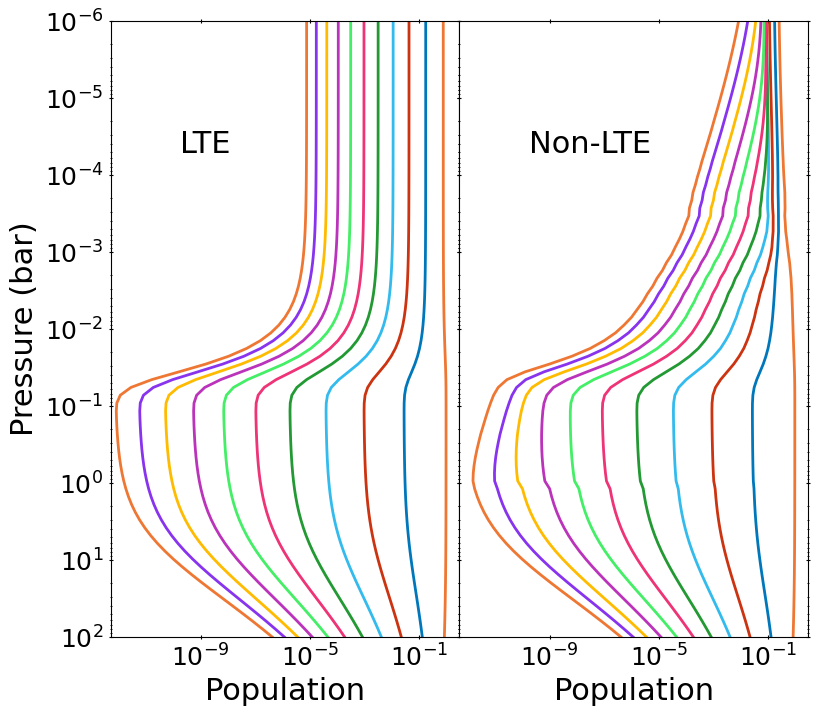

(4, 80)


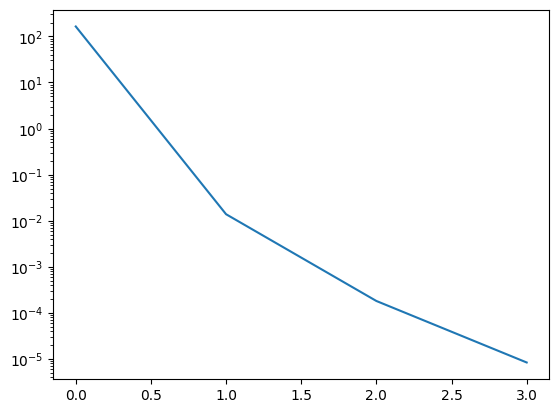

In [8]:
# pop_dif = abs(x10OH_bL50_pop_matrix[1:, :, :11] - x10OH_bL50_pop_matrix[:-1, :, :11]) / x10OH_bL50_pop_matrix[:-1, :, :11]
pop_dif = abs(x01OH_bL20_pop_matrix[1:, :, :11] - x01OH_bL20_pop_matrix[:-1, :, :11]) / x01OH_bL20_pop_matrix[:-1, :, :11]
# true_dif = abs(x10OH_bL50_pop_matrix[1:, :, :11] - x10OH_bL50_pop_matrix[-1, :, :11]) / x10OH_bL50_pop_matrix[-1, :, :11]
pop_dif_max = pop_dif.max(axis=2)
print(pop_dif_max.shape)

# plt.plot(np.arange(pop_dif.shape[0]), pop_dif[:, -1, 0])
plt.plot(np.arange(pop_dif_max.shape[0]), pop_dif_max[:, 70])
# plt.plot(np.arange(true_dif.shape[0]), true_dif[:, 50])
plt.yscale("log")
plt.show()

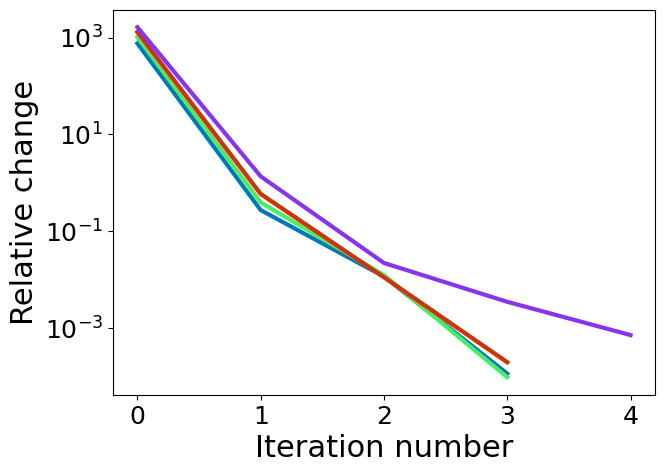

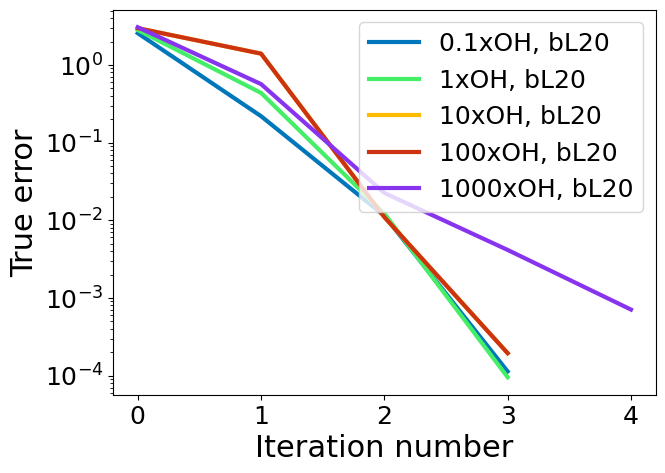

In [5]:
def convergence(matrix: npt.NDArray[np.float64], relative: bool = False) -> npt.NDArray[np.float64]:
    if relative:
        return (abs(matrix[1:, :, :11] - matrix[:-1, :, :11]) / matrix[:-1, :, :11]).max(axis=(1, 2))
    else:
        return (abs(matrix[:-1, :, :11] - matrix[-1, :, :11]) / matrix[-1, :, :11]).max(axis=(1, 2))

# Boundary layer 50
# pop_dif_1000xOH_bl50 = convergence(x1000OH_bL50_pop_matrix, True)
# true_dif_1000xOH_bl50 = convergence(x1000OH_bL50_pop_matrix, False)
# pop_dif_100xOH_bl50 = convergence(x10OH_bL50_pop_matrix, True)
# true_dif_100xOH_bl50 = convergence(x10OH_bL50_pop_matrix)
# pop_dif_10xOH_bl50 = convergence(x10OH_bL50_pop_matrix, True)
# true_dif_10xOH_bl50 = convergence(x10OH_bL50_pop_matrix)
# pop_dif_1xOH_bl50 = convergence(x1OH_bL50_pop_matrix, True)
# true_dif_1xOH_bl50 = convergence(x1OH_bL50_pop_matrix)
# pop_dif_01xOH_bl50 = convergence(x01OH_bL50_pop_matrix, True)
# true_dif_01xOH_bl50 = convergence(x01OH_bL50_pop_matrix)
# # Boundary layer 40
# pop_dif_1000xOH_bl40 = convergence(x1000OH_bL40_pop_matrix, True)
# true_dif_1000xOH_bl40 = convergence(x1000OH_bL40_pop_matrix, False)
# pop_dif_100xOH_bl40 = convergence(x10OH_bL40_pop_matrix, True)
# true_dif_100xOH_bl40 = convergence(x10OH_bL40_pop_matrix)
# pop_dif_10xOH_bl40 = convergence(x10OH_bL40_pop_matrix, True)
# true_dif_10xOH_bl40 = convergence(x10OH_bL40_pop_matrix)
# pop_dif_1xOH_bl40 = convergence(x1OH_bL40_pop_matrix, True)
# true_dif_1xOH_bl40 = convergence(x1OH_bL40_pop_matrix)
# pop_dif_01xOH_bl40 = convergence(x01OH_bL40_pop_matrix, True)
# true_dif_01xOH_bl40 = convergence(x01OH_bL40_pop_matrix)
# # Boundary layer 30
# pop_dif_1000xOH_bl30 = convergence(x1000OH_bL30_pop_matrix, True)
# true_dif_1000xOH_bl30 = convergence(x1000OH_bL30_pop_matrix, False)
# pop_dif_100xOH_bl30 = convergence(x10OH_bL30_pop_matrix, True)
# true_dif_100xOH_bl30 = convergence(x10OH_bL30_pop_matrix)
# pop_dif_10xOH_bl30 = convergence(x10OH_bL30_pop_matrix, True)
# true_dif_10xOH_bl30 = convergence(x10OH_bL30_pop_matrix)
# pop_dif_1xOH_bl30 = convergence(x1OH_bL30_pop_matrix, True)
# true_dif_1xOH_bl30 = convergence(x1OH_bL30_pop_matrix)
# pop_dif_01xOH_bl30 = convergence(x01OH_bL30_pop_matrix, True)
# true_dif_01xOH_bl30 = convergence(x01OH_bL30_pop_matrix)
# Boundary layer 20
pop_dif_1000xOH_bl20 = convergence(x1000OH_bL20_pop_matrix, True)
true_dif_1000xOH_bl20 = convergence(x1000OH_bL20_pop_matrix, False)
pop_dif_100xOH_bl20 = convergence(x10OH_bL20_pop_matrix, True)
true_dif_100xOH_bl20 = convergence(x10OH_bL20_pop_matrix)
pop_dif_10xOH_bl20 = convergence(x10OH_bL20_pop_matrix, True)
true_dif_10xOH_bl20 = convergence(x10OH_bL20_pop_matrix)
pop_dif_1xOH_bl20 = convergence(x1OH_bL20_pop_matrix, True)
true_dif_1xOH_bl20 = convergence(x1OH_bL20_pop_matrix)
pop_dif_01xOH_bl20 = convergence(x01OH_bL20_pop_matrix, True)
true_dif_01xOH_bl20 = convergence(x01OH_bL20_pop_matrix)

line_width = 3

plt.figure(figsize=(7, 5), dpi=100)

plot_dict ={
    20: {
        "rel": [pop_dif_01xOH_bl20, pop_dif_1xOH_bl20, pop_dif_10xOH_bl20, pop_dif_100xOH_bl20, pop_dif_1000xOH_bl20],
        "true": [true_dif_01xOH_bl20, true_dif_1xOH_bl20, true_dif_10xOH_bl20, true_dif_100xOH_bl20, true_dif_1000xOH_bl20],
    },
    # 30: {
    #     "rel": [pop_dif_01xOH_bl30, pop_dif_1xOH_bl30, pop_dif_10xOH_bl30, pop_dif_100xOH_bl30, pop_dif_1000xOH_bl30],
    #     "true": [true_dif_01xOH_bl30, true_dif_1xOH_bl30, true_dif_10xOH_bl30, true_dif_100xOH_bl30, true_dif_1000xOH_bl30],
    # },
    # 40: {
    #     "rel": [pop_dif_01xOH_bl40, pop_dif_1xOH_bl40, pop_dif_10xOH_bl40, pop_dif_100xOH_bl40, pop_dif_1000xOH_bl40],
    #     "true": [true_dif_01xOH_bl40, true_dif_1xOH_bl40, true_dif_10xOH_bl40, true_dif_100xOH_bl40, true_dif_1000xOH_bl40],
    # },
    # 50: {
    #     "rel": [pop_dif_01xOH_bl50, pop_dif_1xOH_bl50, pop_dif_10xOH_bl50, pop_dif_100xOH_bl50, pop_dif_1000xOH_bl50],
    #     "true": [true_dif_01xOH_bl50, true_dif_1xOH_bl50, true_dif_10xOH_bl50, true_dif_100xOH_bl50, true_dif_1000xOH_bl50],
    # },
}
plot_bl = 20
plot_colors = get_vibrant_colors(n_colors=max([len(arr) for arr in plot_dict[plot_bl].values()]), ordered=True)
for idx in range(len(plot_dict[plot_bl]["rel"])):
    plt.plot(np.arange(plot_dict[plot_bl]["rel"][idx].shape[0]), plot_dict[plot_bl]["rel"][idx], label=f"{10**(idx-1)}xOH, bL{plot_bl}",
             color=plot_colors[idx], linewidth=line_width, linestyle="-")
plt.yscale("log")
plt.xlabel("Iteration number", fontsize=label_fontsize)
plt.ylabel("Relative change", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.show()

plt.figure(figsize=(7, 5), dpi=100)
for idx in range(len(plot_dict[plot_bl]["true"])):
    plt.plot(np.arange(plot_dict[plot_bl]["true"][idx].shape[0]), plot_dict[plot_bl]["true"][idx], label=f"{10**(idx-1)}xOH, bL{plot_bl}",
             color=plot_colors[idx], linewidth=line_width, linestyle="-")
plt.yscale("log")
plt.xlabel("Iteration number", fontsize=label_fontsize)
plt.ylabel("True error", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="best", fontsize=tick_fontsize)
plt.show()

# Transmission

In [3]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
def load_transmission(bl: int, oh_scale: float, highres: bool = False) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    if highres:
        return (np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs_new3/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt"),
                np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}_highres.txt"))
    else:
        return (np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs_new2/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission.txt"),
                np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}.txt"))
        # return (np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs_new/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission.txt"),
        #         np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission.txt"),
        #         np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}.txt"))


# bl20_01xOH = load_transmission(20, 0.1, highres=True)
bl20_1xOH = load_transmission(20, 1, highres=True)
# bl20_10xOH = load_transmission(20, 10, highres=True)
# bl20_100xOH = load_transmission(20, 100, highres=True)
# bl20_1000xOH = load_transmission(20, 1000, highres=True)

OHx1 radiance scale NLTE/LTE = 1.4155263734613408


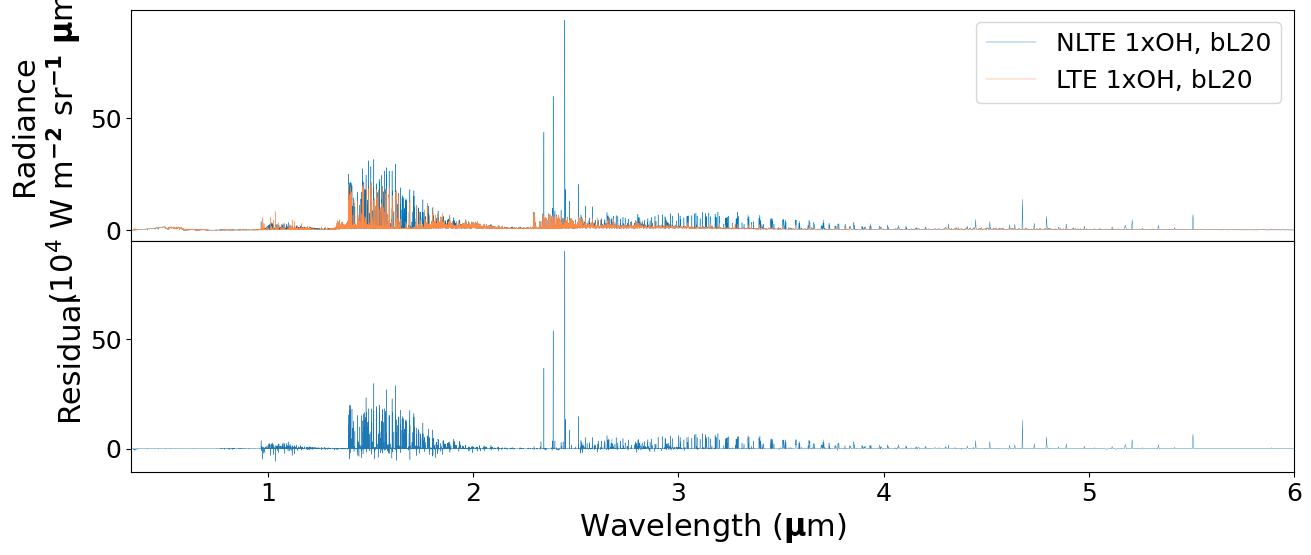

In [7]:
x_label = r"Wavelength ($\mathbf{\mu}$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e4
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^\mathbf{-2}$ sr$^\mathbf{-1}$ $\mathbf{\mu}$m$^\mathbf{-1}$)"
line_width = 0.3
# line_width = 1.0

figure_size = (15, 6)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size)

plot_bl = 20
# plot_abundances = [0.1, 1, 10, 100, 1000]
plot_abundances = [1]
plot_colors = get_vibrant_colors(n_colors=len(plot_abundances), ordered=True)
for plot_idx, plot_abund in enumerate(plot_abundances):
    nlte_transmission, lte_transmission = load_transmission(20, plot_abund)
    # nlte_radiance_new = (
    #     nlte_transmission_new[:, 1]
    #     * (u.J * u.m**-2)
    #     * (ac.c / (4 * np.pi * u.sr * (nlte_transmission_new[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    # ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    # nlte_wavelength_new = (nlte_transmission_new[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    # ax1.plot(nlte_wavelength_new, nlte_radiance_new / radiance_scale_factor, zorder=2, color="#FF0000",
    #          label=f"NLTE NEW{plot_abund}xOH, bL{plot_bl}", linewidth=line_width)

    nlte_radiance = (
        nlte_transmission[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (nlte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (nlte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    ax1.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx, color=plot_colors[plot_idx],
             label=f"NLTE {plot_abund}xOH, bL{plot_bl}", linewidth=line_width)
    lte_radiance = (
        lte_transmission[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (lte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (lte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    ax1.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx, color=invert_hex(plot_colors[plot_idx]),
             label=f"LTE {plot_abund}xOH, bL{plot_bl}", linewidth=line_width)

    # ax2.plot(lte_wavelength, (nlte_radiance_new - nlte_radiance) / radiance_scale_factor, linewidth=line_width)
    ax2.plot(lte_wavelength, (nlte_radiance - lte_radiance) / radiance_scale_factor, linewidth=line_width)
    print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")

# print(np.any(nlte_radiance_new > nlte_radiance))

x_min = 1e4 / 30000
x_max = 6
# x_min = 2
# x_max = 3
# plt.xlim(left=wl_min, right=wl_max)
ax1.set_xlim(left=x_min, right=x_max)
ax2.set_xlim(ax1.get_xlim())
# ax1.set_ylim(bottom=0)
# ax1.set_yscale("log")
# ax2.set_yscale("log")
ax1.tick_params(axis="x", which="both", labelbottom=False, labelsize=tick_fontsize)
ax1.tick_params(axis="both", which="both", labelsize=tick_fontsize)
ax2.tick_params(axis="both", which="both", labelsize=tick_fontsize)
ax2.set_xlabel(x_label, fontsize=label_fontsize)
ax1.set_ylabel(y_label, fontsize=label_fontsize)
ax2.set_ylabel("Residual", fontsize=label_fontsize)
ax1.legend(loc="upper right", fontsize=tick_fontsize)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.show()

OHx0.1 radiance scale NLTE/LTE = 1.0056480472149905
OHx1 radiance scale NLTE/LTE = 1.037449403251489
OHx10 radiance scale NLTE/LTE = 1.0885316531218276
OHx100 radiance scale NLTE/LTE = 1.0251809650845545
OHx1000 radiance scale NLTE/LTE = 0.8078053583529606


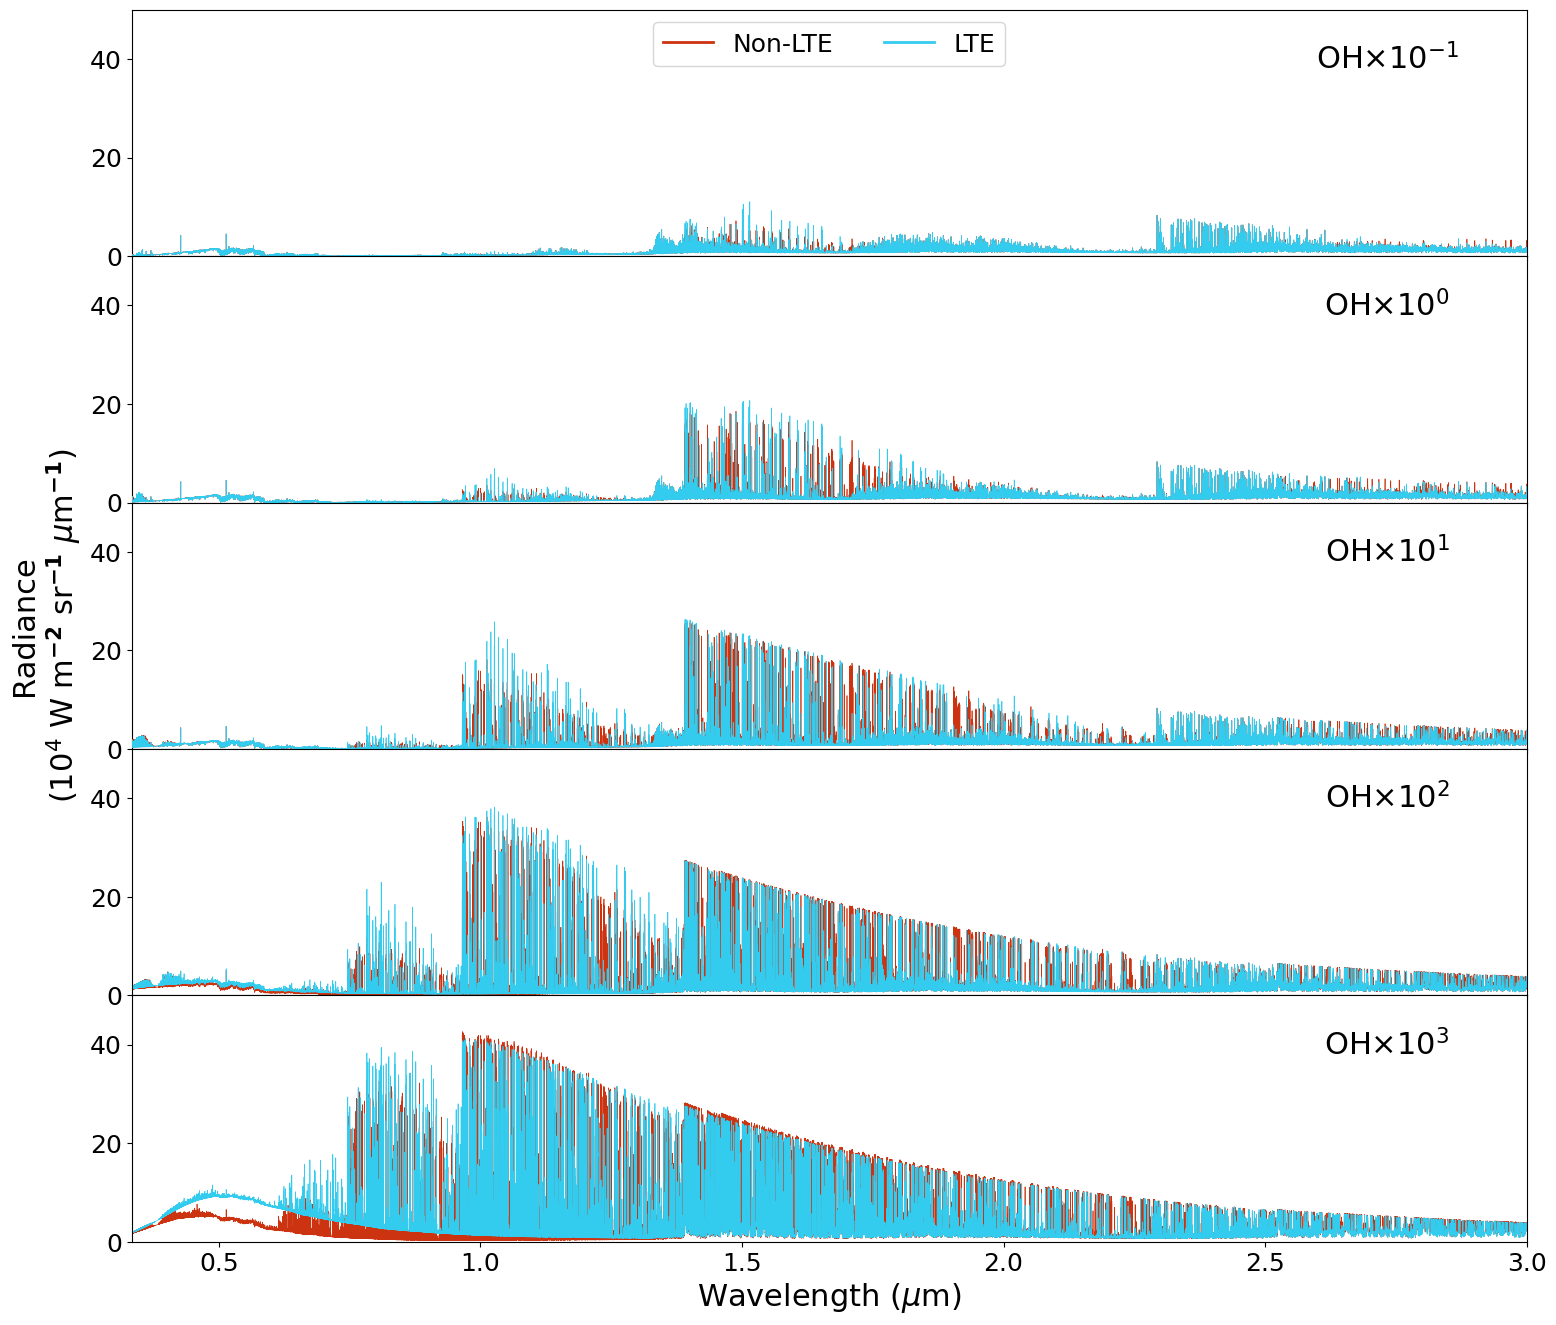

In [80]:
from matplotlib.legend_handler import HandlerLine2D


x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e4
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^\mathbf{-2}$ sr$^\mathbf{-1}$ $\mu$m$^\mathbf{-1}$)"
line_width = 0.5  # 0.3

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(18, 16))

plot_bl = 20
x_min = 1e4 / 30000
x_max = 3
plot_abundances = [0.1, 1, 10, 100, 1000]
plot_axs = [ax1, ax2, ax3, ax4, ax5]
high_res = [True, True, True, True, True]
nlte_color = "#CC3311"
lte_color = invert_hex(nlte_color)
for plot_idx, plot_ax in enumerate(plot_axs):
    plot_abund = plot_abundances[plot_idx]
    nlte_transmission, lte_transmission = load_transmission(20, plot_abund, highres=high_res[plot_idx])
    nlte_radiance = (
        nlte_transmission[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (nlte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (nlte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx,
                             color=nlte_color, label=f"Non-LTE", linewidth=line_width)
    lte_radiance = (
        lte_transmission[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (lte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (lte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx,
                            color=lte_color, label=f"LTE", linewidth=line_width)

    plot_ax.text(0.9, 0.8, f"OH$\\times10^{{{int(plot_idx - 1)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                 # fontweight="bold"
                 )

    print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")
    if plot_idx != 4:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False, labelsize=tick_fontsize)
    else:
        plot_ax.set_xlabel(x_label, fontsize=label_fontsize)
    plot_ax.tick_params(axis="both", which="both", labelsize=tick_fontsize)
    plot_ax.set_xlim(left=x_min, right=x_max)
    plot_ax.set_ylim(bottom=0, top=50)
    if plot_idx == 2:
        plot_ax.set_ylabel(y_label, fontsize=label_fontsize)
    if plot_idx == 0:
        legend = plot_ax.legend(loc="upper center", fontsize=tick_fontsize, ncol=2)
        plt.setp(legend.get_lines(), linewidth=2)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

4190.372323603998
[ 0.33361037  0.33416519  0.3347217  ... 48.17507233 61.32267592
 84.72633536] [602.10929826 601.46963241 600.4708403  ...   4.8006007    3.77138469
   2.77360861]


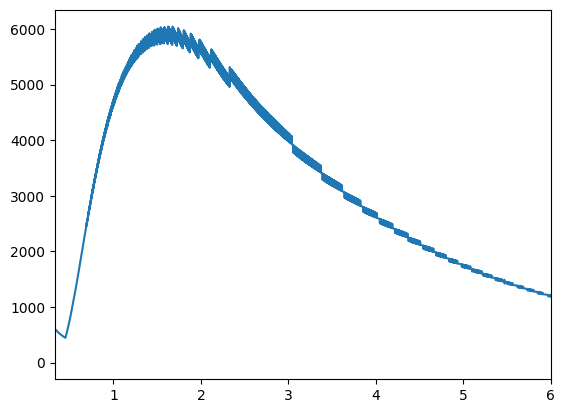

In [60]:
wl_bins = lte_wavelength.value[::-1]
wl_centers = (wl_bins[:-1] + wl_bins[1:]) / 2
# wl_centers
resolution = wl_centers / np.diff(wl_bins)
print(resolution.mean())
print(wl_centers, resolution)
plt.plot(wl_centers, resolution)
plt.xlim(left=0.33, right=6)
plt.show()

# Photodissociation rates

In [28]:
ac_2_h_on_c_sq = 2 * ac.h / ac.c**2
ac_h_on_kB = ac.h / ac.k_B

planet_mass = 3.372 << u.Mjup
planet_radius = 1.83 << u.Rjup
star_temperature = 8730 << u.K
orbital_radius = 0.057 << u.AU


def blackbody(spectral_grid: u.Quantity, temperature: u.Quantity) -> u.Quantity:
    # freq_grid = spectral_grid.to(u.Hz, equivalencies=u.spectral())
    temperature = np.atleast_1d(temperature)[:, None]
    wl_grid = spectral_grid.to(u.um, equivalencies=u.spectral())
    # return (ac_2_h_on_c_sq * freq_grid**3) / (np.exp(ac_h_on_kB * freq_grid / temperature) - 1) / u.sr
    return (
            ((2 * ac.h * ac.c ** 2) / (wl_grid ** 5))
            * (1 / (np.exp((ac.h * ac.c) / (wl_grid * ac.k_B * temperature)) - 1))
            / u.sr
    )

def incident_stellar_radiation(
    wn_grid: u.Quantity, star_temperature: u.Quantity, orbital_radius: u.Quantity, planet_radius: u.Quantity
) -> u.Quantity:
    """
    Assume the angular size of the planet relative to the star and orbital distance is small, allowing to assume that
    the surface of the planet with incident radiation is approximately a circle.

    :param wn_grid:
    :param star_temperature:
    :param orbital_radius:
    :param planet_radius:
    :return:
    """
    star_bb = blackbody(spectral_grid=wn_grid, temperature=star_temperature)[0]
    incident_radiation = star_bb * (planet_radius / orbital_radius) ** 2
    return incident_radiation.to(star_bb.unit, equivalencies=u.spectral())


def xsec_to_rate(xsec: npt.NDArray[np.float64], temp_star: u.Quantity = star_temperature) -> u.Quantity:
    if temp_star is not u.Quantity:
        temp_star = temp_star << u.K
    wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    incident_radiation_field = incident_stellar_radiation(
        wn_grid=xsec[:, 0] * u.k, star_temperature=temp_star,
        orbital_radius=orbital_radius, planet_radius=planet_radius
    )
    # incident_radiation_field = np.ones(incident_radiation_field.shape[0]) << incident_radiation_field.unit
    incident_radiation_field = incident_radiation_field.to(u.J / (u.s * u.sr * u.cm**2 * u.um), equivalencies=u.spectral())
    incident_radiation_field *= 4 * np.pi * u.sr
    incident_radiation_field = incident_radiation_field / (ac.h * ac.c / wl_grid)
    incident_radiation_field = incident_radiation_field.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
    product = incident_radiation_field * (xsec[:, 1] * u.cm**2)
    rate = simpson(product[::-1], x=wl_grid.value[::-1])
    return rate

Ratio = 0.8181092282958556
Ratio = 0.8191389261150366
Ratio = 0.821661763299065
Ratio = 0.8246699623707683
Ratio = 0.8282573038614914
Ratio = 0.8332413363568829
Ratio = 0.8388461187096028
Ratio = 0.8467933098540805
Ratio = 0.8567419464337683
Ratio = 0.8687407601146793
Ratio = 0.8821569350638137
Ratio = 0.8926165438138
Ratio = 0.87935311352259
Ratio = 0.866576502594734
Ratio = 0.8480013499927572
Ratio = 0.8667393258759418
Ratio = 0.8679309521709534
Ratio = 0.9100182568826243
Ratio = 0.9300028358376922
Ratio = 0.9991217437948928
Ratio = 1.0504459575557068
Ratio = 1.163177012972231
Ratio = 1.2735360016424628
Ratio = 1.4628405981854091
Ratio = 1.685022284220905
Ratio = 2.01313044868803
Ratio = 2.4435324150408637
Ratio = 3.0099537663947618
Ratio = 3.811588238021793
Ratio = 4.762443977652497
Ratio = 6.177183510106841
Ratio = 7.655834594077895
Ratio = 9.95978077895938
Ratio = 11.902578955422548
Ratio = 16.000924513035553
Ratio = 17.612082648556296
Ratio = 22.841930979872785
Ratio = 24.9922563

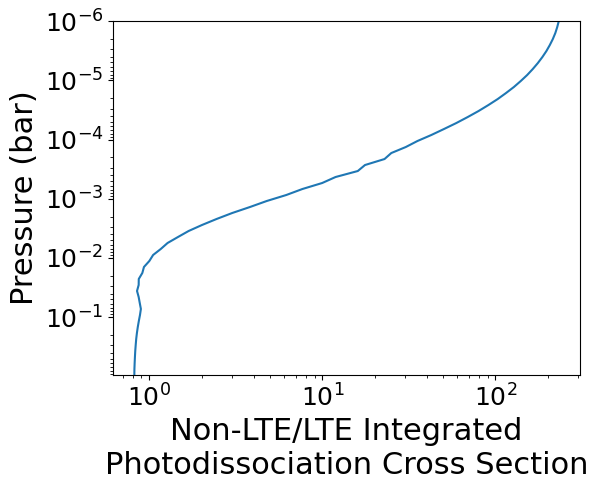

In [32]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
model_dir = f"{root_dir}1xOH_bL20/outputs/"
# nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"
nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"

rate_ratios = []
# plot_temps = np.concatenate(([300], np.linspace(2000, 10000, 5)))
# plot_ratios = [[] for _ in plot_temps]
for layer_idx in range(20, 80):
    nlte_file = glob.glob(f"KELT-20b_nLTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    lte_file = glob.glob(f"KELT-20b_LTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    nlte_cont_xsec = np.loadtxt(f"{nlte_model_dir}{nlte_file}")
    lte_cont_xsec = np.loadtxt(f"{model_dir}{lte_file}")
    # for plot_idx, plot_temp in enumerate(plot_temps):
    #     nlte_rate = xsec_to_rate(nlte_cont_xsec, plot_temp)
    #     lte_rate = xsec_to_rate(lte_cont_xsec, plot_temp)
    #     # print(f"NLTE rate = {nlte_rate}")
    #     # print(f"LTE rate = {lte_rate}")
    #     rate_ratio = nlte_rate/lte_rate
    #     plot_ratios[plot_idx].append(rate_ratio)
    nlte_rate = xsec_to_rate(nlte_cont_xsec)
    lte_rate = xsec_to_rate(lte_cont_xsec)
    rate_ratio = nlte_rate/lte_rate
    print(f"Ratio = {rate_ratio}")
    rate_ratios.append(rate_ratio)

plt.figure(figsize=(6, 5))

# for plot_idx, plot_temp in enumerate(plot_temps):
#     plt.plot(plot_ratios[plot_idx], central_pressure[20:], label=f"T$_{{*}}$={plot_temp} K")
plt.plot(rate_ratios, central_pressure[20:])
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
plt.xlabel("Non-LTE/LTE Integrated\nPhotodissociation Cross Section", fontsize=label_fontsize,
           #fontweight="bold"
           )
plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
# plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/OH_photodissociation_rate_uniform.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [55]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
model_dir = f"{root_dir}1xOH_bL20/outputs/"
# nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"
nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"

def xsec_to_rate(xsec: npt.NDArray[np.float64], intensity: npt.NDArray[np.float64]) -> u.Quantity:
    wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())

    intensity = (intensity * u.J / u.m**2) * ac.c * (xsec[:, 0] * u.k)**2
    # intensity = (intensity * u.J / u.m**2) * ac.c / (xsec[:, 0] * u.k).to(u.m, equivalencies=u.spectral())**2
    intensity = intensity.to(u.J / (u.s * u.cm**2 * u.um), equivalencies=u.spectral())

    intensity = intensity / (ac.h * ac.c / wl_grid)
    intensity = intensity.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
    product = intensity * (xsec[:, 1] * u.cm**2)
    rate = simpson(product[::-1], x=wl_grid.value[::-1])
    return rate


lte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_LTE_intensity.txt")
nlte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_nLTE_intensity.txt")
# oh_num_dens = np.array([7.01036253e+02, 1.48813222e+03, 3.15518174e+03, 6.68013711e+03, 1.41191526e+04, 2.97830058e+04,
#                         6.26807250e+04, 1.31575473e+05, 2.75403937e+05, 5.74667457e+05, 1.19519406e+06, 2.47738891e+06,
#                         5.11777526e+06, 1.05374570e+07, 2.16286589e+07, 4.42651955e+07, 9.03552618e+07, 1.84006098e+08,
#                         3.73964200e+08, 7.58706037e+08, 1.53702218e+09, 3.10996308e+09, 6.28624286e+09, 1.26960064e+10,
#                         2.56241854e+10, 5.16887153e+10, 1.04219784e+11, 2.10063551e+11, 4.23271437e+11, 8.52446242e+11,
#                         1.71304027e+12, 3.41271157e+12, 6.62997249e+12, 1.24334409e+13, 1.52809966e+13, 1.08937201e+13,
#                         7.81801870e+12, 5.68490340e+12, 4.19314422e+12, 3.13356623e+12, 2.36813576e+12, 1.80638422e+12,
#                         1.38835749e+12, 1.07360451e+12, 8.34283594e+11, 6.50851218e+11, 5.09334842e+11, 3.99578377e+11,
#                         3.14091628e+11, 2.47280710e+11, 1.94923103e+11, 1.53802739e+11, 1.21451793e+11, 9.59649427e+10,
#                         4.04155609e+10, 1.25756037e+10, 3.91445559e+09, 1.21879624e+09, 3.79558935e+08, 1.18221260e+08,
#                         3.68269133e+07, 1.14730017e+07, 3.57455483e+06, 1.11376379e+06, 3.47044351e+05, 1.08141727e+05,
#                         3.36988152e+04, 1.05013775e+04, 3.27117519e+03, 1.01919833e+03, 3.17595356e+02, 9.89727054e+01,
#                         3.08438463e+01, 9.61230493e+00, 2.99564186e+00, 9.33586066e-01, 2.90951299e-01, 9.06749495e-02,
#                         2.82588945e-02, 8.80691197e-03]) << u.cm**-3
# # Size of each layer?
# planet_radius = 130830360 * u.m
# altitude = np.array([0., 28911.22163328, 284658.69512139, 310796.27161053, 542605.89165338, 566362.42859974, 777825.37910708,
#                      799582.75368623, 994191.84978125, 1014319.45399919, 1195425.20318672, 1214272.26563916, 1384984.98265428,
#                      1402868.05043419, 1565932.34620195, 1583122.37118726, 1740814.66165624, 1757529.19056576, 1911620.75601544,
#                      1928024.0417366, 2079815.97248072, 2096025.6951755, 2246430.04719567, 2262527.1479376, 2412161.30495047,
#                      2428199.84192994, 2577471.58650289, 2593486.94164579, 2742661.33128269, 2758676.71977894, 2907972.53281141,
#                      2924044.09766684, 3075499.40981388, 3092364.83942792, 3261207.67087855, 3281206.57643808, 3488460.21950394,
#                      3513063.93552062, 3763054.7997063, 3791948.28302645, 4077627.04607448, 4109869.57948491, 4422206.90744858,
#                      4456882.06968537, 4788233.49724523, 4824626.83606529, 5169355.69897861, 5206960.04916881, 5561177.82720691,
#                      5599650.49669721, 5960772.65234644, 5999888.68262952, 6366236.04240559, 6405850.46152646, 6776348.64710019,
#                      6816375.53866959, 7190444.52802697, 7230825.87738565, 7607965.88835926, 7648660.63556605, 8028591.58413801,
#                      8069576.97740847, 8452138.33676184, 8493401.21856865, 8878500.86861419, 8920033.85036403, 9307621.91292058,
#                      9349421.2182565, 9739474.42992098, 9781556.25616381, 10174316.20992916, 10216675.53246613, 10611947.47903479,
#                      10654574.80850774, 11052332.09582643, 11095227.30971948, 11495479.83547229, 11538644.57480589,
#                      11941410.15855473, 11984846.53532292]) * u.m
# altitude = np.concatenate((altitude, [planet_radius]))
# volume = 4 * np.pi * (altitude[1:]**3 - altitude[:-1]**3) / 3
# num_oh = volume.to(u.cm**3) * oh_num_dens
# print(num_oh)

rate_ratios = []
lte_rates = []
nlte_rates = []
for layer_idx in range(20, 80):
    nlte_file = glob.glob(f"KELT-20b_nLTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    lte_file = glob.glob(f"KELT-20b_LTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    nlte_cont_xsec = np.loadtxt(f"{nlte_model_dir}{nlte_file}")
    lte_cont_xsec = np.loadtxt(f"{model_dir}{lte_file}")
    nlte_rate = xsec_to_rate(nlte_cont_xsec, nlte_intensity_matrix[layer_idx])
    lte_rate = xsec_to_rate(lte_cont_xsec, lte_intensity_matrix[layer_idx])
    rate_ratio = nlte_rate/lte_rate
    print(f"Ratio = {rate_ratio}")
    lte_rates.append(lte_rate)
    nlte_rates.append(nlte_rate)
    rate_ratios.append(rate_ratio)

plt.figure(figsize=(6, 8), dpi=200)

print(f"Total photons per second (LTE) = {sum(lte_rates * num_oh[20:])}")
print(f"Total photons per second (nLTE) = {sum(nlte_rates * num_oh[20:])}")

plt.plot(rate_ratios, central_pressure[20:], linewidth=line_width)
# plt.plot(lte_rates, central_pressure[20:], label="LTE")
# plt.plot(nlte_rates, central_pressure[20:], label="Non-LTE")
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
x_label = "Non-LTE/LTE\nPhotodissociation Rate"
# x_label = "Photodissociation Rate\n(photons s$^{-1}$ molecule$^{-1}$)"

plt.xlabel(x_label, fontsize=label_fontsize,
           #fontweight="bold"
           )
plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
# plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/OH_photodissociation_rate.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

ValueError: operands could not be broadcast together with shapes (10099,) (85561,) 

79
(85561,) (85561, 2)
(85561,) (85561, 2)
Ratio = 266.96045837786505
Total photons per second (LTE) = 1.1036732203390592e+35
Total photons per second (nLTE) = 2.9463710880108956e+37


ValueError: x and y must have same first dimension, but have shapes (1,) and (60,)

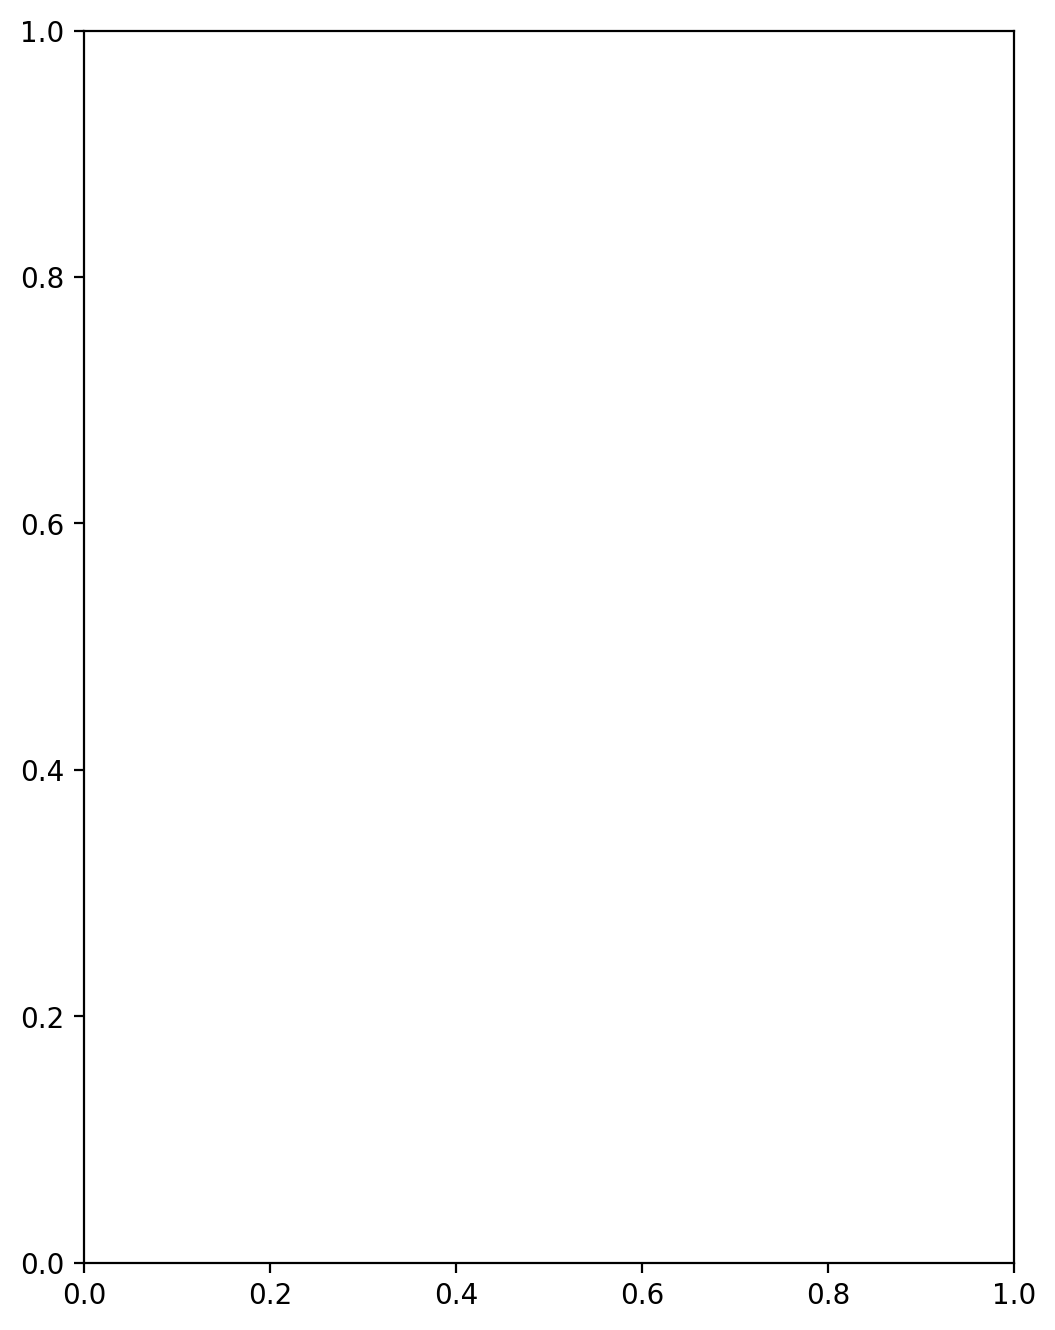

In [27]:
# root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
# model_dir = f"{root_dir}1xOH_bL20/outputs/"
# # nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"
# lte_model_dir = f"{root_dir}1xOH_bL20/outputs/"
# nlte_model_dir = f"{root_dir}1xOH_bL20/outputs_new3/"
#
# def xsec_to_rate(xsec: npt.NDArray[np.float64], intensity: npt.NDArray[np.float64]) -> u.Quantity:
#     wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
#     print(intensity.shape, xsec.shape)
#     intensity = (intensity * u.J / u.m**2) * ac.c * (xsec[:, 0] * u.k)**2
#     # intensity = (intensity * u.J / u.m**2) * ac.c / (xsec[:, 0] * u.k).to(u.m, equivalencies=u.spectral())**2
#     intensity = intensity.to(u.J / (u.s * u.cm**2 * u.um), equivalencies=u.spectral())
#
#     intensity = intensity / (ac.h * ac.c / wl_grid)
#     intensity = intensity.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
#     product = intensity * (xsec[:, 1] * u.cm**2)
#     rate = simpson(product[::-1], x=wl_grid.value[::-1])
#     return rate
#
#
# # lte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_LTE_intensity.txt")
# # nlte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_nLTE_intensity.txt")
# lte_intensity_matrix = np.loadtxt(f"{lte_model_dir}KELT-20b_LTE_cont_1xOH_boundaryL20_highres.txt")
# nlte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_cont_1xOH_boundaryL20_transmission_highres.txt")
# # print(nlte_intensity_matrix[:, 1].shape)
#
# rate_ratios = []
# lte_rates = []
# nlte_rates = []
# for layer_idx in range(79, 80):
#     print(layer_idx)
#     nlte_file = glob.glob(f"KELT-20b_nLTE_cont_L{layer_idx}*.txt", root_dir=nlte_model_dir)[0]
#     lte_file = glob.glob(f"KELT-20b_LTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=lte_model_dir)[0]
#     nlte_cont_xsec = np.loadtxt(f"{nlte_model_dir}{nlte_file}")
#     lte_cont_xsec = np.loadtxt(f"{lte_model_dir}{lte_file}")
#     nlte_rate = xsec_to_rate(nlte_cont_xsec, nlte_intensity_matrix[:, 1])
#     lte_rate = xsec_to_rate(lte_cont_xsec, lte_intensity_matrix[:, 1])
#     rate_ratio = nlte_rate/lte_rate
#     print(f"Ratio = {rate_ratio}")
#     lte_rates.append(lte_rate)
#     nlte_rates.append(nlte_rate)
#     rate_ratios.append(rate_ratio)
#
# plt.figure(figsize=(6, 8), dpi=200)
#
# print(f"Total photons per second (LTE) = {sum(lte_rates * num_oh[20:])}")
# print(f"Total photons per second (nLTE) = {sum(nlte_rates * num_oh[20:])}")
#
# plt.plot(rate_ratios, central_pressure[20:], linewidth=line_width)
# # plt.plot(lte_rates, central_pressure[20:], label="LTE")
# # plt.plot(nlte_rates, central_pressure[20:], label="Non-LTE")
# plt.xscale("log")
# plt.yscale("log")
# plt.gca().invert_yaxis()
# plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
# x_label = "Non-LTE/LTE\nPhotodissociation Rate"
# # x_label = "Photodissociation Rate\n(photons s$^{-1}$ molecule$^{-1}$)"
#
# plt.xlabel(x_label, fontsize=label_fontsize,
#            #fontweight="bold"
#            )
# plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
#            # fontweight="bold"
#            )
# plt.tick_params(labelsize=tick_fontsize)
# # plt.legend(loc="best", fontsize=tick_fontsize)
# plt.tight_layout()
# # plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/OH_photodissociation_rate.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.show()

Ratio = 1.0793753165709203
Ratio = 1.2755527374795916
Ratio = 1.5407575710602024
Ratio = 1.8190218188093017
Ratio = 2.389442006121763
Ratio = 3.0075794875832633
Ratio = 3.7979030740800046
Ratio = 4.760575136365781
Ratio = 6.263278006144151
Ratio = 7.736351490577649
Ratio = 9.363499391515347
Ratio = 9.42149456819139
Ratio = 5.815753052834475
Ratio = 2.1563157917642766
Ratio = 0.9541076378442515
Ratio = 0.9444827915452987
Ratio = 1.150928067581636
Ratio = 1.1521284067137298
Ratio = 1.0107007157916512
Ratio = 0.9559351143930528
Ratio = 0.9303766848494671
Ratio = 0.945253684784295
Ratio = 0.969634716843226
Ratio = 1.041697141024031
Ratio = 1.1285347139378927
Ratio = 1.2987269077408863
Ratio = 1.5481775946527034
Ratio = 1.8880424476614082
Ratio = 2.4483963570220686
Ratio = 3.137182659064591
Ratio = 4.366087074015225
Ratio = 5.746900294691249
Ratio = 8.412659796836138
Ratio = 11.093251469857554
Ratio = 17.281583796539774
Ratio = 20.745709459435396
Ratio = 32.619218980250736
Ratio = 41.072151

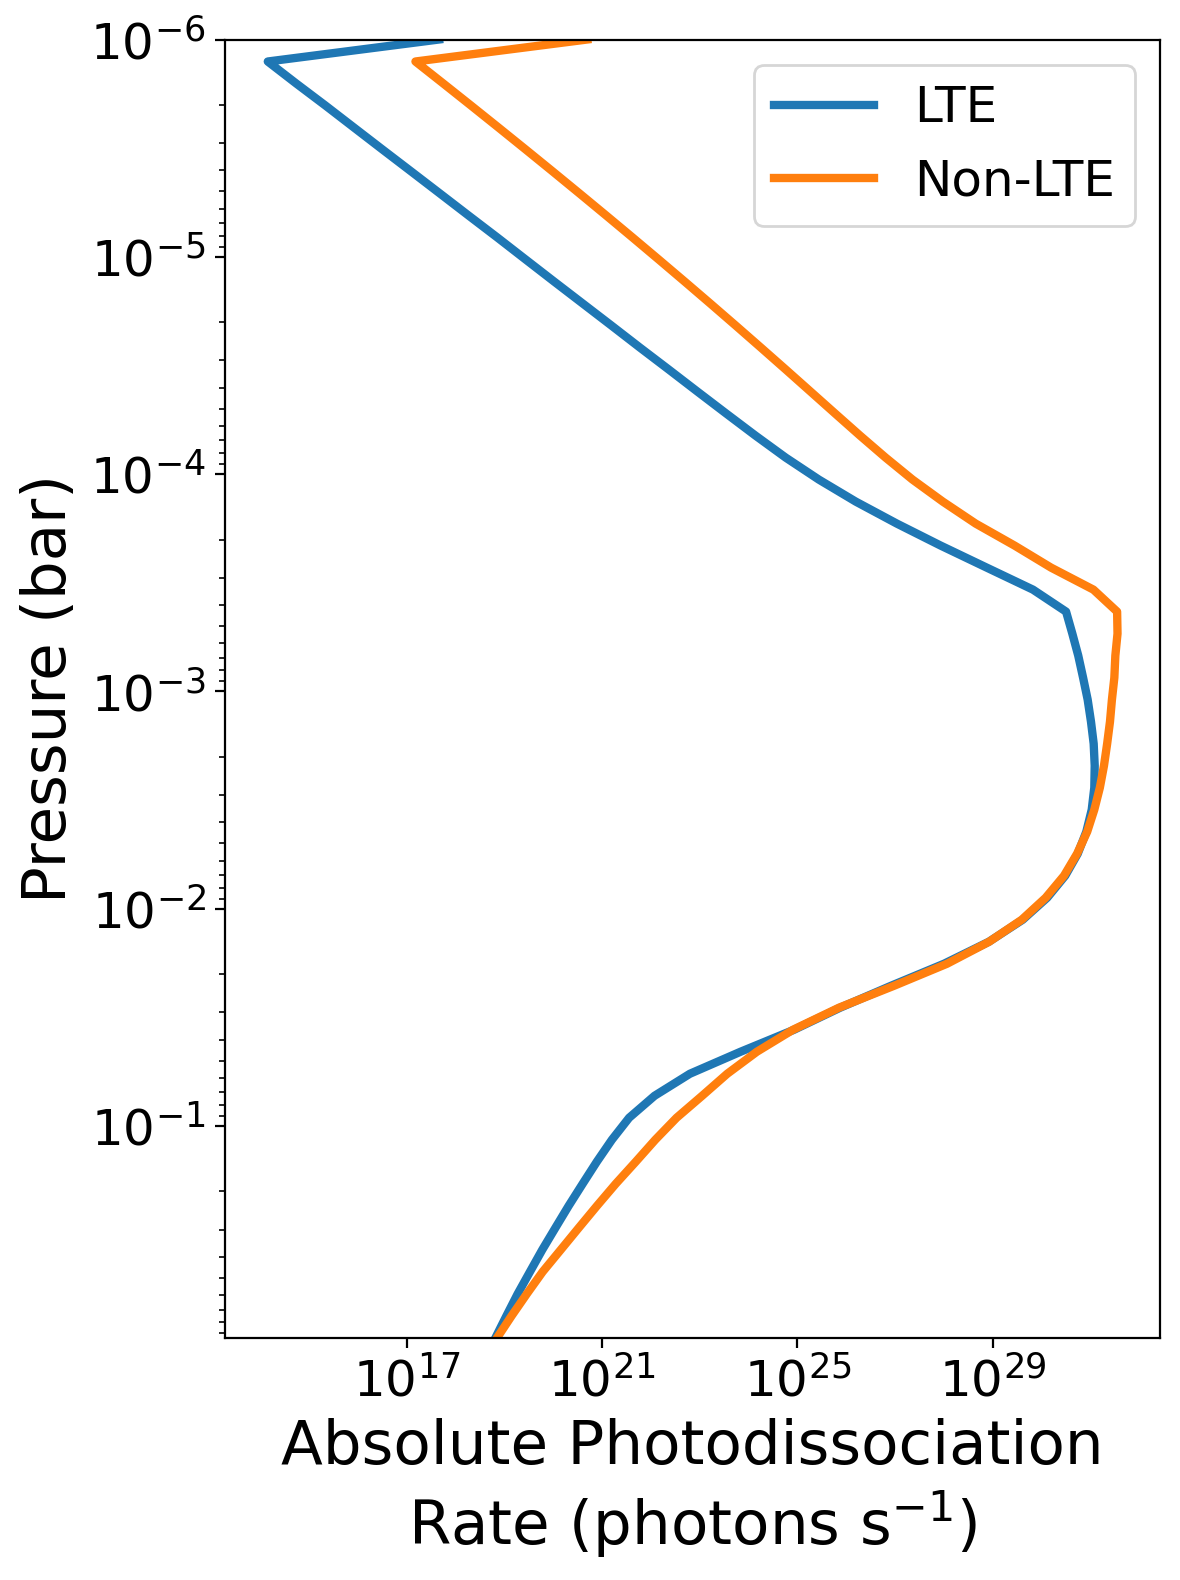

In [14]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
model_dir = f"{root_dir}1xOH_bL20/outputs/"
# nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"
nlte_model_dir = f"{root_dir}1xOH_bL20/outputs/"


def xsec_to_rate(xsec: npt.NDArray[np.float64], intensity: npt.NDArray[np.float64]) -> u.Quantity:
    wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())

    intensity = (intensity * u.J / u.m**2) * ac.c * (xsec[:, 0] * u.k)**2
    # intensity = (intensity * u.J / u.m**2) * ac.c / (xsec[:, 0] * u.k).to(u.m, equivalencies=u.spectral())**2
    intensity = intensity.to(u.J / (u.s * u.cm**2 * u.um), equivalencies=u.spectral())

    intensity = intensity / (ac.h * ac.c / wl_grid)
    intensity = intensity.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
    product = intensity * (xsec[:, 1] * u.cm**2)
    rate = simpson(product[::-1], x=wl_grid.value[::-1])
    return rate


lte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_LTE_intensity.txt")
nlte_intensity_matrix = np.loadtxt(f"{nlte_model_dir}KELT-20b_nLTE_intensity.txt")
# print(num_oh)

rate_ratios = []
lte_rates = []
nlte_rates = []
for layer_idx in range(20, 80):
    nlte_file = glob.glob(f"KELT-20b_nLTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    lte_file = glob.glob(f"KELT-20b_LTE_cont_abs_xsec_L{layer_idx}*.txt", root_dir=model_dir)[0]
    nlte_cont_xsec = np.loadtxt(f"{nlte_model_dir}{nlte_file}")
    lte_cont_xsec = np.loadtxt(f"{model_dir}{lte_file}")
    nlte_rate = xsec_to_rate(nlte_cont_xsec, nlte_intensity_matrix[layer_idx])
    lte_rate = xsec_to_rate(lte_cont_xsec, lte_intensity_matrix[layer_idx])
    rate_ratio = nlte_rate/lte_rate
    print(f"Ratio = {rate_ratio}")
    lte_rates.append(lte_rate)
    nlte_rates.append(nlte_rate)
    rate_ratios.append(rate_ratio)

plt.figure(figsize=(6, 8), dpi=200)

print(f"Total photons per second (LTE) = {sum(lte_rates * num_oh[20:])}")
print(f"Total photons per second (nLTE) = {sum(nlte_rates * num_oh[20:])}")

# plt.plot(rate_ratios, central_pressure[20:])
plt.plot(lte_rates * num_oh[20:], central_pressure[20:], label="LTE", linewidth=line_width)
plt.plot(nlte_rates * num_oh[20:], central_pressure[20:], label="Non-LTE", linewidth=line_width)
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
# x_label = "Non-LTE/LTE\nPhotodissociation Rate (photons s$^{-1}$ molecule$^{-1}$)"
x_label = "Absolute Photodissociation\nRate (photons s$^{-1}$)"

plt.xlabel(x_label, fontsize=label_fontsize,
           #fontweight="bold"
           )
plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/OH_photodissociation_rate_absolute.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

(80, 5002)


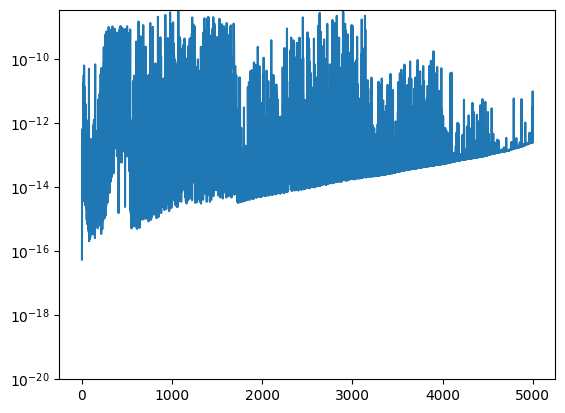

In [36]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
model_dir = f"{root_dir}1xOH_bL20/outputs/"
lte_intensity = np.loadtxt(f"{model_dir}KELT-20b_LTE_intensity.txt")
print(lte_intensity.shape)
plt.plot(np.arange(0, len(lte_intensity[0])), lte_intensity[50])
plt.ylim(bottom=1e-20)
plt.yscale("log")
plt.show()

In [17]:
print(np.vstack((central_pressure.value, oh_vmr)).T)

[[1.00000000e+02 2.61377550e-18]
 [7.92016405e+01 6.64250017e-18]
 [6.27289986e+01 1.68808715e-17]
 [4.96823959e+01 4.29000854e-17]
 [3.93492726e+01 1.09023833e-16]
 [3.11652694e+01 2.77066959e-16]
 [2.46834047e+01 7.04122188e-16]
 [1.95496614e+01 1.78941602e-15]
 [1.54836526e+01 4.54751994e-15]
 [1.22633068e+01 1.15568081e-14]
 [9.71274020e+00 2.93698139e-14]
 [7.69264957e+00 7.46387720e-14]
 [6.09270466e+00 1.89682723e-13]
 [4.82552204e+00 4.82048868e-13]
 [3.82189262e+00 1.22505154e-12]
 [3.02700165e+00 3.11327619e-12]
 [2.39743497e+00 7.91190276e-12]
 [1.89880782e+00 2.01068590e-11]
 [1.50388695e+00 5.10984261e-11]
 [1.19110313e+00 1.29858629e-10]
 [9.43373222e-01 3.30015324e-10]
 [7.47167068e-01 8.38682146e-10]
 [5.91768575e-01 2.13137904e-09]
 [4.68690419e-01 5.41656534e-09]
 [3.71210501e-01 1.37653510e-08]
 [2.94004806e-01 3.49824813e-08]
 [2.32856630e-01 8.89025008e-08]
 [1.84426271e-01 2.25931852e-07]
 [1.46068632e-01 5.74170988e-07]
 [1.15688753e-01 1.45916964e-06]
 [9.162739

In [22]:
print(np.vstack((central_pressure.value, x1OH_bL20_pop_matrix[0, :, 10],x1OH_bL20_pop_matrix[-1, :, 10])).T)

[[1.00000000e+02 4.13358204e-07 4.13358204e-07]
 [7.92016405e+01 1.85168296e-07 1.85168296e-07]
 [6.27289986e+01 8.07287768e-08 8.07287768e-08]
 [4.96823959e+01 3.44283833e-08 3.44283833e-08]
 [3.93492726e+01 1.44573017e-08 1.44573017e-08]
 [3.11652694e+01 6.02656282e-09 6.02656282e-09]
 [2.46834047e+01 2.51784381e-09 2.51784381e-09]
 [1.95496614e+01 1.06572549e-09 1.06572549e-09]
 [1.54836526e+01 4.62279549e-10 4.62279549e-10]
 [1.22633068e+01 2.07873594e-10 2.07873594e-10]
 [9.71274020e+00 9.79435140e-11 9.79435140e-11]
 [7.69264957e+00 4.87950544e-11 4.87950544e-11]
 [6.09270466e+00 2.58783671e-11 2.58783671e-11]
 [4.82552204e+00 1.46691107e-11 1.46691107e-11]
 [3.82189262e+00 8.89786708e-12 8.89786708e-12]
 [3.02700165e+00 5.76706458e-12 5.76706458e-12]
 [2.39743497e+00 3.97969581e-12 3.97969581e-12]
 [1.89880782e+00 2.90898779e-12 2.90898779e-12]
 [1.50388695e+00 2.23874427e-12 2.23874427e-12]
 [1.19110313e+00 1.80241629e-12 1.80241629e-12]
 [9.43373222e-01 1.50849675e-12 1.881649

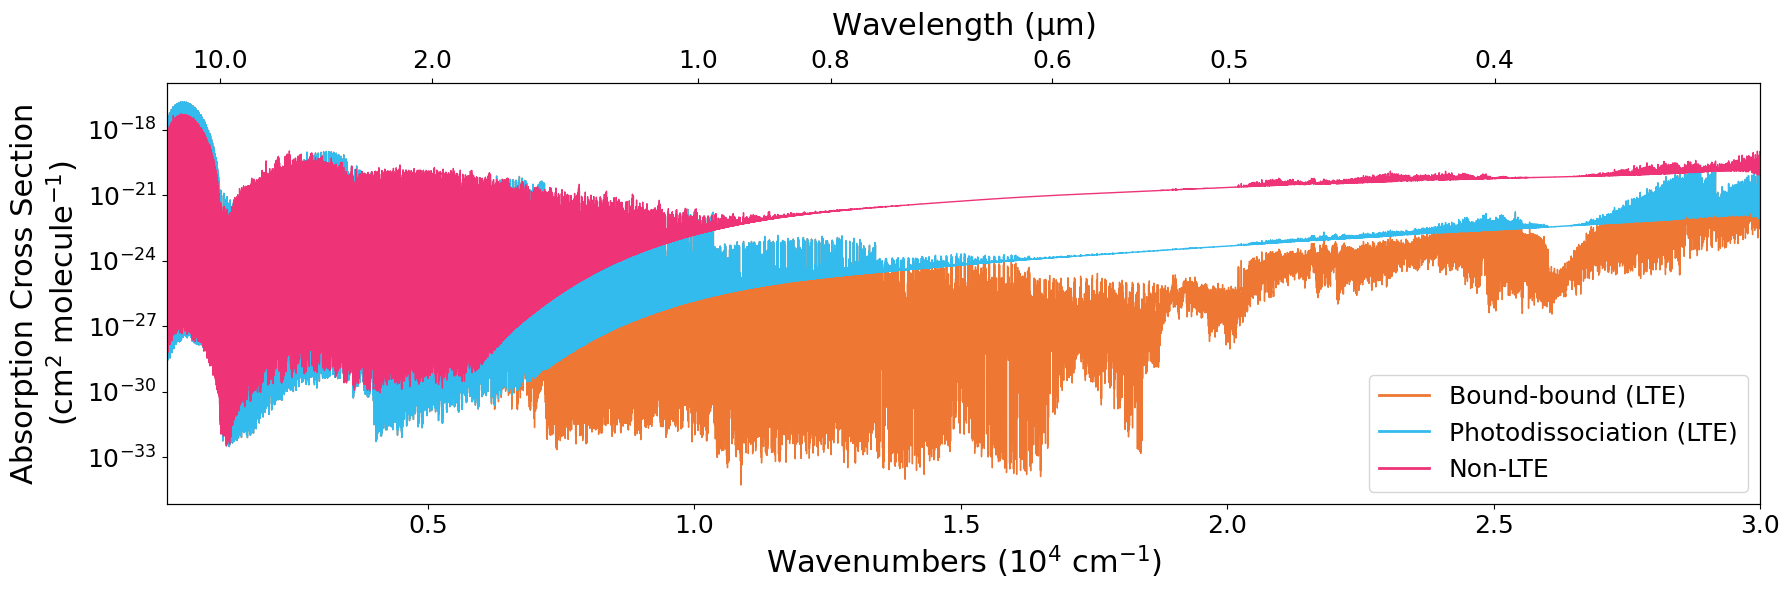

In [4]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 6))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength (${\rm \mu}$m)"
y_label = "Absorption Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(lte_toa_xsec[:, 0] / 1e4, lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(lte_cont_toa_xsec[:, 0] / 1e4, lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(nlte_cont_toa_xsec[:, 0] / 1e4, nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
plt.xlim(left=lte_toa_xsec[0, 0] / 1e4, right=lte_toa_xsec[-1, 0] / 1e4)
plt.yscale("log")
legend = plt.legend(loc="best", fontsize=tick_fontsize)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=lte_toa_xsec[-1, 0] / 10000)
wl_tick_vals = [10.0, 2.0, 1.0, 0.8, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize,
                 # fontweight="bold",
                 labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_LTE_xsecs.png", dpi=600, transparent=True, bbox_inches="tight")
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_xsecs.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

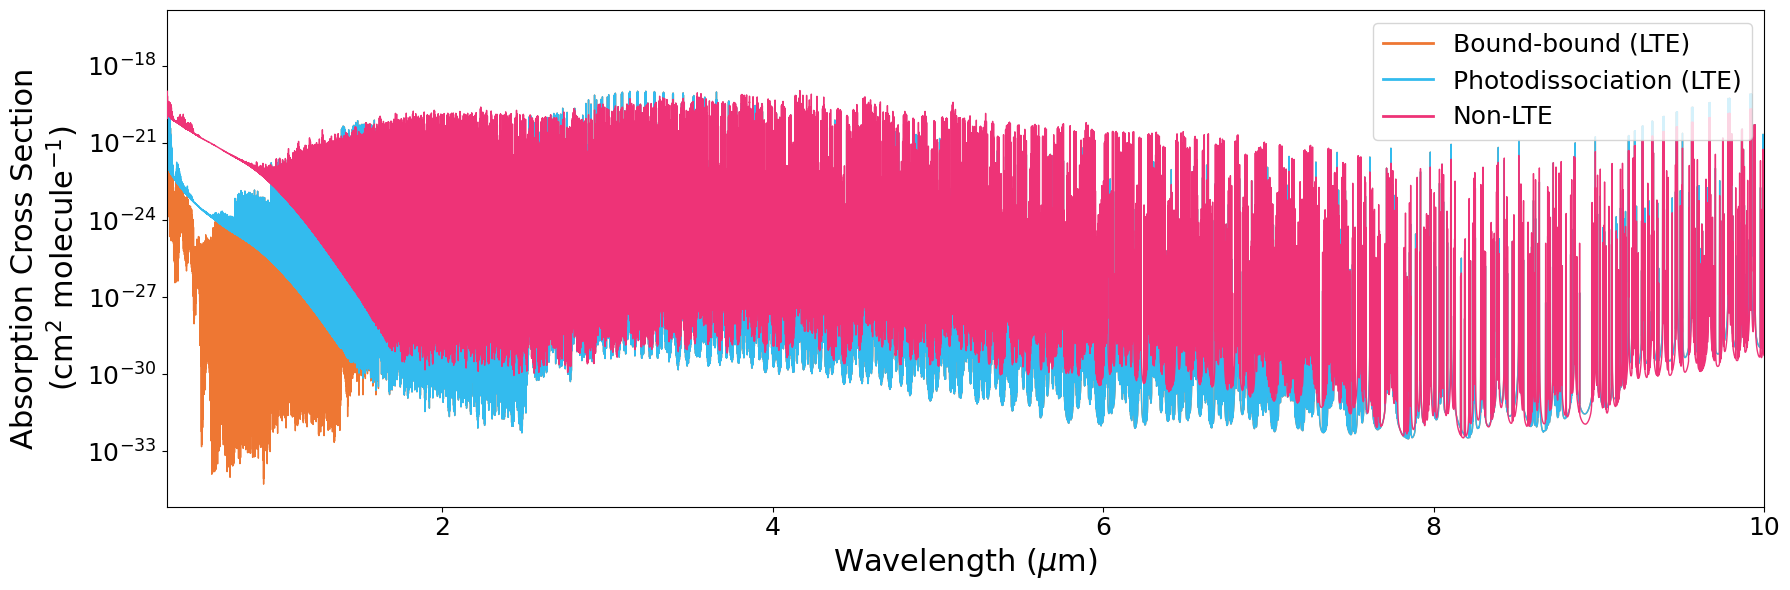

In [86]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 6))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength ($\mu$m)"
y_label = "Absorption Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(1e4 / lte_toa_xsec[:, 0], lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(1e4 / lte_cont_toa_xsec[:, 0], lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(1e4 / nlte_cont_toa_xsec[:, 0], nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
plt.xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
plt.yscale("log")
legend = plt.legend(loc="best", fontsize=tick_fontsize)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_wl_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

# ax_wl = plt.gca().twiny()
# ax_wl.set_xlim(left=0, right=lte_toa_xsec[-1, 0] / 10000)
# wl_tick_vals = [10.0, 2.0, 1.0, 0.8, 0.6, 0.5, 0.4]
# new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
# ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize, fontweight="bold", labelpad=10)
# ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_xsecs_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [59]:
print(lte_cont_toa_xsec[np.argmin(abs(lte_cont_toa_xsec[:, 0] - 20000)), 1])
print(nlte_cont_toa_xsec[np.argmin(abs(nlte_cont_toa_xsec[:, 0] - 20000)), 1])

20709.0431
4.78640205e-24
1.91766481e-21


27


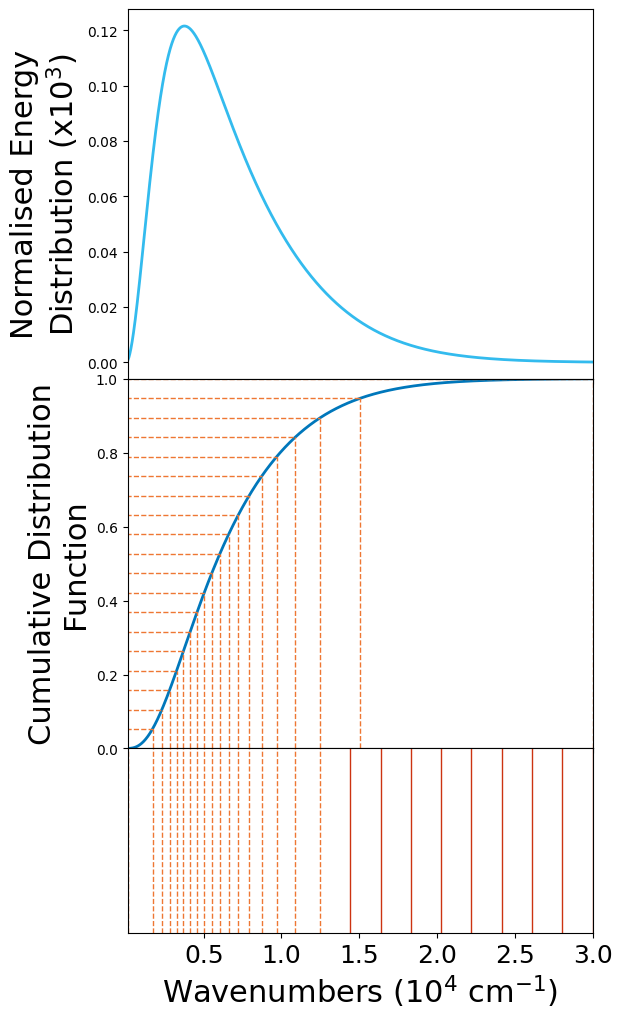

In [17]:
import numba
from scipy.integrate import cumulative_simpson


ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
const_h_c_on_kB = ac_h_c_on_kB.value
const_2_pi_h_c_sq_on_sigma_sba = (
    (2 * np.pi * ac.h * ac.c.cgs**2 / ac.sigma_sb).to(u.K**4 * u.cm**4, equivalencies=u.spectral()).value
)


@numba.njit()
def calc_ev_grid(wn_grid: npt.NDArray[np.float64], temperature: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return (const_2_pi_h_c_sq_on_sigma_sba * wn_grid**3) / (
        temperature**4 * (np.exp(const_h_c_on_kB * wn_grid / temperature) - 1)
    )


# TODO: optimise this!
def cdf_opacity_sampling(
    wn_start: float,
    wn_end: float,
    temperature_profile: npt.NDArray[np.float64],
    num_points: int,
    max_step: float = None,
    num_cdf_points: int = 1000000,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    temp_wn_grid = np.linspace(wn_start, wn_end, num_cdf_points)
    ev_grid = calc_ev_grid(wn_grid=temp_wn_grid, temperature=np.atleast_1d(temperature_profile)[:, None]).sum(axis=0)
    ev_norm = ev_grid / simpson(ev_grid, x=temp_wn_grid)

    ev_cdf = cumulative_simpson(ev_norm, x=temp_wn_grid, initial=0)

    # sample_idxs = np.searchsorted(ev_cdf, np.linspace(0, 1, num_points))
    sample_idxs = np.array(
        [
            np.argmin(abs(ev_cdf - point)) if point <= ev_cdf[-1] else len(ev_cdf) - 1
            for point in np.linspace(0, 1, num_points)
        ]
    )
    sample_idxs = np.unique(sample_idxs)
    # Both methods allow for the same wn point to be the closest to multiple values on the CDF, so remove duplicates.
    # The argmin approach should be better when using a small number of points but is marginally slower.
    initial_grid = temp_wn_grid[sample_idxs]

    if sample_idxs[-1] == len(ev_cdf):
        sample_idxs[-1] -= 1
    if max_step:
        max_idx_step = int(np.ceil(max_step * num_cdf_points / (wn_end - wn_start))) - 1
        idx_diffs = np.diff(sample_idxs)
        idxs_diffs_over_max = np.nonzero(idx_diffs > max_idx_step)[0]
        idxs_diffs_over_max_chunks = np.split(idxs_diffs_over_max, np.where(np.diff(idxs_diffs_over_max) != 1)[0] + 1)
        chunk_idx = 0
        while chunk_idx < len(idxs_diffs_over_max_chunks):
            chunk = idxs_diffs_over_max_chunks[chunk_idx]
            end_idx = chunk[-1] + 1 if chunk[-1] + 1 < len(sample_idxs) else chunk[-1]
            n_new_points = int(np.ceil((sample_idxs[end_idx] - sample_idxs[chunk[0]]) / max_idx_step)) + 1
            insert_vals = np.linspace(sample_idxs[chunk[0]], sample_idxs[end_idx], n_new_points, dtype=int)
            sample_idxs = np.concatenate((sample_idxs[: chunk[0]], insert_vals, sample_idxs[chunk[-1] + 2 :]))
            idxs_diffs_over_max_chunks = list(
                idx_chunk + n_new_points - len(chunk) - 1 for idx_chunk in idxs_diffs_over_max_chunks
            )
            chunk_idx += 1

    sampled_grid = temp_wn_grid[sample_idxs]
    return sampled_grid, initial_grid, ev_norm, ev_cdf

wn_start, wn_end = 100, 30000
num_points = 20
sampled_grid, initial_grid, ev_norm, ev_cdf = cdf_opacity_sampling(
    wn_start=wn_start, wn_end=wn_end, temperature_profile=temperature_profile, num_points=num_points, max_step=2000
)
print(len(sampled_grid))
temp_wn_grid = np.linspace(wn_start, wn_end, 1000000)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 12), height_ratios=[4, 4, 2])

ax1.plot(temp_wn_grid / 1e4, ev_norm * 1e3, color="#33BBEE", linewidth=2.0)
ax1.set_xlim(left=wn_start / 1e4, right=wn_end / 1e4)
ax1.set_ylabel("Normalised Energy\nDistribution (x10$^{3}$)", fontsize=label_fontsize)

ax2.plot(temp_wn_grid / 1e4, ev_cdf, color="#0077BB", linewidth=2.0)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(bottom=0, top=1)
ax2.hlines(np.linspace(0, 1, num_points), np.repeat(0, num_points), initial_grid / 1e4, linewidth=1.0, linestyle="--", color="#EE7733")
ax2.vlines(initial_grid / 1e4, np.repeat(0, num_points), np.linspace(0, 1, num_points), linewidth=1.0, linestyle="--", color="#EE7733")
ax2.set_ylabel("Cumulative Distribution\nFunction", fontsize=label_fontsize)

# ax3.vlines(initial_grid / 1e4, ymin=1, ymax=2, color="#FFFF00", linewidth=0.1, label="Initial sampling")
ax3.vlines(sampled_grid[:-9] / 1e4, ymin=0, ymax=1, color="#EE7733", linewidth=1.0, linestyle="--")
ax3.vlines(sampled_grid[-9:] / 1e4, ymin=0, ymax=1, color="#CC3311", linewidth=1.0, linestyle="-")
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(bottom=0, top=1)
ax3.set_xlabel(r"Wavenumbers (10$^{4}$ cm$^{-1}$)", fontsize=label_fontsize)
ax3.tick_params(axis="x", which="both", labelsize=tick_fontsize)
ax3.tick_params(axis="y", which="both", labelleft=False, labelright=False, left=False, right=False)

plt.subplots_adjust(hspace=0)
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/opacity_sampling.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [4]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"

def load_xsec(bl: int, oh_scale: float, layer_idx: int) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    working_dir = rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/"

    lte_xsec = np.loadtxt(rf"{working_dir}KELT-20b_LTE_abs_xsec_T{int(temperature_profile[layer_idx].value)}_P{central_pressure[layer_idx].value:.4e}.txt")
    lte_cont = np.loadtxt(rf"{working_dir}KELT-20b_LTE_cont_abs_xsec_L{layer_idx}_T{int(temperature_profile[layer_idx].value)}_P{central_pressure[layer_idx].value:.4e}.txt")
    lte_xsec[:, 1] += lte_cont[:, 1]

    nlte_xsec = np.loadtxt(rf"{working_dir}KELT-20b_nLTE_abs_xsec_T{int(temperature_profile[layer_idx].value)}_P{central_pressure[layer_idx].value:.4e}.txt")
    nlte_cont = np.loadtxt(rf"{working_dir}KELT-20b_nLTE_cont_abs_xsec_L{layer_idx}_T{int(temperature_profile[layer_idx].value)}_P{central_pressure[layer_idx].value:.4e}.txt")
    nlte_xsec[:, 1] += nlte_cont[:, 1]
    return lte_xsec, nlte_xsec


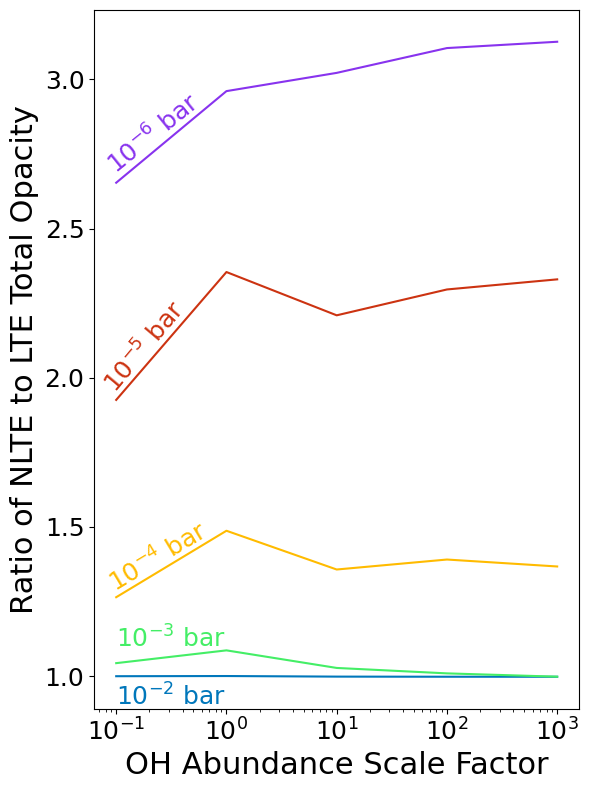

In [6]:
oh_scale_factors = [0.1, 1, 10, 100, 1000]
# oh_scale_factors = [0.1, 1, 10, 100]
# plot_layer_idxs = range(20, 80)
plot_layer_idxs = [39, 49, 59, 69, 79]
plot_ratios = [[] for _ in oh_scale_factors]

lte_integrals = np.zeros((len(oh_scale_factors), len(plot_layer_idxs)))
nlte_integrals = np.zeros((len(oh_scale_factors), len(plot_layer_idxs)))

xsec_to_opacity = 1 / (mass_oh << u.Da).to(u.g).value

for factor_idx, oh_scale_factor in enumerate(oh_scale_factors):
    for grid_idx, layer_idx in enumerate(plot_layer_idxs):
        lte_xsec, nlte_xsec = load_xsec(bl=20, oh_scale=oh_scale_factor, layer_idx=layer_idx)

        lte_xsec *= xsec_to_opacity
        nlte_xsec *= xsec_to_opacity

        lte_integral = simpson(lte_xsec[:, 1], x=lte_xsec[:, 0])
        nlte_integral = simpson(nlte_xsec[:, 1], x=nlte_xsec[:, 0])
        lte_integrals[factor_idx, grid_idx] = lte_integral
        nlte_integrals[factor_idx, grid_idx] = nlte_integral

        # rate_ratio = nlte_integral / lte_integral
        # print(f"OHx{oh_scale_factor} L{layer_idx} Ratio = {rate_ratio}")
        # plot_ratios[factor_idx].append(rate_ratio)

# plt.rc('text', usetex=False)
# plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
plt.figure(figsize=(6, 8))

ratio_integrals = nlte_integrals / lte_integrals

plot_colors = get_vibrant_colors(len(plot_layer_idxs), ordered=True)

text_scale = [0.9, 1.05, 1.01, 1.01, 1.01]
text_rotation = [0, 0, 31, 50, 39]
for grid_idx, layer_idx in enumerate(plot_layer_idxs):
    plt.plot(oh_scale_factors, ratio_integrals[:, grid_idx], label=f"L{layer_idx}, 10$^{{{int(np.floor(np.log10(central_pressure[layer_idx].value)))}}}$ bar", color=plot_colors[grid_idx])
    # plt.plot(oh_scale_factors, nlte_integrals[:, grid_idx], label=f"L{layer_idx}, 10$^{{{int(np.floor(np.log10(central_pressure[layer_idx].value)))}}}$ bar", color=plot_colors[grid_idx])
    # plt.plot(oh_scale_factors, lte_integrals[:, grid_idx], label=f"LTE", linestyle=":", color=plot_colors[grid_idx])
    plt.text(0.1, ratio_integrals[0, grid_idx] * text_scale[grid_idx], f"10$^{{{int(np.floor(np.log10(central_pressure[layer_idx].value)))}}}$ bar",
             fontsize=tick_fontsize, color=plot_colors[grid_idx], rotation=text_rotation[grid_idx], rotation_mode="anchor")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("OH Abundance Scale Factor", fontsize=label_fontsize,
           #fontweight="bold"
           )
# y_label = "Integrated Absorption Cross\nSection (cm molecule$^{-1}$)"
y_label = "Ratio of NLTE to LTE Total Opacity"
plt.ylabel(y_label, fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
# plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/opacity_scaling.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [4]:
val = 10 << (u.cm**2 * u.bar/ u.J)
val.decompose()

<Quantity 100. 1 / m>

# New

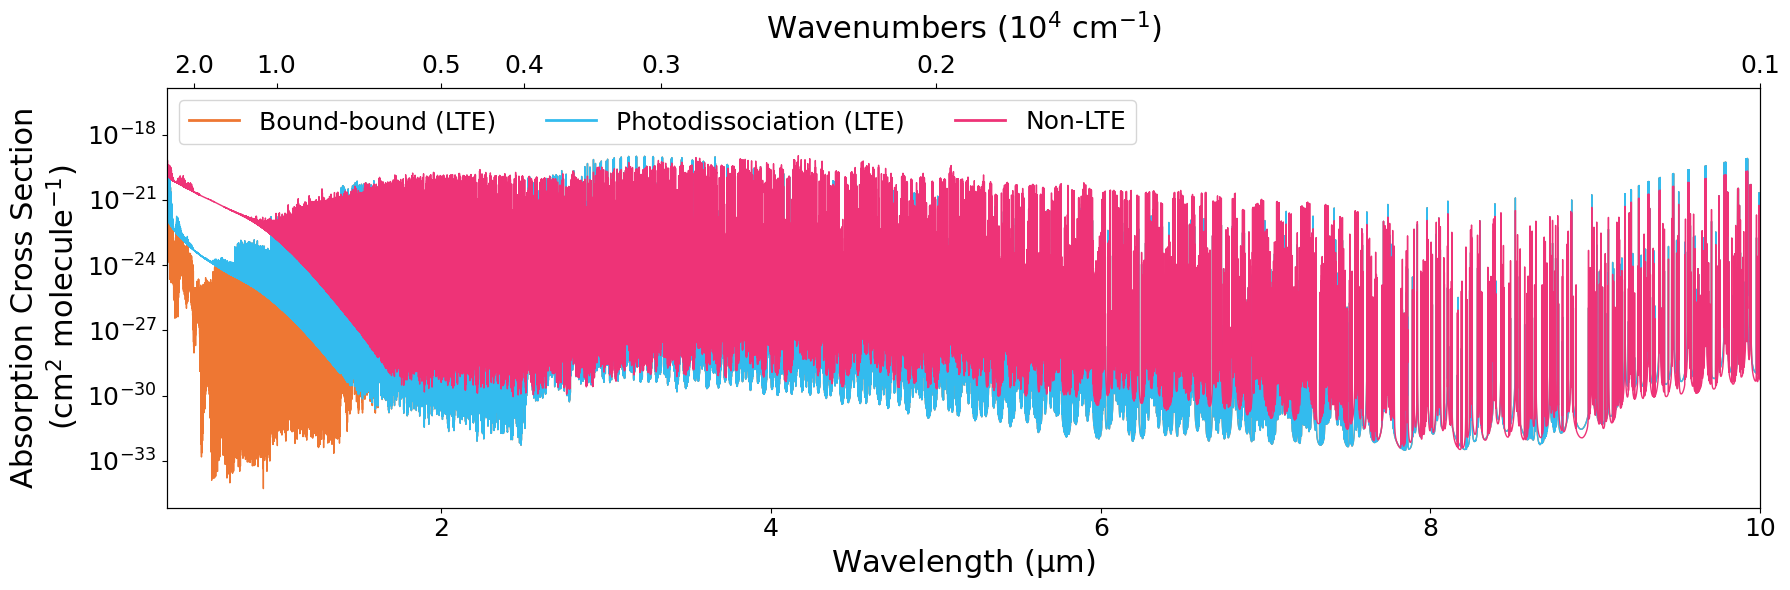

In [54]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 6))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength (${\rm \mu}$m)"
y_label = "Absorption Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(1e4 / lte_toa_xsec[:, 0], lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(1e4 / lte_cont_toa_xsec[:, 0], lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(1e4 / nlte_cont_toa_xsec[:, 0], nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
# plt.xlim(left=lte_toa_xsec[0, 0] / 1e4, right=lte_toa_xsec[-1, 0] / 1e4)
plt.xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)

plt.yscale("log")
# plt.ylim(bottom=1e-25, top=0)
legend = plt.legend(loc="upper left", fontsize=tick_fontsize, ncols=3)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_wl_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wn = plt.gca().twiny()
wn_tick_vals = [2.0, 1.0, 0.5, 0.4, 0.3, 0.2, 0.1]
new_tick_locations = [1 / x for x in wn_tick_vals]
ax_wn.set_xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
ax_wn.set_xlabel(x_label, fontsize=label_fontsize,
                 # fontweight="bold",
                 labelpad=10)
ax_wn.set_xticks(ticks=new_tick_locations, labels=wn_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_xsecs_old_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

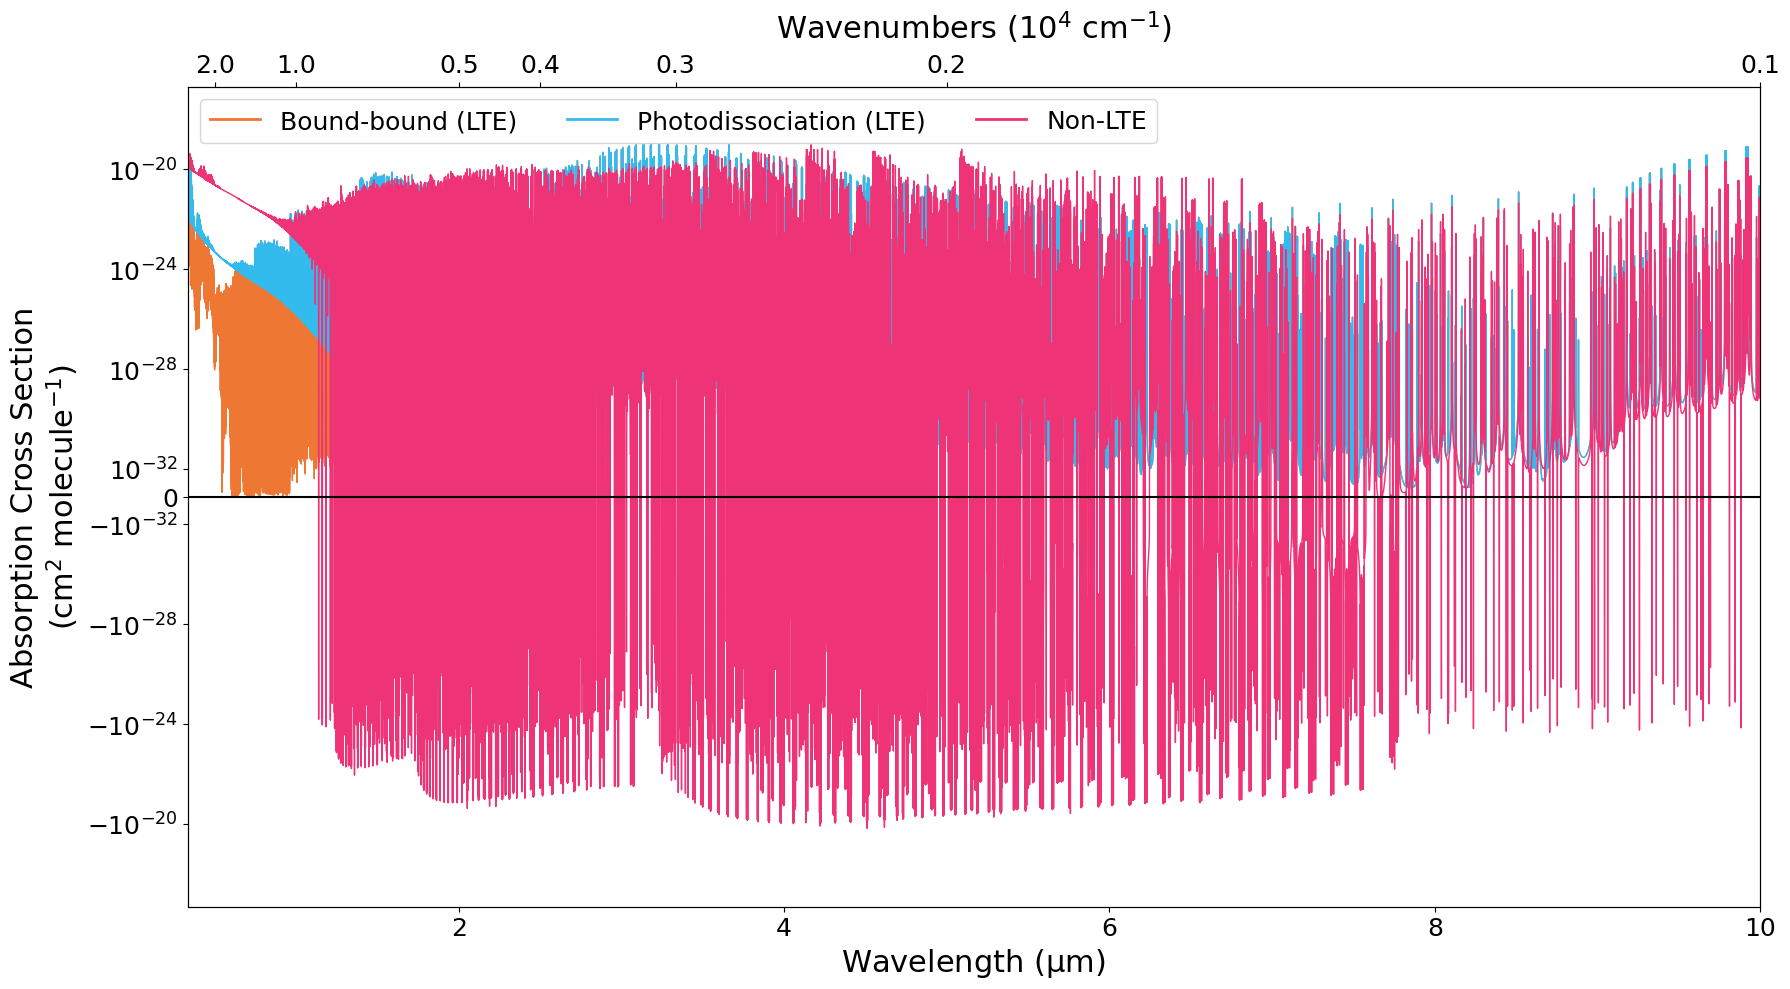

In [50]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_new3/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 10))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength (${\rm \mu}$m)"
y_label = "Absorption Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(1e4 / lte_toa_xsec[:, 0], lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(1e4 / lte_cont_toa_xsec[:, 0], lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(1e4 / nlte_cont_toa_xsec[:, 0], nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
# plt.xlim(left=lte_toa_xsec[0, 0] / 1e4, right=lte_toa_xsec[-1, 0] / 1e4)
plt.xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
ylim = plt.gca().get_ylim()
plt.ylim(bottom=-ylim[1], top=ylim[1])

plt.hlines(y=0, xmin=plt.gca().get_xlim()[0], xmax=plt.gca().get_xlim()[1], color="#000000", zorder=4)
plt.yscale("log")
plt.yscale("symlog", linthresh=1e-32)
# plt.ylim(bottom=1e-25, top=0)
legend = plt.legend(loc="upper left", fontsize=tick_fontsize, ncols=3)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_wl_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wn = plt.gca().twiny()
wn_tick_vals = [2.0, 1.0, 0.5, 0.4, 0.3, 0.2, 0.1]
new_tick_locations = [1 / x for x in wn_tick_vals]
ax_wn.set_xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
ax_wn.set_xlabel(x_label, fontsize=label_fontsize,
                 # fontweight="bold",
                 labelpad=10)
ax_wn.set_xticks(ticks=new_tick_locations, labels=wn_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_xsecs_new_wl.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

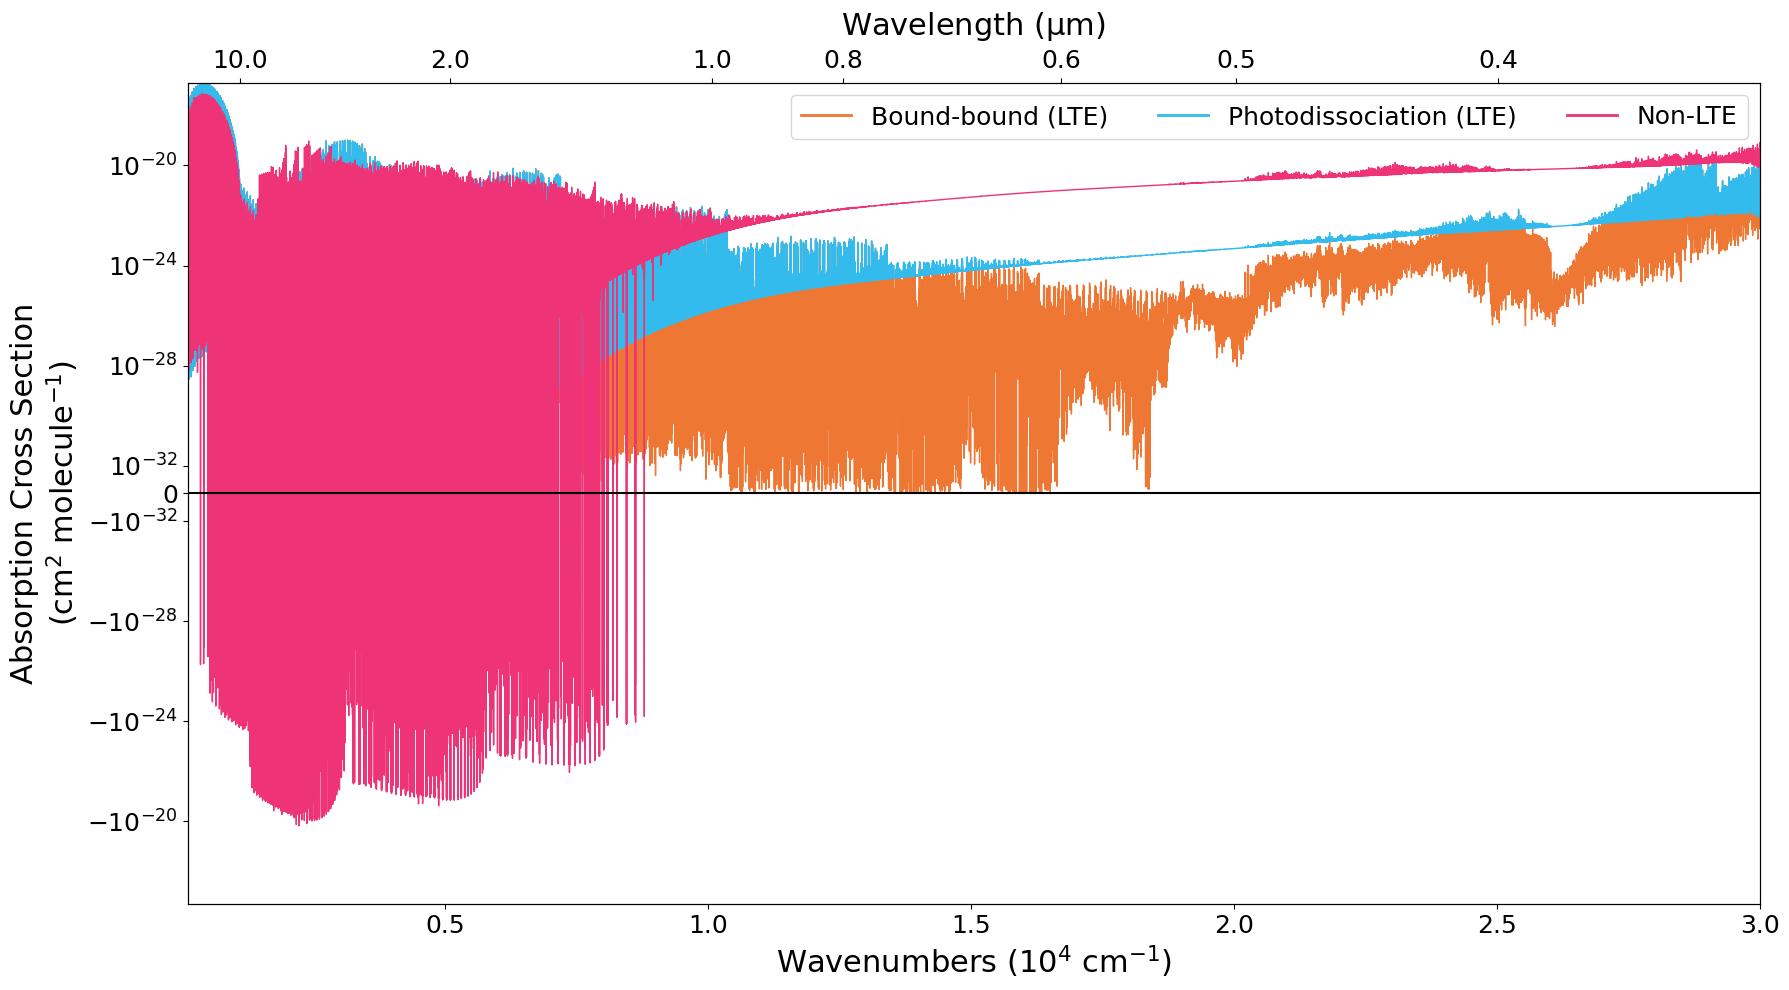

In [49]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_new3/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 10))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength (${\rm \mu}$m)"
y_label = "Absorption Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(lte_toa_xsec[:, 0] / 1e4, lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(lte_cont_toa_xsec[:, 0] / 1e4, lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(nlte_cont_toa_xsec[:, 0] / 1e4, nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
plt.xlim(left=lte_toa_xsec[0, 0] / 1e4, right=lte_toa_xsec[-1, 0] / 1e4)
ylim = plt.gca().get_ylim()
plt.ylim(bottom=-ylim[1], top=ylim[1])

plt.hlines(y=0, xmin=plt.gca().get_xlim()[0], xmax=plt.gca().get_xlim()[1], color="#000000", zorder=4)
plt.yscale("log")
plt.yscale("symlog", linthresh=1e-32)
# plt.ylim(bottom=1e-25, top=0)
legend = plt.legend(loc="best", fontsize=tick_fontsize, ncols=3)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=lte_toa_xsec[-1, 0] / 10000)
wl_tick_vals = [10.0, 2.0, 1.0, 0.8, 0.6, 0.5, 0.4]
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(x_wl_label, fontsize=label_fontsize,
                 # fontweight="bold",
                 labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_TOA_xsecs_new.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

199525.4890552815 J / (s sr um m2)


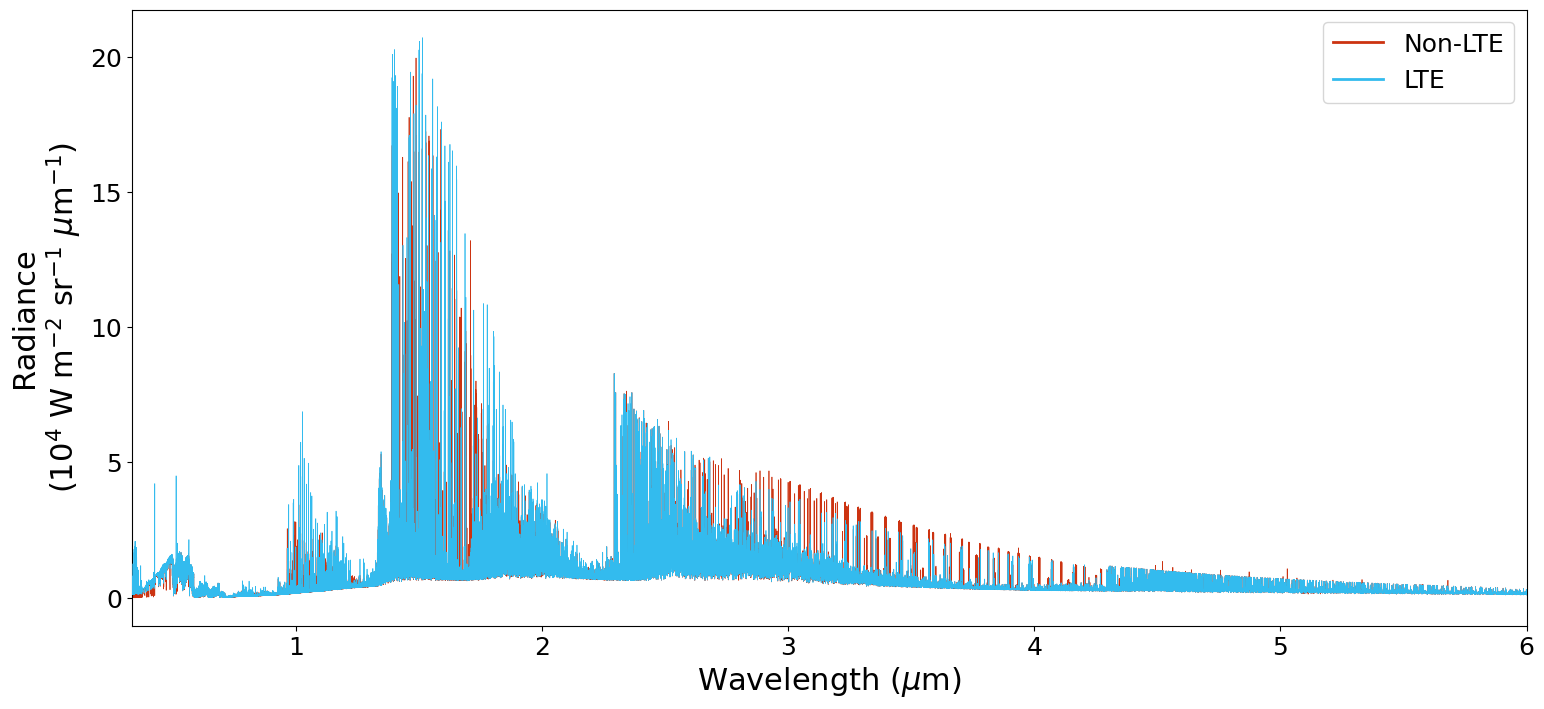

In [15]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
oh_scale = 1
bl = 20
lte_transmission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}_highres.txt")
nlte_transmission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt")
nlte_transmission_new = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs_new5/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt")

x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e4
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^{-2}$ sr$^{-1}$ ${\mu}$m$^{-1}$)"
line_width = 0.5
# line_width = 1.0

# figure_size = (15, 6)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size)
figure_size = (18, 8)
fig = plt.figure(figsize=figure_size)

plot_bl = 20
# plot_abundances = [0.1, 1, 10, 100, 1000]
plot_abundances = [1]
plot_colors = get_vibrant_colors(n_colors=len(plot_abundances), ordered=True)
for plot_idx, plot_abund in enumerate(plot_abundances):
    nlte_radiance_new = (
        nlte_transmission_new[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (nlte_transmission_new[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength_new = (nlte_transmission_new[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(nlte_wavelength_new, nlte_radiance_new / radiance_scale_factor, zorder=1, color="#CC3311",
             label=f"Non-LTE", linewidth=line_width)

    # nlte_radiance = (
    #     nlte_transmission[:, 1]
    #     * (u.J * u.m**-2)
    #     * (ac.c / (4 * np.pi * u.sr * (nlte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    # ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    # nlte_wavelength = (nlte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    # plt.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=2, color="#EE3377",
    #          label=f"Non-LTE", linewidth=line_width)
    lte_radiance = (
        lte_transmission[:, 1]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (lte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (lte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=3, color="#33BBEE",
             label=f"LTE", linewidth=line_width)

    # ax2.plot(lte_wavelength, (nlte_radiance_new - nlte_radiance) / radiance_scale_factor, linewidth=line_width)
    # ax2.plot(lte_wavelength, (nlte_radiance - lte_radiance) / radiance_scale_factor, linewidth=line_width)
    # print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")

# print(np.any(nlte_radiance_new > nlte_radiance))
print(nlte_radiance_new.max())

x_min = 1e4 / 30000
x_max = 6
plt.xlim(left=x_min, right=x_max)
# plt.ylim(bottom=-4, top=90)
plt.tick_params(axis="both", which="both", labelsize=tick_fontsize)
plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
legend = plt.legend(loc="upper right", fontsize=tick_fontsize)
plt.setp(legend.get_lines(), linewidth=2)

# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission_1xOH_old.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission_1xOH_old_zoom.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission_1xOH_new.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

(81, 85561)


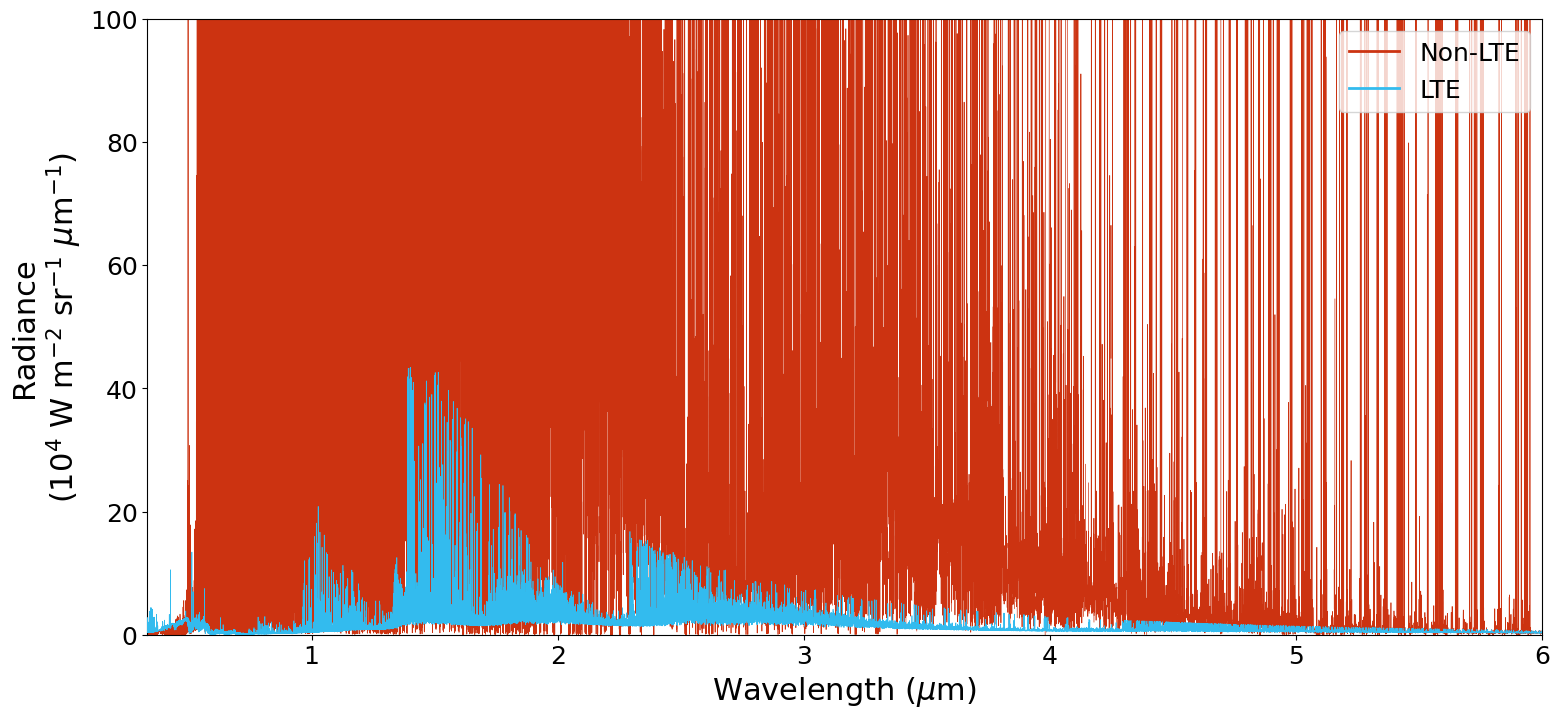

In [19]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
oh_scale = 1
bl = 20
# output_folder = "outputs_new5"
# output_folder = "outputs_new6"
# Use for outputs_new5:
# lte_emission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_LTE_intensity_up.txt")
# # nlte_transmission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt")
# nlte_emission_new = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_nLTE_intensity_up.txt")
#
# lte_wn_grid = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/outputs/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}.txt")[:, 0]
# nlte_wn_grid = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt")[:, 0]

# Use for outputs_new6:
# lte_emission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_LTE_intensity_up.txt")
# nlte_emission_new = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_nLTE_intensity_up.txt")
#
# lte_wn_grid = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_LTE_cont_{oh_scale}xOH_boundaryL{bl}.txt")[:, 0]
# wn_grid = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_cont_{oh_scale}xOH_boundaryL{bl}_transmission_highres.txt")[:, 0]

# outputs_working_simple_prec
# # output_folder = "outputs_working_simple_prec"
# output_folder = "outputs_working_full_prec"
# lte_emission = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_LTE_intensity_up.txt")
# nlte_emission_new = np.loadtxt(rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/KELT-20b_nLTE_intensity_up.txt")

# masing_test
output_folder = "masing_test"
lte_emission = np.loadtxt(rf"{root_dir}1xOH_bL20/outputs_working_full_prec/KELT-20b_LTE_intensity_up.txt")
print(lte_emission.shape)
nlte_emission_new = np.loadtxt(rf"{root_dir}masing_test/outputs/KELT-20b_nLTE_intensity_up.txt")

wn_grid = np.loadtxt(rf"{root_dir}1xOH_bL20/outputs_working_full_prec/KELT-20b_cont_1xOH_boundaryL20_transmission_highres.txt")[:, 0]

x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e4
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^{-2}$ sr$^{-1}$ ${\mu}$m$^{-1}$)"
line_width = 0.5
# line_width = 1.0

# figure_size = (15, 6)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size)
figure_size = (18, 8)
fig = plt.figure(figsize=figure_size)

plot_bl = 20
# plot_abundances = [0.1, 1, 10, 100, 1000]
plot_abundances = [1]
plot_colors = get_vibrant_colors(n_colors=len(plot_abundances), ordered=True)
for plot_idx, plot_abund in enumerate(plot_abundances):
    nlte_radiance_new_test = (
        nlte_emission_new[-1, :]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wl_new = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(nlte_wl_new, nlte_radiance_new_test / radiance_scale_factor, zorder=1, color="#CC3311",
             label=f"Non-LTE", linewidth=line_width)

    # nlte_radiance = (
    #     nlte_transmission[:, 1]
    #     * (u.J * u.m**-2)
    #     * (ac.c / (4 * np.pi * u.sr * (nlte_transmission[:, 0] * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    # ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    # nlte_wavelength = (nlte_transmission[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    # plt.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=2, color="#EE3377",
    #          label=f"Non-LTE", linewidth=line_width)
    lte_radiance = (
        lte_emission[-1, :]
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=3, color="#33BBEE",
             label=f"LTE", linewidth=line_width)

    # plt.plot(nlte_wl_new, 20 * nlte_radiance_new_test / nlte_radiance_new, color="#000000")

    # ax2.plot(lte_wavelength, (nlte_radiance_new - nlte_radiance) / radiance_scale_factor, linewidth=line_width)
    # ax2.plot(lte_wavelength, (nlte_radiance - lte_radiance) / radiance_scale_factor, linewidth=line_width)
    # print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")

# print(np.any(nlte_radiance_new > nlte_radiance))
# print(nlte_radiance_new.max())

x_min = 1e4 / 30000
x_max = 6
plt.xlim(left=x_min, right=x_max)
plt.ylim(bottom=0, top=1e2)
plt.tick_params(axis="both", which="both", labelsize=tick_fontsize)
plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
legend = plt.legend(loc="upper right", fontsize=tick_fontsize)
plt.setp(legend.get_lines(), linewidth=2)

# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission_1xOH_old.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_transmission_1xOH_old_zoom.png", dpi=600, transparent=True, bbox_inches="tight")
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_emission_1xOH.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [26]:
max_radiance = nlte_radiance_new_test[~np.isnan(nlte_radiance_new_test) & (nlte_radiance_new_test != np.inf)].max()
distance = 447 * u.lyr
distance = distance.to(u.m)
max_radiance / distance**2

<Quantity 1.38543321e+242 J / (s sr um m4)>

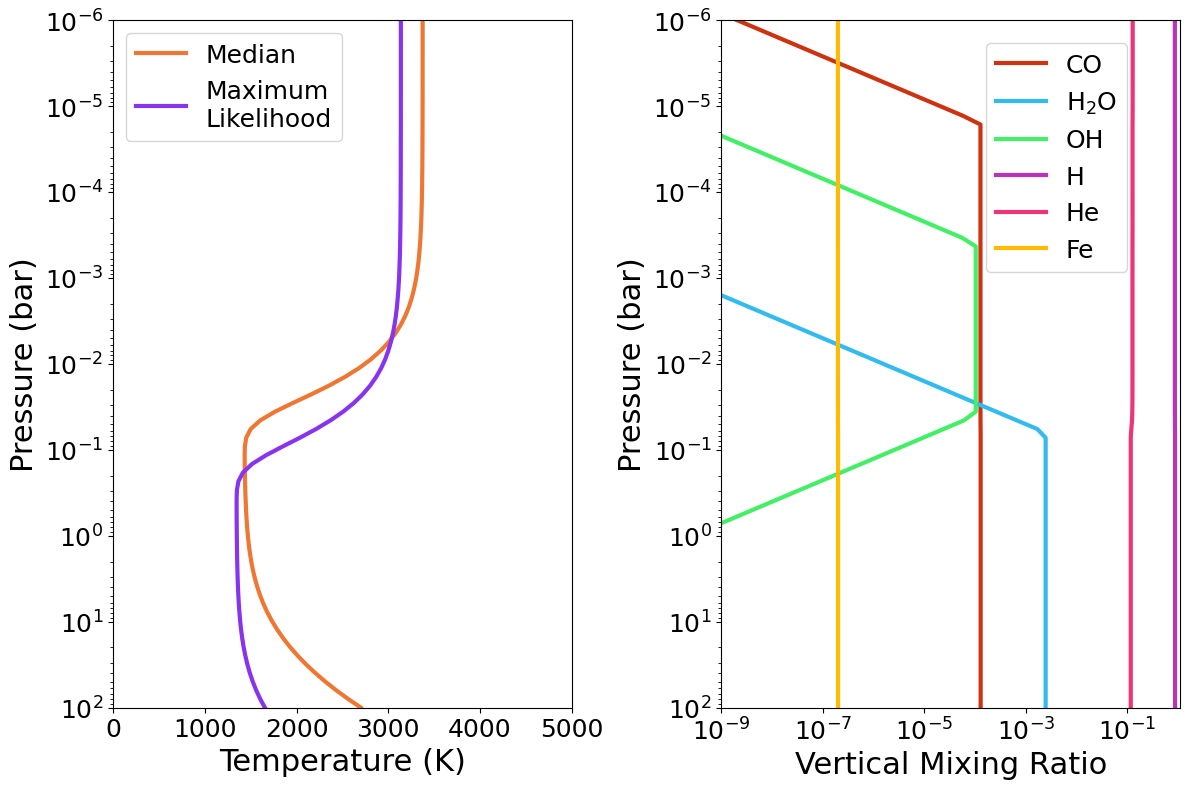

In [23]:
line_width = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax2.plot(co_vmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
ax2.plot(h2o_vmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
ax2.plot(oh_vmr, central_pressure, label="OH", color="#44EE66", linewidth=line_width)
ax2.plot(h_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
ax2.plot(he_vmr, central_pressure, label="He", color="#EE3377", linewidth=line_width)
ax2.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)

ax2.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
ax2.set_xscale("log")
ax2.set_xlim(left=1e-9, right=1.1)
ax2.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax2.set_yscale("log")
ax2.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax2.invert_yaxis()
ax2.tick_params(labelsize=tick_fontsize)
ax2.legend(loc="center", bbox_to_anchor=(0.73, 0.80), fontsize=tick_fontsize)

# ax3.plot(oh_vmr * 1e-1, central_pressure, label=r"OH $\times10^{-1}$", color="#0077BB", linewidth=line_width)
# ax3.plot(oh_vmr, central_pressure, label="OH", color="#229933", linewidth=line_width)
# ax3.plot(oh_vmr * 1e1, central_pressure, label=r"OH $\times10^{1}$", color="#EE3377", linewidth=line_width)
# ax3.plot(oh_vmr * 1e2, central_pressure, label=r"OH $\times10^{2}$", color="#44EE66", linewidth=line_width)
# ax3.plot(oh_vmr * 1e3, central_pressure, label=r"OH $\times10^{3}$", color="#8833EE", linewidth=line_width)
#
# ax3.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
# ax3.set_xscale("log")
# ax3.set_xlim(left=1e-9, right=1)
# ax3.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
# ax3.set_yscale("log")
# ax3.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
# ax3.invert_yaxis()
# ax3.tick_params(labelsize=tick_fontsize)
# ax3.legend(loc="best", fontsize=tick_fontsize)

ax1.plot(temperature_profile, central_pressure, label="Median", color="#EE7733", linewidth=line_width)
ax1.plot(temperature_profile_maxl, central_pressure, label="Maximum\nLikelihood", color="#8833EE", linewidth=line_width)

ax1.set_xlabel("Temperature (K)", fontsize=label_fontsize)
ax1.set_xlim(left=0, right=5000)
ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax1.set_yscale("log")
ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax1.invert_yaxis()
ax1.tick_params(labelsize=tick_fontsize)
ax1.legend(loc="best", fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/Figures/KELT-20b_profiles_fixed.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

[7.59489590e-01 1.78191027e-01 4.49237493e-02 1.22751625e-02
 3.51093701e-03 1.06787276e-03 3.41980447e-04 1.20151236e-04
 4.82608676e-05 2.16468739e-05 9.62265600e-06]
[7.59513203e-01 1.78177301e-01 4.49179436e-02 1.22727367e-02
 3.50991876e-03 1.06753846e-03 3.41814906e-04 1.20068871e-04
 4.82296419e-05 2.16296113e-05 9.61509295e-06]


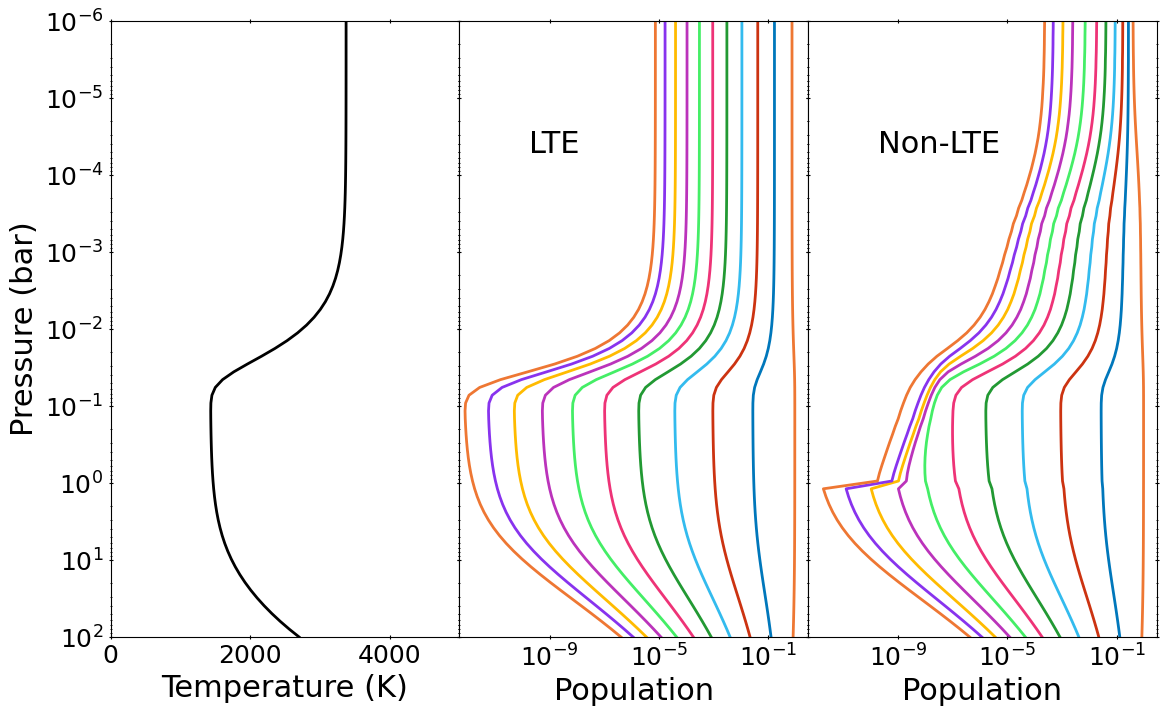

In [8]:
line_width = 2
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 8))

max_v = 10
plot_colors = get_vibrant_colors(max_v + 1)

# for v_val in range(0, max_v + 1):
#     ax1.plot(x1OH_bL20_pop_matrix[0, :, v_val], central_pressure, color=plot_colors[v_val], linewidth=line_width, linestyle="-", label="LTE")
#     ax1.set_xscale("log")
#     ax1.set_yscale("log")
#     ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
#     ax1.invert_yaxis()
#     ax1.tick_params(labelsize=tick_fontsize)
#     ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)


# x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_new6/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_working_simple_prec/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
print(x1OH_bL20_pop_matrix[-1, 50, :11])
x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_working_full_prec/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
print(x1OH_bL20_pop_matrix[-1, 50, :11])

nlte_axs = [ax2, ax3]
plot_pops = [x1OH_bL20_pop_matrix, x1OH_bL20_pop_matrix]
# plot_labels = ["LTE", "Non-LTE"]


ax1.plot(temperature_profile, central_pressure, label="Median", color="#000000", linewidth=line_width)
# ax1.plot(temperature_profile_maxl, central_pressure, label="Maximum\nLikelihood", color="#8833EE", linewidth=line_width)
ax1.set_yscale("log")
ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax1.set_xlim(left=0, right=5000)
ax1.invert_yaxis()
ax1.set_xlabel("Temperature (K)", fontsize=label_fontsize)
ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax1.tick_params(which="both", labelsize=tick_fontsize, direction="inout", bottom=True, top=True, left=True, right=True)

x_min, x_max = 5e-13, 3e0
for ax_idx, plot_ax in enumerate(nlte_axs):
    plot_pop = plot_pops[ax_idx]
    plot_iter = 0 if ax_idx == 0 else -1
    for v_val in range(0, max_v + 1):
        plot_ax.plot(plot_pop[plot_iter, :, v_val], central_pressure, label=f"v={v_val}", color=plot_colors[v_val], linewidth=line_width, linestyle="-")
        # plot_ax.plot(plot_pop[0, :, v_val], central_pressure, color=plot_colors[v_val] + "44", linewidth=line_width/2, linestyle="-", label="LTE")
    plot_ax.set_xscale("log")
    plot_ax.set_xlim(left=x_min, right=x_max)
    plot_ax.set_yscale("log")
    plot_ax.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
    plot_ax.invert_yaxis()
    plot_ax.tick_params(which="both", labelsize=tick_fontsize, direction="inout", bottom=True, top=True, left=True, right=True)
    if ax_idx == 0:
        plot_ax.text(0.2, 0.8, "LTE", ha="left", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )
    else:
        plot_ax.text(0.2, 0.8, f"Non-LTE", ha="left", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )

    # if ax_idx == 1:
    #     h2_dissociation_pressure = 10 ** -1.6 << u.bar
    #     plot_ax.hlines(xmin=x_min, xmax=x_max, y=h2_dissociation_pressure.value)

    # if ax_idx <=2:
    #     plot_ax.tick_params(axis="x", which="both", labelbottom=False)
    # elif ax_idx == 4:
    plot_ax.set_xlabel("Population", fontsize=label_fontsize)

    # if ax_idx % 3 != 0:
    plot_ax.tick_params(axis="y", which="both", labelleft=False, labelsize=tick_fontsize)
    # elif ax_idx == 0:
        # y_ticks = plot_ax.get_yticks()
        # y_ticks = y_ticks[1:-2]
        # plot_ax.set_yticks(y_ticks)
        # plot_ax.set_ylabel("Pressure (bar)", fontsize=label_fontsize, y=central_pressure[-1].value)


plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/KELT-20b_populations_single.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [17]:
profiles = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_med.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
central_pressure = 10 ** profiles["logP"].to_numpy()[::-1] << u.bar
pressure_levels = (
    np.loadtxt(r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl_fit_pressure_levels.txt") << u.bar
)
temperature_profile = profiles["T"].to_numpy()[::-1] << u.K

co_mmr = 10 ** profiles["logCO"].to_numpy()[::-1]
h2o_mmr = 10 ** profiles["logH2O"].to_numpy()[::-1]
oh_mmr = 10 ** profiles["logOH"].to_numpy()[::-1]
oh_scale_factor = 1
oh_mmr *= oh_scale_factor
fe_mmr = 10 ** profiles["logFe"].to_numpy()[::-1]

mass_h = 1.00782503223
mass_h2 = 2 * mass_h
mass_he = 4.00260325413
mass_o = 15.99491461957
mass_co = 12 + mass_o
mass_h2o = 2*mass_h + mass_o
mass_oh = mass_o + mass_h
mass_fe = 55.93493632600

h_total_mmr = 10 ** (-0.2) # Median
h2_mmr = np.repeat(h_total_mmr, len(profiles))
h2_dissociation_pressure = 10 ** + 0.2 << u.bar
h2_dissociation_logic = central_pressure < h2_dissociation_pressure
h2_mmr[h2_dissociation_logic] = h2_mmr[h2_dissociation_logic] * (central_pressure[h2_dissociation_logic] / h2_dissociation_pressure) ** 4
h_mmr = np.repeat(h_total_mmr, len(profiles)) - h2_mmr
he_mmr = np.ones_like(h2_mmr) - h2_mmr - h_mmr - co_mmr - h2o_mmr - oh_mmr - fe_mmr
he_mmr[he_mmr < 0] = 0
sum_mmr = he_mmr + h2_mmr + h_mmr + co_mmr + h2o_mmr + oh_mmr + fe_mmr
he_mmr /= sum_mmr
h2_mmr /= sum_mmr
h_mmr /= sum_mmr
co_mmr /= sum_mmr
h2o_mmr /= sum_mmr
oh_mmr /= sum_mmr
fe_mmr /= sum_mmr

h2_rmmr = h2_mmr / mass_h2
h_rmmr = h_mmr / mass_h
he_rmmr = he_mmr / mass_he
co_rmmr = co_mmr / mass_co
h2o_rmmr = h2o_mmr / mass_h2o
oh_rmmr = oh_mmr / mass_oh
fe_rmmr = fe_mmr / mass_fe

# hydrogen_vmr = 10 ** (-0.2)
# hydrogen_vmr = h_mmr / mass_h

# hydrogen_vmr = np.repeat(hydrogen_vmr, len(central_pressure))

# he_vmr = np.ones_like(hydrogen_vmr) - hydrogen_vmr - co_vmr - h2o_vmr - oh_vmr - fe_vmr

sum_rmmr = sum([h2_rmmr, h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr, fe_rmmr])
h2_vmr = h2_rmmr / sum_rmmr
h_vmr = h_rmmr / sum_rmmr
he_vmr = he_rmmr / sum_rmmr
co_vmr = co_rmmr / sum_rmmr
h2o_vmr = h2o_rmmr / sum_rmmr
oh_vmr = oh_rmmr / sum_rmmr
fe_vmr = fe_rmmr / sum_rmmr

profiles_maxl = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
temperature_profile_maxl = profiles_maxl["T"].to_numpy()[::-1] << u.K

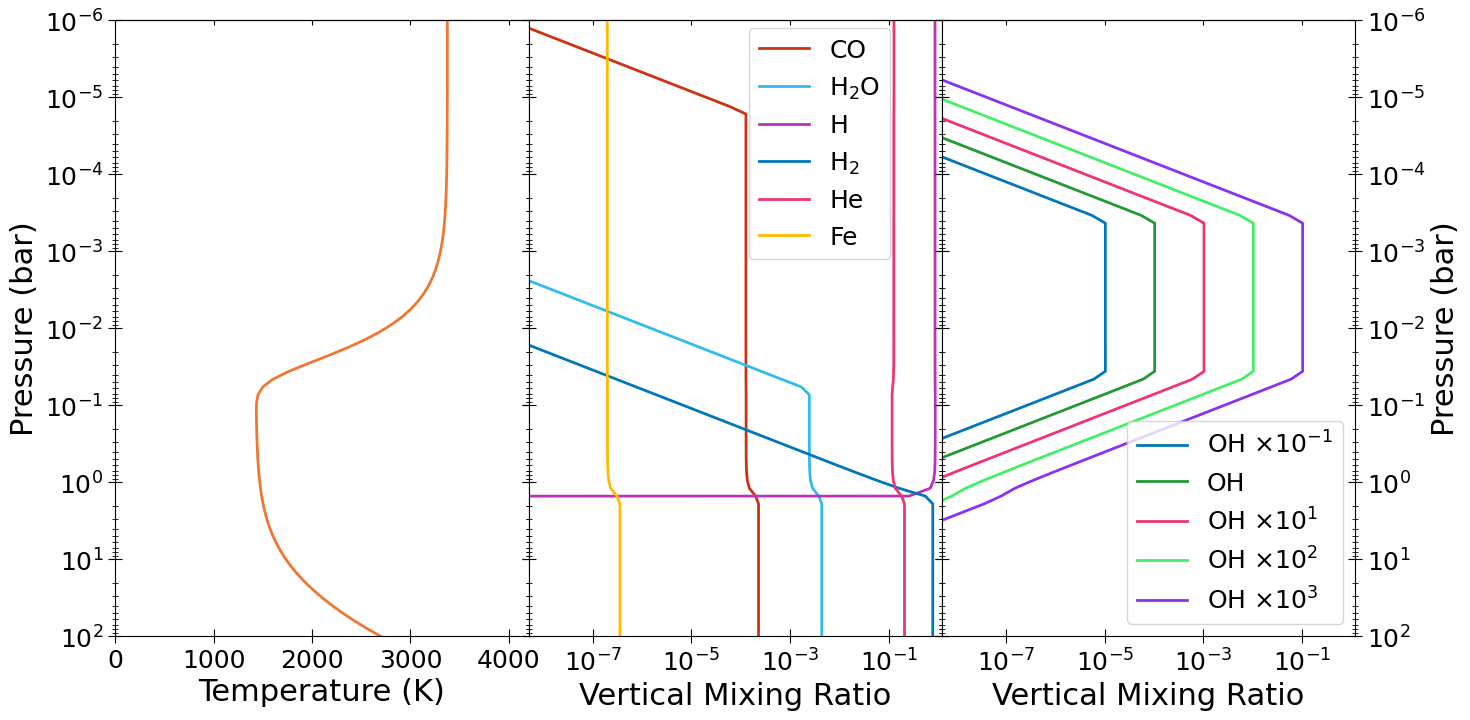

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
line_width = 2

# h_total_mmr = 0.5
# h2_mmr = np.repeat(h_total_mmr, len(profiles))
# h2_dissociation_pressure = 10 ** -1.6 << u.bar
# h2_dissociation_logic = central_pressure < h2_dissociation_pressure
# h2_mmr[h2_dissociation_logic] = h2_mmr[h2_dissociation_logic] * (central_pressure[h2_dissociation_logic] / h2_dissociation_pressure) ** 4
# h_mmr = np.repeat(h_total_mmr, len(profiles)) - h2_mmr
# oh_mmr = np.repeat(0.4, len(profiles))
# he_mmr = np.ones_like(h2_mmr) - h2_mmr - h_mmr - oh_mmr
#
# h2_rmmr = h2_mmr / mass_h2
# h_rmmr = h_mmr / mass_h
# oh_rmmr = oh_mmr / mass_oh
# sum_rmmr = sum([h2_rmmr, h_rmmr, he_rmmr, oh_rmmr])
# h2_vmr = h2_rmmr / sum_rmmr
# h_vmr = h_rmmr / sum_rmmr
# he_vmr = he_rmmr / sum_rmmr
# oh_vmr = oh_rmmr / sum_rmmr

major_ticksize = 10
minor_ticksize = 5

ax1.plot(temperature_profile, central_pressure, label="Median", color="#EE7733", linewidth=line_width)
# ax1.plot(temperature_profile_maxl, central_pressure, label="Maximum\nLikelihood", color="#8833EE", linewidth=line_width)

ax1.set_xlabel("Temperature (K)", fontsize=label_fontsize)
ax1.set_xlim(left=0, right=4200)
ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax1.set_yscale("log")
ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax1.invert_yaxis()

ax1.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="inout", bottom=True, top=False)
ax1_top = ax1.secondary_xaxis("top")
ax1_top.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="in", bottom=False, top=True, labeltop=False)
ax1.tick_params(which="both", axis="y", labelsize=tick_fontsize, direction="inout", left=True, right=True)
ax1.tick_params(which="major", length=major_ticksize)
ax1.tick_params(which="minor", length=minor_ticksize)
# ax1.legend(loc="best", fontsize=tick_fontsize)

ax2.plot(co_vmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
ax2.plot(h2o_vmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
# ax2.plot(oh_vmr, central_pressure, label="OH", color="#44EE66", linewidth=line_width)
ax2.plot(h_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
ax2.plot(h2_vmr, central_pressure, label="H$_{2}$", color="#0077BB", linewidth=line_width)
ax2.plot(he_vmr, central_pressure, label="He", color="#EE3377", linewidth=line_width)
ax2.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)

ax2.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
ax2.set_xscale("log")
ax2.set_xlim(left=5e-9, right=1.2)
# ax2.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax2.set_yscale("log")
ax2.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax2.invert_yaxis()
ax2.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="inout", bottom=True, top=False)
ax2_top = ax2.secondary_xaxis("top")
ax2_top.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="in", bottom=False, top=True, labeltop=False)
ax2.tick_params(which="both", axis="y", labelsize=tick_fontsize, direction="inout", left=True, right=True, labelleft=False)
ax2.tick_params(which="major", length=major_ticksize)
ax2.tick_params(which="minor", length=minor_ticksize)
ax2.legend(loc="center", bbox_to_anchor=(0.705, 0.80), fontsize=tick_fontsize)

ax3.plot(oh_vmr * 1e-1, central_pressure, label=r"OH $\times10^{-1}$", color="#0077BB", linewidth=line_width)
ax3.plot(oh_vmr, central_pressure, label="OH", color="#229933", linewidth=line_width)
ax3.plot(oh_vmr * 1e1, central_pressure, label=r"OH $\times10^{1}$", color="#EE3377", linewidth=line_width)
ax3.plot(oh_vmr * 1e2, central_pressure, label=r"OH $\times10^{2}$", color="#44EE66", linewidth=line_width)
ax3.plot(oh_vmr * 1e3, central_pressure, label=r"OH $\times10^{3}$", color="#8833EE", linewidth=line_width)

ax3.set_xlabel("Vertical Mixing Ratio", fontsize=label_fontsize)
ax3.set_xscale("log")
ax3.set_xlim(left=5e-9, right=1.2)
ax3.set_ylabel("Pressure (bar)", fontsize=label_fontsize)
ax3.yaxis.set_label_position("right")
ax3.set_yscale("log")
ax3.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
ax3.invert_yaxis()
ax3.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="inout", bottom=True, top=False)
ax3_top = ax3.secondary_xaxis("top")
ax3_top.tick_params(which="both", axis="x", labelsize=tick_fontsize, direction="in", bottom=False, top=True, labeltop=False)
ax3.tick_params(which="both", axis="y", labelsize=tick_fontsize, direction="inout", left=True, right=True, labelleft=False, labelright=True)
ax3.tick_params(which="major", length=major_ticksize)
ax3.tick_params(which="minor", length=minor_ticksize)
ax3.legend(loc="best", fontsize=tick_fontsize)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/Figures/paper/KELT-20b_profiles.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [3]:
x1000OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x100OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x10OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x01OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
print(x1OH_bL20_pop_matrix[0])

[[8.41706217e-01 1.30834965e-01 2.22403058e-02 ... 1.34973557e-30
  6.90092126e-31 2.11275278e-31]
 [8.57521035e-01 1.20127710e-01 1.84919887e-02 ... 3.17200421e-32
  1.60596325e-32 4.87135105e-33]
 [8.72152244e-01 1.09763558e-01 1.52552198e-02 ... 6.61864298e-34
  3.31698374e-34 9.96517920e-35]
 ...
 [7.67116360e-01 1.74457835e-01 4.26325152e-02 ... 1.16423443e-24
  6.16492425e-25 1.95175108e-25]
 [7.67113852e-01 1.74459112e-01 4.26332582e-02 ... 1.16467565e-24
  6.16726653e-25 1.95249443e-25]
 [7.67111865e-01 1.74460124e-01 4.26338466e-02 ... 1.16502522e-24
  6.16912227e-25 1.95308337e-25]]


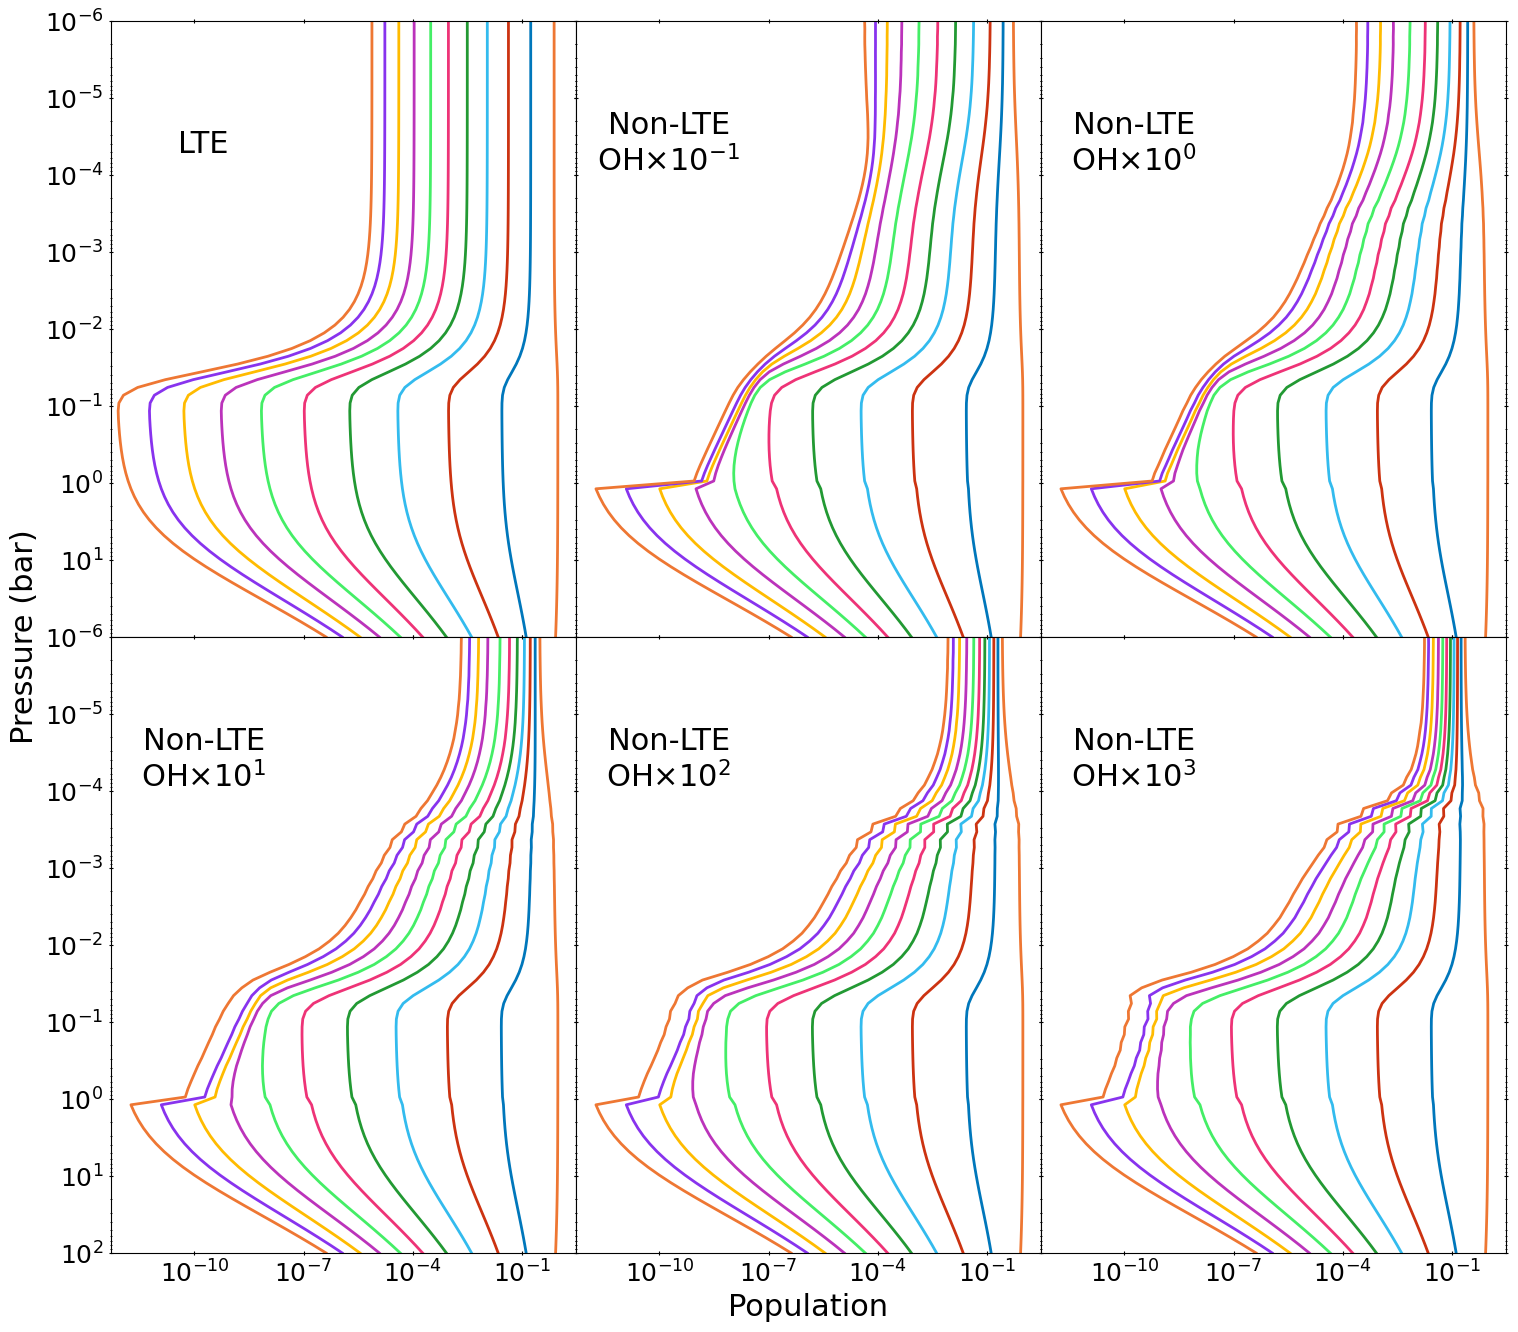

In [4]:
line_width = 2
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 16))

max_v = 10
plot_colors = get_vibrant_colors(max_v + 1)

# for v_val in range(0, max_v + 1):
#     ax1.plot(x1OH_bL20_pop_matrix[0, :, v_val], central_pressure, color=plot_colors[v_val], linewidth=line_width, linestyle="-", label="LTE")
#     ax1.set_xscale("log")
#     ax1.set_yscale("log")
#     ax1.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
#     ax1.invert_yaxis()
#     ax1.tick_params(labelsize=tick_fontsize)
#     ax1.set_ylabel("Pressure (bar)", fontsize=label_fontsize)

nlte_axs = [ax1, ax2, ax3, ax4, ax5, ax6]
plot_pops = [x1OH_bL20_pop_matrix, x01OH_bL20_pop_matrix, x1OH_bL20_pop_matrix, x10OH_bL20_pop_matrix, x100OH_bL20_pop_matrix, x1000OH_bL20_pop_matrix]
plot_labels = ["LTE", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$"]

for ax_idx, plot_ax in enumerate(nlte_axs):
    plot_pop = plot_pops[ax_idx]
    plot_iter = 0 if ax_idx == 0 else -1
    for v_val in range(0, max_v + 1):
        plot_ax.plot(plot_pop[plot_iter, :, v_val], central_pressure, label=f"v={v_val}", color=plot_colors[v_val], linewidth=line_width, linestyle="-")
        # plot_ax.plot(plot_pop[0, :, v_val], central_pressure, color=plot_colors[v_val] + "44", linewidth=line_width/2, linestyle="-", label="LTE")
    plot_ax.set_xscale("log")
    plot_ax.set_xlim(left=5e-13, right=3e0)
    plot_ax.set_yscale("log")
    plot_ax.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
    plot_ax.invert_yaxis()
    plot_ax.tick_params(which="both", labelsize=tick_fontsize, direction="inout", bottom=True, top=True, left=True, right=True)
    if ax_idx == 0:
        plot_ax.text(0.2, 0.8, "LTE", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )
    else:
        plot_ax.text(0.2, 0.8, f"Non-LTE\nOH$\\times10^{{{int(ax_idx - 2)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )

    if ax_idx <=2:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False)
    elif ax_idx == 4:
        plot_ax.set_xlabel("Population", fontsize=label_fontsize)

    if ax_idx % 3 != 0:
        plot_ax.tick_params(axis="y", which="both", labelleft=False)
    elif ax_idx == 0:
        y_ticks = plot_ax.get_yticks()
        y_ticks = y_ticks[1:-2]
        plot_ax.set_yticks(y_ticks)
        plot_ax.set_ylabel("Pressure (bar)", fontsize=label_fontsize, y=central_pressure[-1].value)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_populations.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

Ratio = 3.89993573471128
Ratio = 4.887459931698612
Ratio = 6.245556851836171
Ratio = 8.071520590107138
Ratio = 10.381637265529525
Ratio = 13.375313463543188
Ratio = 17.197641528329324
Ratio = 21.984753998330188
Ratio = 28.0749654387913
Ratio = 35.58785863655278
Ratio = 43.639034998494786
Ratio = 46.38148292528349
Ratio = 34.71746256803917
Ratio = 15.853110913207036
Ratio = 5.44076012271244
Ratio = 2.197104963250432
Ratio = 1.2811558869310637
Ratio = 0.9941915382837938
Ratio = 0.883096839094971
Ratio = 0.8372970390495158
Ratio = 0.8147317010809701
Ratio = 0.8082077313937037
Ratio = 0.8080835960769845
Ratio = 0.815392259955026
Ratio = 0.8297016263585223
Ratio = 0.8482120931556909
Ratio = 0.8767590936489704
Ratio = 0.9084582734340975
Ratio = 0.9550303848966628
Ratio = 1.0049897688301177
Ratio = 1.074952068148181
Ratio = 1.1498167472806236
Ratio = 1.24964976599103
Ratio = 1.3549976120911051
Ratio = 1.49952406577936
Ratio = 1.6453592690968573
Ratio = 1.8298104730857092
Ratio = 2.01573057250

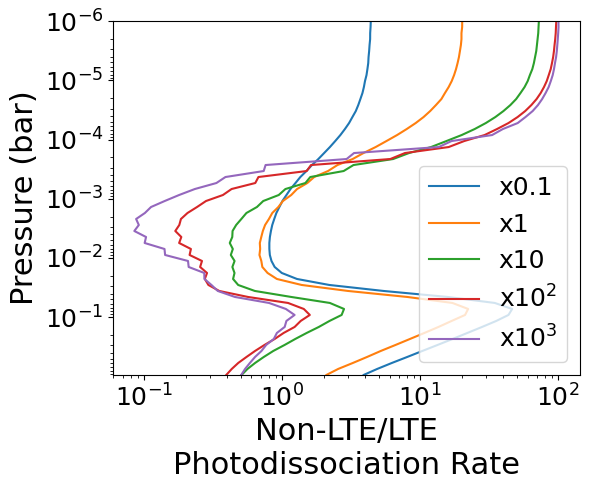

In [86]:
ac_2_h_on_c_sq = 2 * ac.h / ac.c**2
ac_h_on_kB = ac.h / ac.k_B

planet_mass = 3.372 << u.Mjup
planet_radius = 1.83 << u.Rjup
star_temperature = 8730 << u.K
orbital_radius = 0.057 << u.AU


def xsec_to_rate(xsec: npt.NDArray[np.float64], intensity: u.Quantity) -> u.Quantity:
    wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    intensity_field = intensity * ac.c / (wl_grid ** 2)
    intensity_field = intensity_field.to(u.J / (u.s * u.cm**2 * u.um), equivalencies=u.spectral())
    intensity_field = intensity_field / (ac.h * ac.c / wl_grid)
    intensity_field = intensity_field.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
    product = intensity_field * (xsec[:, 1] * u.cm**2)
    rate = simpson(product[::-1], x=wl_grid.value[::-1])
    return rate


root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
# model_dir = f"{root_dir}1xOH_bL20/outputs_working_full_prec/"
# model_dirs = [f"{root_dir}0.1xOH_bL20/outputs/", f"{root_dir}1xOH_bL20/outputs_working_full_prec/", f"{root_dir}10xOH_bL20/outputs/", f"{root_dir}100xOH_bL20/outputs/", f"{root_dir}1000xOH_bL20/outputs/"]
model_dirs = [f"{root_dir}0.1xOH_bL20/outputs2/", f"{root_dir}1xOH_bL20/outputs2/", f"{root_dir}10xOH_bL20/outputs2/", f"{root_dir}100xOH_bL20/outputs2/", f"{root_dir}1000xOH_bL20/outputs2/"]
model_labels = ["x0.1", "x1", "x10", "x10$^{2}$", "x10$^{3}$"]
# model_dir = f"{root_dir}100xOH_bL20/outputs/"

plt.figure(figsize=(6, 5))

for model_idx, model_dir in enumerate(model_dirs):
    rate_ratios = []
    # plot_temps = np.concatenate(([300], np.linspace(2000, 10000, 5)))
    # plot_ratios = [[] for _ in plot_temps]
    lte_intensity_up = np.loadtxt(f"{model_dir}KELT-20b_LTE_intensity_up.txt")
    lte_intensity_down = np.loadtxt(f"{model_dir}KELT-20b_LTE_intensity_down.txt")
    nlte_intensity_up = np.loadtxt(f"{model_dir}KELT-20b_nLTE_intensity_up.txt")
    nlte_intensity_down = np.loadtxt(f"{model_dir}KELT-20b_nLTE_intensity_down.txt")

    lte_intensity = (lte_intensity_up + lte_intensity_down) << (u.J / u.m**2)
    nlte_intensity = (nlte_intensity_up + nlte_intensity_down) << (u.J / u.m**2)

    for layer_idx in range(20, 80):
        nlte_file = glob.glob(f"KELT-20b_nLTE_cont_L{layer_idx}*.txt", root_dir=model_dir)[0]
        lte_file = glob.glob(f"KELT-20b_LTE_cont_L{layer_idx}*.txt", root_dir=model_dir)[0]
        nlte_cont_xsec = np.loadtxt(f"{model_dir}{nlte_file}")
        lte_cont_xsec = np.loadtxt(f"{model_dir}{lte_file}")
        # for plot_idx, plot_temp in enumerate(plot_temps):
        #     nlte_rate = xsec_to_rate(nlte_cont_xsec, plot_temp)
        #     lte_rate = xsec_to_rate(lte_cont_xsec, plot_temp)
        #     # print(f"NLTE rate = {nlte_rate}")
        #     # print(f"LTE rate = {lte_rate}")
        #     rate_ratio = nlte_rate/lte_rate
        #     plot_ratios[plot_idx].append(rate_ratio)
        nlte_rate = xsec_to_rate(nlte_cont_xsec, nlte_intensity[layer_idx + 1])
        lte_rate = xsec_to_rate(lte_cont_xsec, lte_intensity[layer_idx + 1])
        rate_ratio = nlte_rate/lte_rate
        print(f"Ratio = {rate_ratio}")
        rate_ratios.append(rate_ratio)

    # for plot_idx, plot_temp in enumerate(plot_temps):
    #     plt.plot(plot_ratios[plot_idx], central_pressure[20:], label=f"T$_{{*}}$={plot_temp} K")
    plt.plot(rate_ratios, central_pressure[20:], label=model_labels[model_idx])
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
plt.xlabel("Non-LTE/LTE\nPhotodissociation Rate", fontsize=label_fontsize,
           #fontweight="bold"
           )
plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/OH_photodissociation_rate.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

OHx0.1 radiance scale NLTE/LTE = 0.9997724492645562
OHx1 radiance scale NLTE/LTE = 1.0044589121263865
OHx10 radiance scale NLTE/LTE = 1.0236538406360887
OHx100 radiance scale NLTE/LTE = 0.9678781041107439
OHx1000 radiance scale NLTE/LTE = 0.9173300808133601


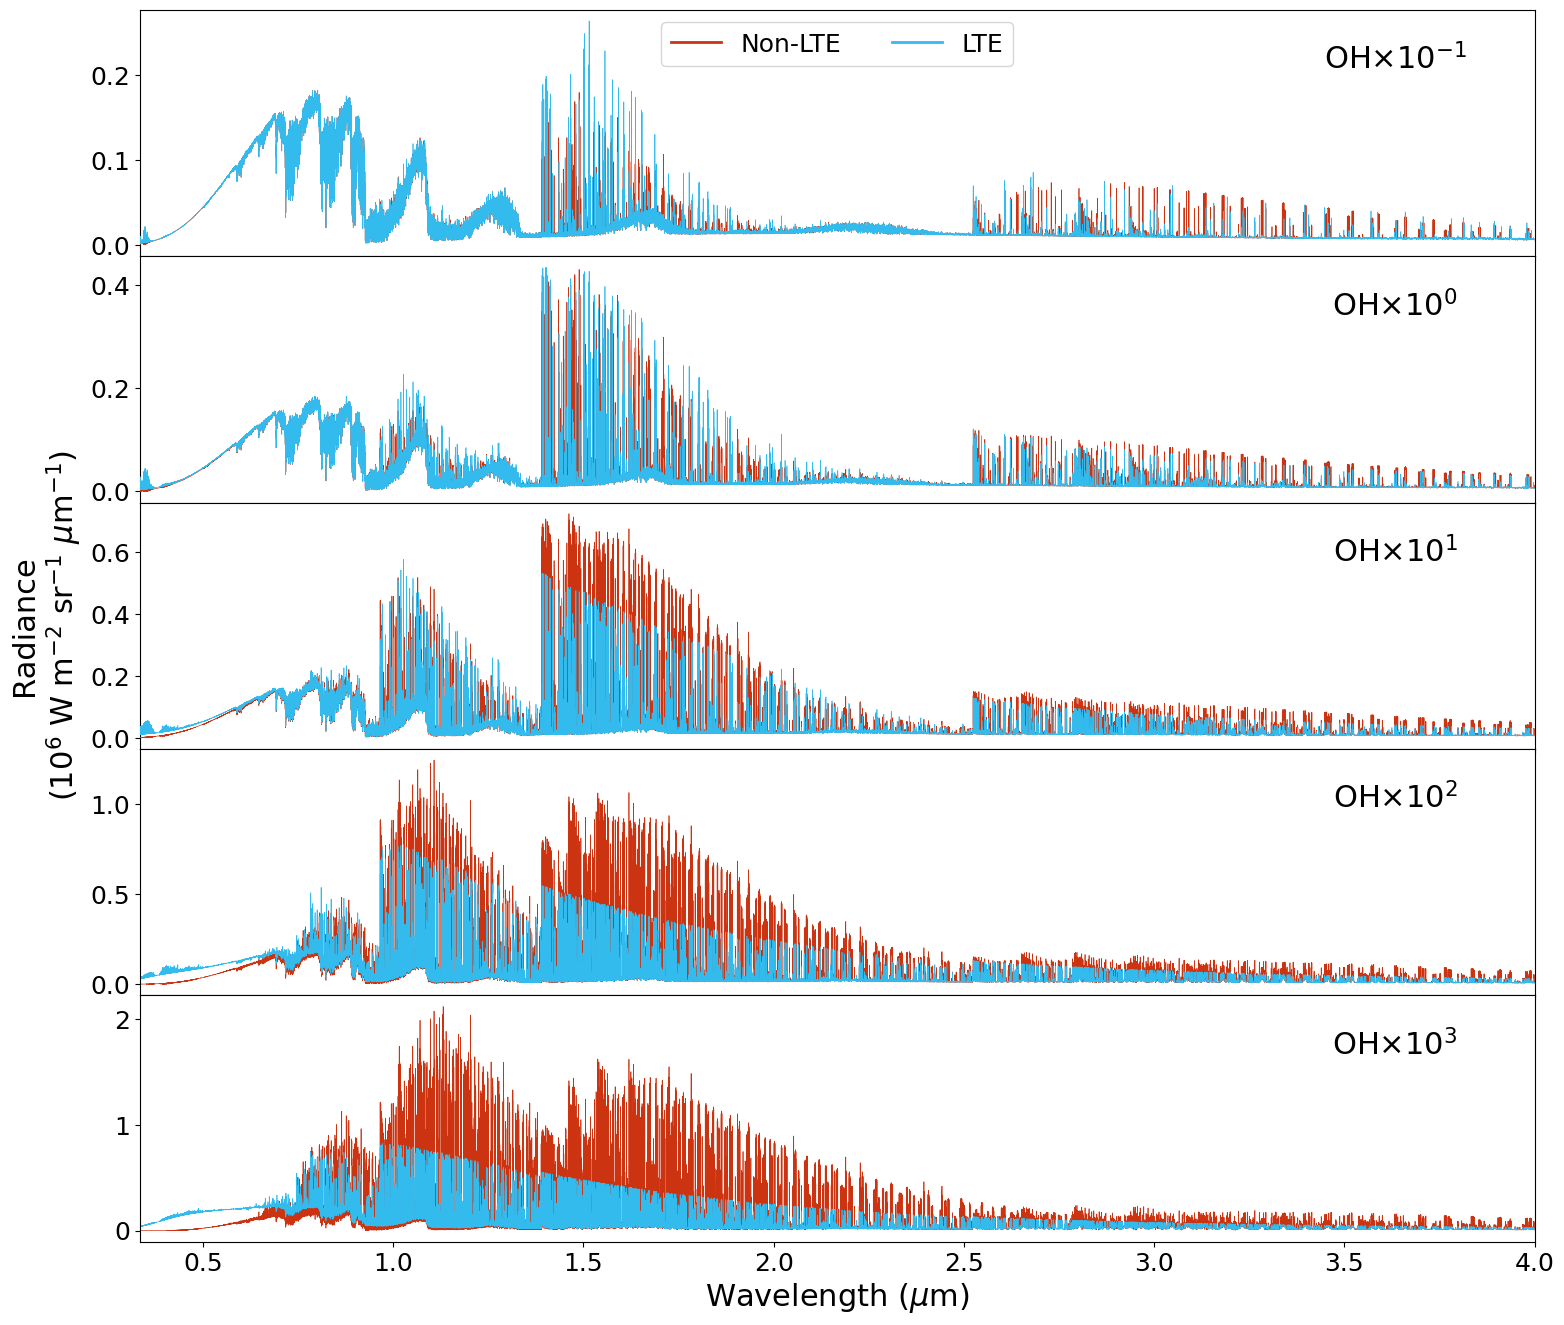

In [6]:
from matplotlib.legend_handler import HandlerLine2D

root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
def load_emission(bl: int, oh_scale: float,) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # output_folder = "outputs_working_full_prec" if oh_scale == 1 else "outputs"
    # output_folder = "outputs_working_full_prec" if oh_scale == 1 else "outputs2" if oh_scale == 0.1 else "outputs"
    output_folder = "outputs3" if oh_scale == 100 else "outputs2"
    # output_folder = "outputs2"
    load_folder = rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/"
    nlte_emission = np.loadtxt(rf"{load_folder}/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)
    lte_emission = np.loadtxt(rf"{load_folder}/KELT-20b_LTE_intensity_up.txt")[-1]  #.sum(axis=0)
    wn_grid_file = glob.glob(f"KELT-20b_nLTE_cont_L{bl}*.txt", root_dir=load_folder)[0]
    # wn_grid = np.loadtxt(f"{load_folder}{wn_grid_file}")[:, 0]
    wn_grid = np.loadtxt(f"{load_folder}nLTE_spectral_grid.txt")
    return nlte_emission, lte_emission, wn_grid


x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e6
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)"
line_width = 0.5  # 0.3

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(18, 16))

plot_bl = 20
x_min = 1e4 / 30000
x_max = 4
plot_abundances = [0.1, 1, 10, 100, 1000]
plot_axs = [ax1, ax2, ax3, ax4, ax5]
nlte_color = "#CC3311"
lte_color = "#33BBEE"
for plot_idx, plot_ax in enumerate(plot_axs):
    plot_abund = plot_abundances[plot_idx]
    nlte_emission, lte_emission, wn_grid = load_emission(20, plot_abund)
    nlte_radiance = (
        nlte_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx,
                             color=nlte_color, label=f"Non-LTE", linewidth=line_width)
    lte_radiance = (
        lte_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=len(plot_abundances) -  plot_idx,
                            color=lte_color, label=f"LTE", linewidth=line_width)

    plot_ax.text(0.9, 0.8, f"OH$\\times10^{{{int(plot_idx - 1)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                 # fontweight="bold"
                 )

    print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")
    if plot_idx != 4:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False, labelsize=tick_fontsize)
    else:
        plot_ax.set_xlabel(x_label, fontsize=label_fontsize)
    plot_ax.tick_params(axis="both", which="both", labelsize=tick_fontsize)
    plot_ax.set_xlim(left=x_min, right=x_max)
    # plot_ax.set_ylim(bottom=0, top=50)
    if plot_idx == 2:
        plot_ax.set_ylabel(y_label, fontsize=label_fontsize)
    if plot_idx == 0:
        legend = plot_ax.legend(loc="upper center", fontsize=tick_fontsize, ncol=2)
        plt.setp(legend.get_lines(), linewidth=2)
    # plot_ax.set_yscale("log")

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_emission.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

# Convergence

/tmp/ipykernel_5265/911782229.py:7: RuntimeWarning: overflow encountered in divide
  pop_dif_3 = (abs(pop_matrix_3[1:, :, :11] - pop_matrix_3[:-1, :, :11]) / pop_matrix_3[:-1, :, :11]).max(axis=(1, 2))
/tmp/ipykernel_5265/911782229.py:8: RuntimeWarning: overflow encountered in divide
  pop_dif_2 = (abs(pop_matrix_2[1:, :, :11] - pop_matrix_2[:-1, :, :11]) / pop_matrix_2[:-1, :, :11]).max(axis=(1, 2))
/tmp/ipykernel_5265/911782229.py:12: RuntimeWarning: overflow encountered in divide
  pop_dif_1 = (abs(pop_matrix_1[1:, :, :11] - pop_matrix_1[:-1, :, :11]) / pop_matrix_1[:-1, :, :11]).max(axis=(1, 2))


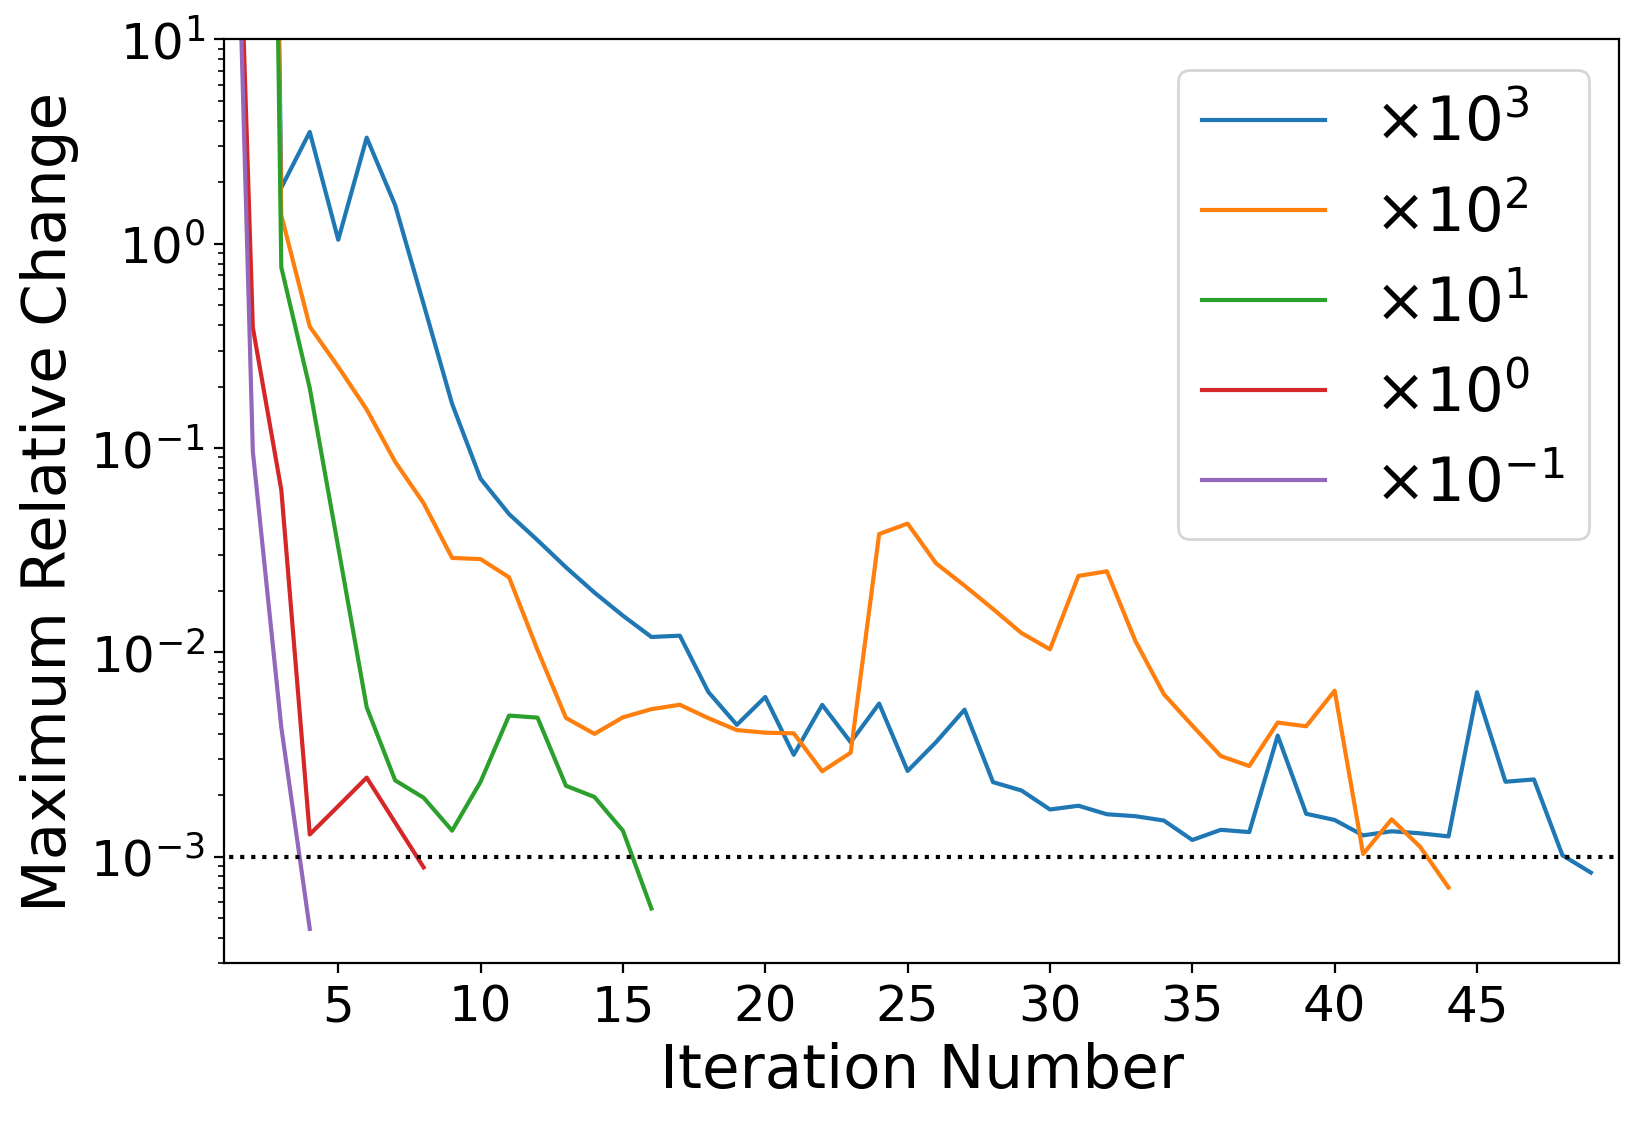

In [7]:
pop_matrix_3 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_2 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs3/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_1 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_0 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_m1 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))

pop_dif_3 = (abs(pop_matrix_3[1:, :, :11] - pop_matrix_3[:-1, :, :11]) / pop_matrix_3[:-1, :, :11]).max(axis=(1, 2))
pop_dif_2 = (abs(pop_matrix_2[1:, :, :11] - pop_matrix_2[:-1, :, :11]) / pop_matrix_2[:-1, :, :11]).max(axis=(1, 2))
# pop_dif_2 = abs(pop_matrix_2[1:, :, :11] - pop_matrix_2[:-1, :, :11]) / pop_matrix_2[:-1, :, :11]
# pop_dif_2[pop_dif_2 == np.inf] = 0
# pop_dif_2 = pop_dif_2.max(axis=(1, 2))
pop_dif_1 = (abs(pop_matrix_1[1:, :, :11] - pop_matrix_1[:-1, :, :11]) / pop_matrix_1[:-1, :, :11]).max(axis=(1, 2))
pop_dif_0 = (abs(pop_matrix_0[1:, :, :11] - pop_matrix_0[:-1, :, :11]) / pop_matrix_0[:-1, :, :11]).max(axis=(1, 2))
pop_dif_m1 = (abs(pop_matrix_m1[1:, :, :11] - pop_matrix_m1[:-1, :, :11]) / pop_matrix_m1[:-1, :, :11]).max(axis=(1, 2))

pop_dif_3[pop_dif_3 == np.inf] = 1e10
pop_dif_2[pop_dif_2 == np.inf] = 1e10
pop_dif_1[pop_dif_1 == np.inf] = 1e10
pop_dif_0[pop_dif_0 == np.inf] = 1e10
pop_dif_m1[pop_dif_m1 == np.inf] = 1e10

plt.figure(figsize=(9, 6), dpi=200)
plt.plot(np.arange(1, pop_dif_3.shape[0] + 1), pop_dif_3, label=r"$\times10^{3}$")
plt.plot(np.arange(1, pop_dif_2.shape[0] + 1), pop_dif_2, label=r"$\times10^{2}$")
plt.plot(np.arange(1, pop_dif_1.shape[0] + 1), pop_dif_1, label=r"$\times10^{1}$")
plt.plot(np.arange(1, pop_dif_0.shape[0] + 1), pop_dif_0, label=r"$\times10^{0}$")
plt.plot(np.arange(1, pop_dif_m1.shape[0] + 1), pop_dif_m1, label=r"$\times10^{-1}$")
plt.hlines(xmin=0, xmax=len(pop_dif_3) + 1, y=1e-3, linestyle=":", color="#000000")
plt.yscale("log")
plt.ylim(bottom=3e-4, top=1e1)
plt.xlim(left=1, right=len(pop_dif_3) + 1)
xticks = np.arange(5, len(pop_dif_3) + 1, 5, dtype=int)
plt.xticks(ticks=xticks, labels=xticks)
plt.tick_params(labelsize=tick_fontsize)
plt.xlabel("Iteration Number", fontsize=label_fontsize)
plt.ylabel("Maximum Relative Change", fontsize=label_fontsize)
plt.legend(loc="upper right", fontsize=label_fontsize)
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_convergence.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

# Masing tests

85561
81791
77434
Num. NLTE (1e-5) Inf = 0
(1e-5) Max = 5.2091335336338376e+32 J / (s sr um m2)
Num. NLTE (1e-6) Inf = 0
(1e-6) Max = 30543334.048043303 J / (s sr um m2)
LTE Max = 432774.6444077958 J / (s sr um m2)


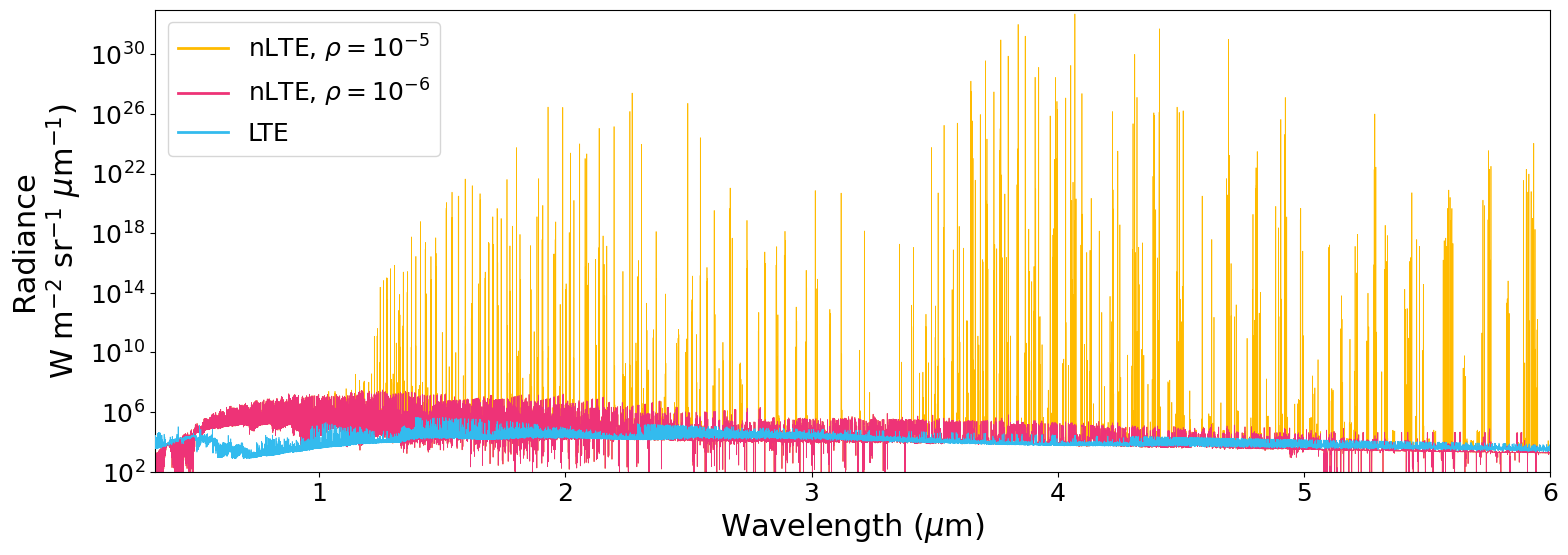

In [11]:
root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
output_folder = "masing_test"
lte_emission = np.loadtxt(rf"{root_dir}1xOH_bL20/outputs_new6/KELT-20b_LTE_intensity_up.txt")[-1]  #.sum(axis=0)
nlte_emission = np.loadtxt(rf"{root_dir}masing_test/outputs/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)
nlte_emission_5 = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-5/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)
nlte_emission_6 = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-6/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)
nlte_emission_8 = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-8/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)
# nlte_emission_12 = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-12/KELT-20b_nLTE_intensity_up.txt")[-1]  #.sum(axis=0)

print(len(nlte_emission_6))
print(np.sum(nlte_emission_5 == nlte_emission_6))
print(np.sum(nlte_emission_6 == nlte_emission_8))
# print(np.sum(nlte_emission_8 == nlte_emission_12))

wn_grid = np.loadtxt(rf"{root_dir}1xOH_bL20/outputs_working_full_prec/KELT-20b_cont_1xOH_boundaryL20_transmission_highres.txt")[:, 0]

x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e0
y_label = "Radiance\n"+r"W m$^{-2}$ sr$^{-1}$ ${\mu}$m$^{-1}$)"
line_width = 0.5
# line_width = 1.0

# figure_size = (15, 6)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size)
figure_size = (18, 6)
fig = plt.figure(figsize=figure_size)

plot_bl = 20
# plot_abundances = [0.1, 1, 10, 100, 1000]
plot_abundances = [1]
plot_colors = get_vibrant_colors(n_colors=5, ordered=True)
lte_color = "#33BBEE"
for plot_idx, plot_abund in enumerate(plot_abundances):
    nlte_radiance_5 = (
        nlte_emission_5
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(nlte_wavelength, nlte_radiance_5 / radiance_scale_factor, zorder=1, color="#FFBB00", label="nLTE, $\\rho = 10^{-5}$", linewidth=line_width)
    print(f"Num. NLTE (1e-5) Inf = {np.sum(nlte_radiance_5 == np.inf)}")
    print(f"(1e-5) Max = {np.max(nlte_radiance_5)}")
    nlte_radiance_6 = (
        nlte_emission_6
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(nlte_wavelength, nlte_radiance_6 / radiance_scale_factor, zorder=1, color="#EE3377", label="nLTE, $\\rho = 10^{-6}$", linewidth=line_width)
    print(f"Num. NLTE (1e-6) Inf = {np.sum(nlte_radiance_6 == np.inf)}")
    print(f"(1e-6) Max = {np.max(nlte_radiance_6)}")
    # nlte_radiance_8 = (
    #     nlte_emission_8
    #     * (u.J * u.m**-2)
    #     * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    # ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    # nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    # plt.plot(nlte_wavelength, nlte_radiance_8 / radiance_scale_factor, zorder=1, color=plot_colors[3] + "80", label="$\\rho = 10^{-8}$", linewidth=line_width)
    # print(f"Num. NLTE (1e-8) Inf = {np.sum(nlte_radiance_8 == np.inf)}")
    # print(f"(1e-8) Max = {np.max(nlte_radiance_8)}")
    # nlte_radiance_12 = (
    #     nlte_emission_12
    #     * (u.J * u.m**-2)
    #     * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    # ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    # nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    # plt.plot(nlte_wavelength, nlte_radiance_12 / radiance_scale_factor, zorder=2, color=plot_colors[4] + "80", label=f"Non-LTE (1e-12)", linewidth=line_width)
    # print(f"Num. NLTE (1e-12) Inf = {np.sum(nlte_radiance_12 == np.inf)}")
    # print(f"(1e-12) Max = {np.max(nlte_radiance_12)}")
    lte_radiance = (
        lte_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plt.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=3, color=lte_color, label=f"LTE", linewidth=line_width)
    print(f"LTE Max = {np.max(lte_radiance)}")

x_min = 1e4 / 30000
x_max = 6
plt.xlim(left=x_min, right=x_max)
# plt.ylim(bottom=0, top=3.2e1)
plt.yscale("log")
plt.ylim(bottom=1e2, top=1e33)
plt.tick_params(axis="both", which="both", labelsize=tick_fontsize)
plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
legend = plt.legend(loc="upper left", fontsize=tick_fontsize)
plt.setp(legend.get_lines(), linewidth=2)

plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_masing_test.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

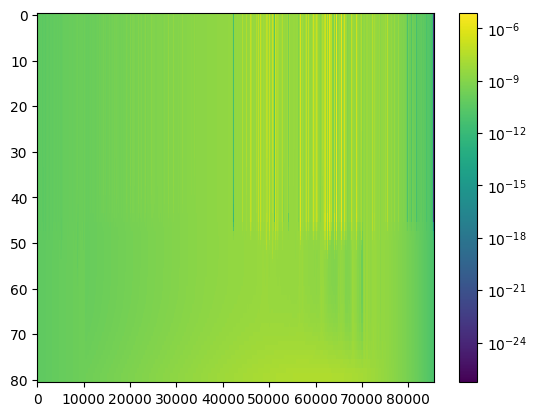

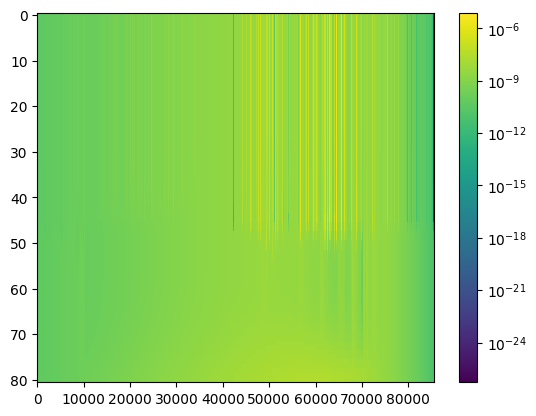

In [9]:
nlte_emission = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-12/KELT-20b_nLTE_intensity_up.txt")
from matplotlib.colors import LogNorm
# nlte_emission2[nlte_emission2 > 1e200] = np.nan
plt.imshow(nlte_emission[::-1], aspect="auto", cmap="viridis", norm=LogNorm(), interpolation="none")
plt.colorbar()
plt.show()
nlte_emission = np.loadtxt(rf"{root_dir}masing_test/outputs_1e-8/KELT-20b_nLTE_intensity_up.txt")
from matplotlib.colors import LogNorm
# nlte_emission2[nlte_emission2 > 1e200] = np.nan
plt.imshow(nlte_emission[::-1], aspect="auto", cmap="viridis", norm=LogNorm(), interpolation="none")
plt.colorbar()
plt.show()

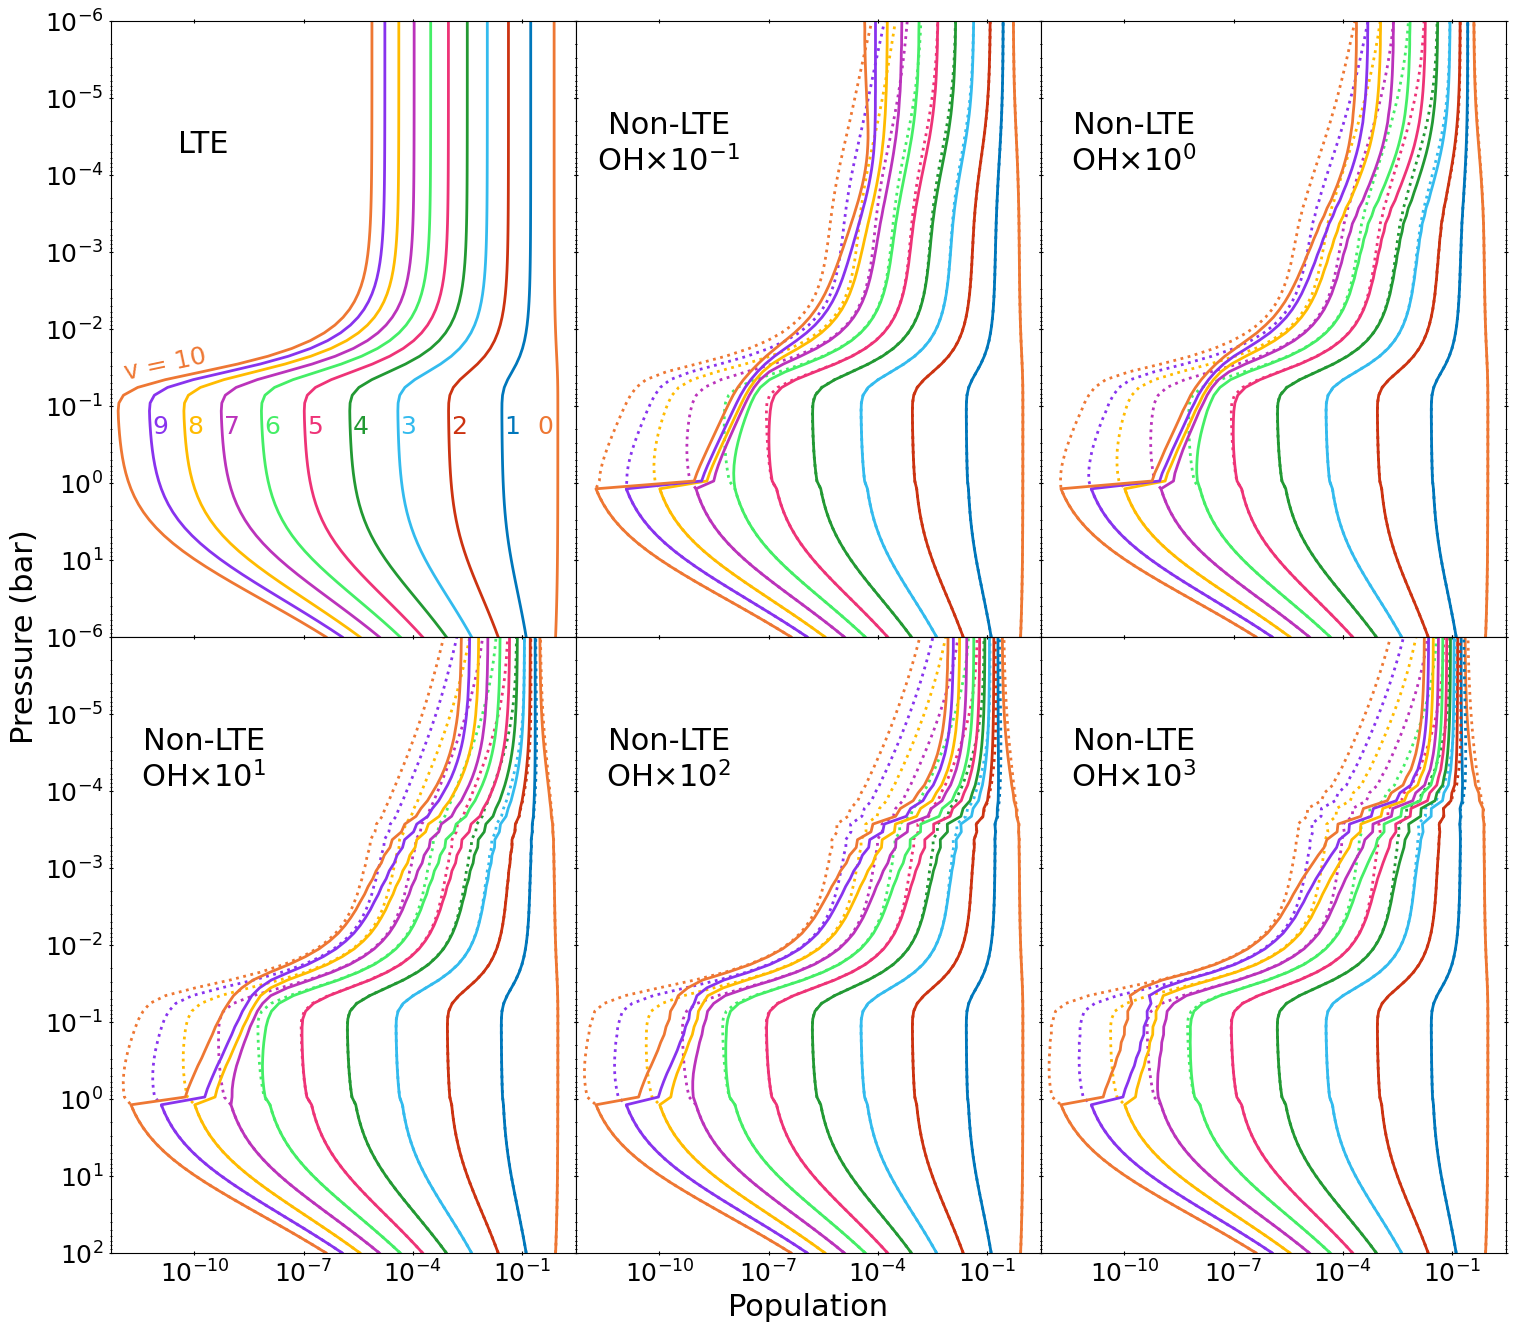

In [10]:
x1000OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x100OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs3/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x10OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x1OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
x01OH_bL20_pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL20/outputs2/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))

pop_matrix_1e3 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_1e2 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_1e1 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/10xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_1e0 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
pop_matrix_1em1 = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/0.1xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))

line_width = 2
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 16))

max_v = 10
plot_colors = get_vibrant_colors(max_v + 1)


nlte_axs = [ax1, ax2, ax3, ax4, ax5, ax6]
plot_pops = [x1OH_bL20_pop_matrix, x01OH_bL20_pop_matrix, x1OH_bL20_pop_matrix, x10OH_bL20_pop_matrix, x100OH_bL20_pop_matrix, x1000OH_bL20_pop_matrix]
plot_labels = ["LTE", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$", "Non-LTE\nOH$\\times10$^{-1}$"]
compare_pops = [pop_matrix_1e0, pop_matrix_1em1, pop_matrix_1e0, pop_matrix_1e1, pop_matrix_1e2, pop_matrix_1e3]

for ax_idx, plot_ax in enumerate(nlte_axs):
    plot_pop = plot_pops[ax_idx]
    compare_pop = compare_pops[ax_idx]
    plot_iter = 0 if ax_idx == 0 else -1
    for v_val in range(0, max_v + 1):
        plot_ax.plot(plot_pop[plot_iter, :, v_val], central_pressure, label=f"v={v_val}", color=plot_colors[v_val], linewidth=line_width, linestyle="-")
        if ax_idx >= 1:
            plot_ax.plot(compare_pop[plot_iter, :, v_val], central_pressure, label=f"v={v_val}", color=plot_colors[v_val], linewidth=line_width, linestyle=":")
        # plot_ax.plot(plot_pop[0, :, v_val], central_pressure, color=plot_colors[v_val] + "44", linewidth=line_width/2, linestyle="-", label="LTE")
    plot_ax.set_xscale("log")
    plot_ax.set_xlim(left=5e-13, right=3e0)
    plot_ax.set_yscale("log")
    plot_ax.set_ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
    plot_ax.invert_yaxis()
    plot_ax.tick_params(which="both", labelsize=tick_fontsize, direction="inout", bottom=True, top=True, left=True, right=True)
    if ax_idx == 0:
        plot_ax.text(0.2, 0.8, "LTE", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )
        v_annotation_height = 27
        plot_ax.annotate(0, xy=(plot_pop[plot_iter, v_annotation_height, 0], central_pressure[v_annotation_height].value),
                 xytext=(-0.2, 0), xycoords="data", textcoords="offset fontsize",
                 ha="right", va="center", color=plot_colors[0], fontsize=tick_fontsize)
        for v_val in range(1, max_v):
            # plot_ax.text(plot_pop[plot_iter, v_annotation_height, v_val], central_pressure[v_annotation_height].value, v_val,
            #                  ha="left", va="center", color=plot_colors[v_val], fontsize=tick_fontsize)
            plot_ax.annotate(v_val, xy=(plot_pop[plot_iter, v_annotation_height, v_val], central_pressure[v_annotation_height].value),
                             xytext=(0.1, 0), xycoords="data", textcoords="offset fontsize",
                             ha="left", va="center", color=plot_colors[v_val], fontsize=tick_fontsize)
        plot_ax.text(1e-12, central_pressure[35].value, "v = 10", ha="left", va="center", color=plot_colors[10], fontsize=tick_fontsize, rotation=12)
    else:
        plot_ax.text(0.2, 0.8, f"Non-LTE\nOH$\\times10^{{{int(ax_idx - 2)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                     # fontweight="bold"
                     )

    if ax_idx <=2:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False)
    elif ax_idx == 4:
        plot_ax.set_xlabel("Population", fontsize=label_fontsize)

    if ax_idx % 3 != 0:
        plot_ax.tick_params(axis="y", which="both", labelleft=False)
    elif ax_idx == 0:
        y_ticks = plot_ax.get_yticks()
        y_ticks = y_ticks[1:-2]
        plot_ax.set_yticks(y_ticks)
        plot_ax.set_ylabel("Pressure (bar)", fontsize=label_fontsize, y=central_pressure[-1].value)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_populations_comparison.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

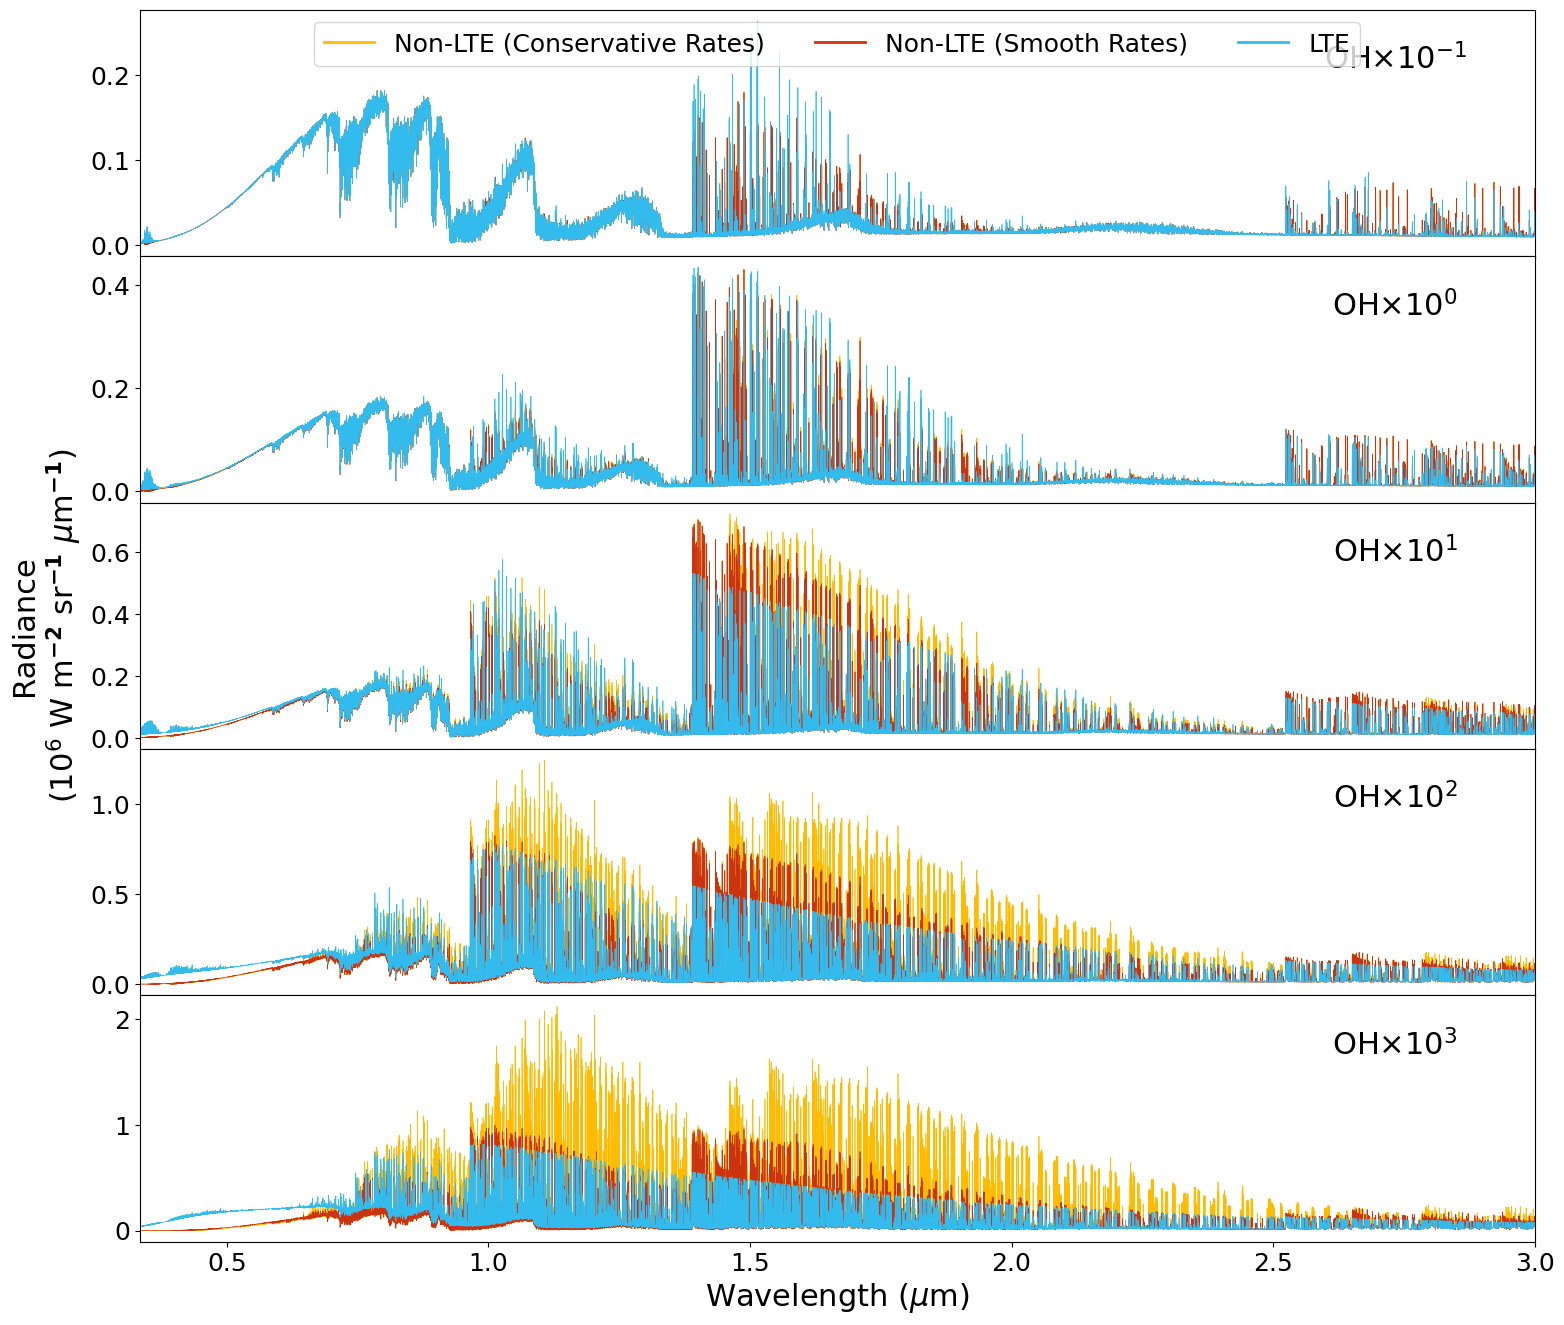

In [8]:
from matplotlib.legend_handler import HandlerLine2D

root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
def load_emission(bl: int, oh_scale: float) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    output_folder = "outputs2"
    load_folder = rf"{root_dir}{oh_scale}xOH_bL{bl}/{output_folder}/"
    test_folder = "outputs_colr_test"
    load_test_folder = rf"{root_dir}{oh_scale}xOH_bL{bl}/{test_folder}/"
    nlte_emission = np.loadtxt(rf"{load_folder}/KELT-20b_nLTE_intensity_up.txt")[-1]
    nlte_test_emission = np.loadtxt(rf"{load_test_folder}/KELT-20b_nLTE_intensity_up.txt")[-1]
    lte_emission = np.loadtxt(rf"{load_folder}/KELT-20b_LTE_intensity_up.txt")[-1]
    wn_grid = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/100xOH_bL20/outputs_colr_test/LTE_spectral_grid.txt")
    return nlte_emission, nlte_test_emission, lte_emission, wn_grid


x_label = r"Wavelength ($\mu$m)"
# x_wl_label = r"Wavelength ($\mathbf{\mu}$m)"
radiance_scale_factor = 1e6
y_label = f"Radiance\n($10^{{{int(np.log10(radiance_scale_factor))}}}$" + r" W m$^\mathbf{-2}$ sr$^\mathbf{-1}$ $\mu$m$^\mathbf{-1}$)"
line_width = 0.5  # 0.3

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(18, 16))

plot_bl = 20
x_min = 1e4 / 30000
x_max = 3
plot_abundances = [0.1, 1, 10, 100, 1000]
plot_axs = [ax1, ax2, ax3, ax4, ax5]
nlte_color = "#FFBB00"
nlte_test_color = "#CC3311"
lte_color = "#33BBEE"
for plot_idx, plot_ax in enumerate(plot_axs):
    plot_abund = plot_abundances[plot_idx]
    nlte_emission, nlte_test_emission, lte_emission, wn_grid = load_emission(20, plot_abund)
    nlte_radiance = (
        nlte_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(nlte_wavelength, nlte_radiance / radiance_scale_factor, zorder=0,
                             color=nlte_color, label="Non-LTE (Conservative Rates)", linewidth=line_width)

    nlte_test_radiance = (
        nlte_test_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    nlte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(nlte_wavelength, nlte_test_radiance / radiance_scale_factor, zorder=1,
                             color=nlte_test_color, label="Non-LTE (Smooth Rates)", linewidth=line_width)

    lte_radiance = (
        lte_emission
        * (u.J * u.m**-2)
        * (ac.c / (4 * np.pi * u.sr * (wn_grid * u.k).to(u.m, equivalencies=u.spectral()) ** 2))
    ).to(u.J / (u.m**2 * u.s * u.um * u.sr), equivalencies=u.spectral())
    lte_wavelength = (wn_grid * u.k).to(u.um, equivalencies=u.spectral())
    plot_ax.plot(lte_wavelength, lte_radiance / radiance_scale_factor, zorder=2,
                            color=lte_color, label=f"LTE", linewidth=line_width)

    plot_ax.text(0.9, 0.8, f"OH$\\times10^{{{int(plot_idx - 1)}}}$", ha="center", va="center", transform=plot_ax.transAxes, fontsize=label_fontsize,
                 # fontweight="bold"
                 )

    # print(f"OHx{plot_abund} radiance scale NLTE/LTE = {nlte_radiance.sum()/lte_radiance.sum()}")
    if plot_idx != 4:
        plot_ax.tick_params(axis="x", which="both", labelbottom=False, labelsize=tick_fontsize)
    else:
        plot_ax.set_xlabel(x_label, fontsize=label_fontsize)
    plot_ax.tick_params(axis="both", which="both", labelsize=tick_fontsize)
    plot_ax.set_xlim(left=x_min, right=x_max)
    # plot_ax.set_ylim(bottom=0, top=50)
    if plot_idx == 2:
        plot_ax.set_ylabel(y_label, fontsize=label_fontsize)
    if plot_idx == 0:
        legend = plot_ax.legend(loc="upper center", fontsize=tick_fontsize, ncol=3)
        plt.setp(legend.get_lines(), linewidth=2)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_emission_comparison.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

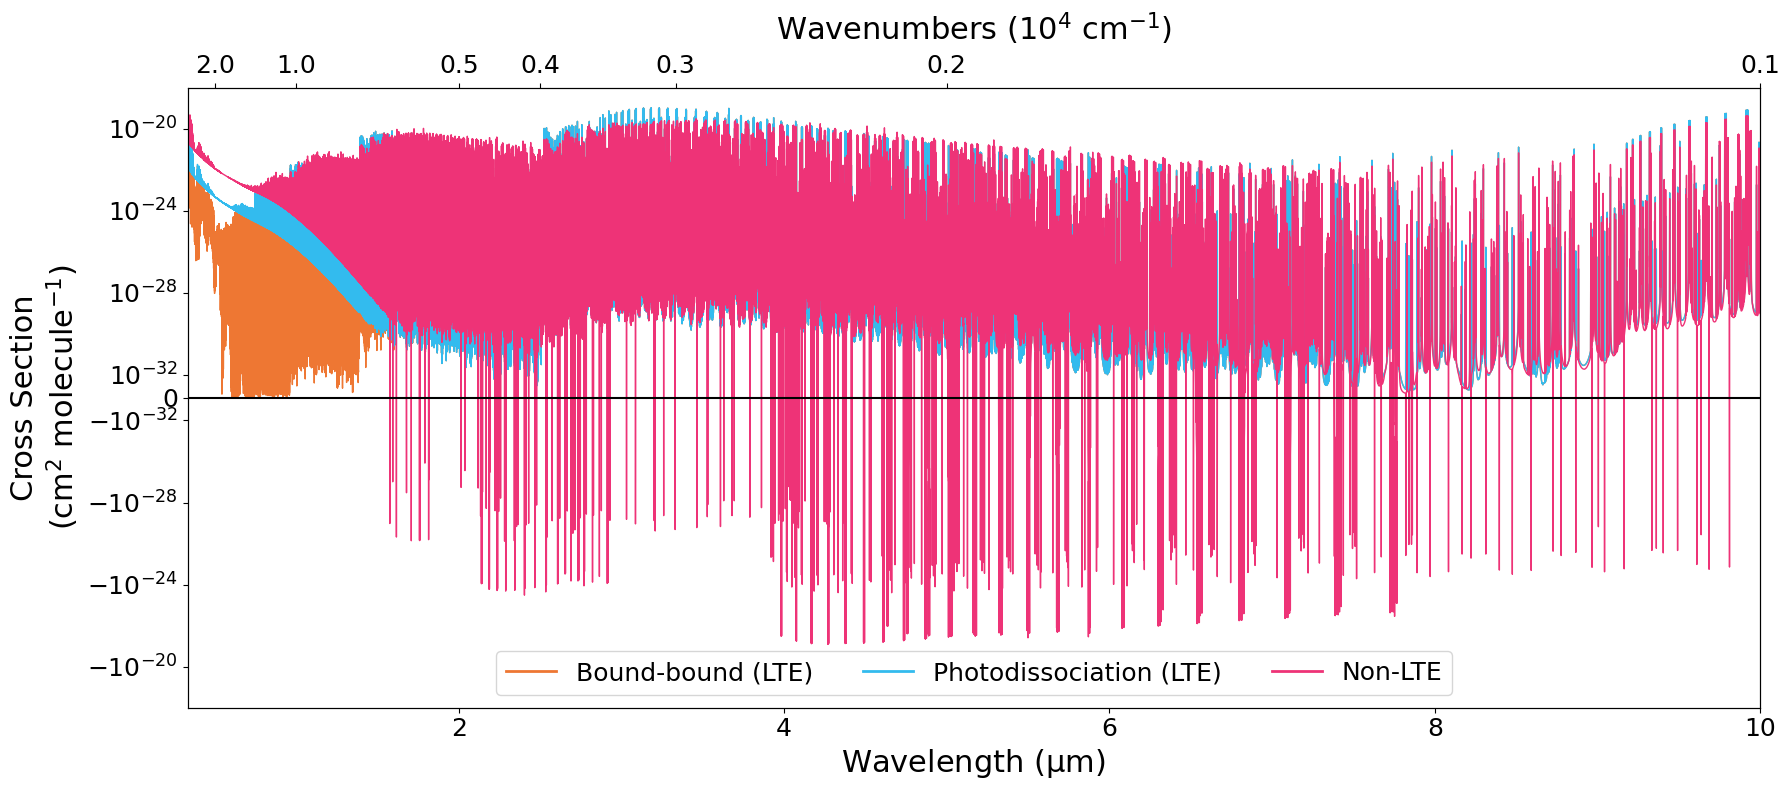

In [15]:
base_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs2/"
lte_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_T3375_P1.0000e-06.txt")
lte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_LTE_TOA_cont_T3375_P1.0000e-06.txt")
nlte_cont_toa_xsec = np.loadtxt(f"{base_dir}KELT-20b_nLTE_TOA_cont_T3375_P1.0000e-06.txt")
line_width = 1

plt.figure(figsize=(18, 8))

x_label = r"Wavenumbers (10$^{4}$ cm$^{-1}$)"
x_wl_label = r"Wavelength (${\rm \mu}$m)"
y_label = "Cross Section\n(cm$^{2}$ molecule$^{-1}$)"

plt.plot(1e4 / lte_toa_xsec[:, 0], lte_toa_xsec[:, 1], linewidth=line_width, zorder=1, label="Bound-bound (LTE)", color="#EE7733")
plt.plot(1e4 / lte_cont_toa_xsec[:, 0], lte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=2, label="Photodissociation (LTE)", color="#33BBEE")
plt.plot(1e4 / nlte_cont_toa_xsec[:, 0], nlte_cont_toa_xsec[:, 1], linewidth=line_width, zorder=3, label="Non-LTE", color="#EE3377")
# plt.xlim(left=lte_toa_xsec[0, 0] / 1e4, right=lte_toa_xsec[-1, 0] / 1e4)
plt.xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
ylim = plt.gca().get_ylim()
plt.ylim(bottom=-ylim[1], top=ylim[1])

# plt.text(0.1, 0.9, "Absorption", ha="left", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")
# plt.text(0.1, 0.1, "Stimulated Emission", ha="left", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")

plt.hlines(y=0, xmin=plt.gca().get_xlim()[0], xmax=plt.gca().get_xlim()[1], color="#000000", zorder=4)
plt.yscale("log")
plt.yscale("symlog", linthresh=1e-32)
y_lim = 1e-18
plt.ylim(bottom=-y_lim, top=y_lim)
legend = plt.legend(loc="lower center", fontsize=tick_fontsize, ncols=3)
plt.setp(legend.get_lines(), linewidth=2)
plt.xlabel(x_wl_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wn = plt.gca().twiny()
wn_tick_vals = [2.0, 1.0, 0.5, 0.4, 0.3, 0.2, 0.1]
new_tick_locations = [1 / x for x in wn_tick_vals]
ax_wn.set_xlim(left=1e4 / lte_toa_xsec[-1, 0], right=10)
ax_wn.set_xlabel(x_label, fontsize=label_fontsize,
                 # fontweight="bold",
                 labelpad=10)
ax_wn.set_xticks(ticks=new_tick_locations, labels=wn_tick_vals, fontsize=tick_fontsize)

plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/KELT-20b_TOA_xsecs.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

Ratio = 0.7263297624768078
Ratio = 0.7322272042899967
Ratio = 0.7402794746533656
Ratio = 0.7515353376059565
Ratio = 0.76571491077725
Ratio = 0.7850217693831354
Ratio = 0.8080433114610546
Ratio = 0.837923809834506
Ratio = 0.8758495361656974
Ratio = 0.9228477396147109
Ratio = 0.9728049308485461
Ratio = 0.9939235294854475
Ratio = 0.9259101352890363
Ratio = 0.8149499755206193
Ratio = 0.7476988616248121
Ratio = 0.7277763430566605
Ratio = 0.7173440347407282
Ratio = 0.7143400417619278
Ratio = 0.7083984105515532
Ratio = 0.706824069497868
Ratio = 0.7035740030603874
Ratio = 0.7036346065466765
Ratio = 0.7024690171737088
Ratio = 0.7038427992724507
Ratio = 0.7062078760863169
Ratio = 0.7090048474932151
Ratio = 0.7141217917886625
Ratio = 0.7198329430979118
Ratio = 0.7299004818914105
Ratio = 0.7381305892139206
Ratio = 0.7536913534232921
Ratio = 0.7670850032796048
Ratio = 0.7906559564832398
Ratio = 0.812789395418218
Ratio = 0.850814454927805
Ratio = 0.8893046121636341
Ratio = 0.9454503381711781
Ratio =

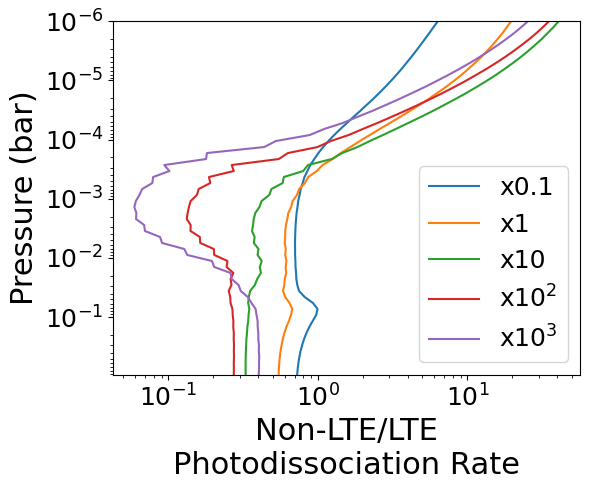

In [4]:
def xsec_to_rate(xsec: npt.NDArray[np.float64], intensity: u.Quantity) -> u.Quantity:
    wl_grid = (xsec[:, 0] * u.k).to(u.um, equivalencies=u.spectral())
    intensity_field = intensity * ac.c / (wl_grid ** 2)
    intensity_field = intensity_field.to(u.J / (u.s * u.cm**2 * u.um), equivalencies=u.spectral())
    intensity_field = intensity_field / (ac.h * ac.c / wl_grid)
    intensity_field = intensity_field.to(1 / (u.s * u.um * u.cm**2),  equivalencies=u.spectral())
    product = intensity_field * (xsec[:, 1] * u.cm**2)
    rate = simpson(product[::-1], x=wl_grid.value[::-1])
    return rate


root_dir = r"/mnt/c/PhD/NLTE/Models/KELT-20b/"
# model_dir = f"{root_dir}1xOH_bL20/outputs_working_full_prec/"
output_folder = "outputs_colr_test"
model_dirs = [f"{root_dir}0.1xOH_bL20/{output_folder}/", f"{root_dir}1xOH_bL20/{output_folder}/", f"{root_dir}10xOH_bL20/{output_folder}/", f"{root_dir}100xOH_bL20/{output_folder}/", f"{root_dir}1000xOH_bL20/{output_folder}/"]
model_labels = ["x0.1", "x1", "x10", "x10$^{2}$", "x10$^{3}$"]
# model_dir = f"{root_dir}100xOH_bL20/outputs/"

plt.figure(figsize=(6, 5))

for model_idx, model_dir in enumerate(model_dirs):
    rate_ratios = []
    # plot_temps = np.concatenate(([300], np.linspace(2000, 10000, 5)))
    # plot_ratios = [[] for _ in plot_temps]
    lte_intensity_up = np.loadtxt(f"{model_dir}KELT-20b_LTE_intensity_up.txt")
    lte_intensity_down = np.loadtxt(f"{model_dir}KELT-20b_LTE_intensity_down.txt")
    nlte_intensity_up = np.loadtxt(f"{model_dir}KELT-20b_nLTE_intensity_up.txt")
    nlte_intensity_down = np.loadtxt(f"{model_dir}KELT-20b_nLTE_intensity_down.txt")

    lte_intensity = (lte_intensity_up + lte_intensity_down) << (u.J / u.m**2)
    nlte_intensity = (nlte_intensity_up + nlte_intensity_down) << (u.J / u.m**2)

    for layer_idx in range(20, 80):
        nlte_file = glob.glob(f"KELT-20b_nLTE_cont_L{layer_idx}*.txt", root_dir=model_dir)[0]
        lte_file = glob.glob(f"KELT-20b_LTE_cont_L{layer_idx}*.txt", root_dir=model_dir)[0]
        nlte_cont_xsec = np.loadtxt(f"{model_dir}{nlte_file}")
        lte_cont_xsec = np.loadtxt(f"{model_dir}{lte_file}")
        # for plot_idx, plot_temp in enumerate(plot_temps):
        #     nlte_rate = xsec_to_rate(nlte_cont_xsec, plot_temp)
        #     lte_rate = xsec_to_rate(lte_cont_xsec, plot_temp)
        #     # print(f"NLTE rate = {nlte_rate}")
        #     # print(f"LTE rate = {lte_rate}")
        #     rate_ratio = nlte_rate/lte_rate
        #     plot_ratios[plot_idx].append(rate_ratio)
        nlte_rate = xsec_to_rate(nlte_cont_xsec, nlte_intensity[layer_idx + 1])
        lte_rate = xsec_to_rate(lte_cont_xsec, lte_intensity[layer_idx + 1])
        rate_ratio = nlte_rate/lte_rate
        print(f"Ratio = {rate_ratio}")
        rate_ratios.append(rate_ratio)

    # for plot_idx, plot_temp in enumerate(plot_temps):
    #     plt.plot(plot_ratios[plot_idx], central_pressure[20:], label=f"T$_{{*}}$={plot_temp} K")
    plt.plot(rate_ratios, central_pressure[20:], label=model_labels[model_idx])
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.ylim(bottom=central_pressure[20].value, top=central_pressure[-1].value)
plt.xlabel("Non-LTE/LTE\nPhotodissociation Rate", fontsize=label_fontsize,
           #fontweight="bold"
           )
plt.ylabel(r"Pressure (bar)", fontsize=label_fontsize,
           # fontweight="bold"
           )
plt.tick_params(labelsize=tick_fontsize)
plt.legend(loc="best", fontsize=tick_fontsize)
plt.tight_layout()
# plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/figures/paper/OH_photodissociation_rate.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()